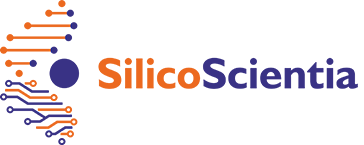


---



# **AutoDock Vina Molecular Docking Tool Integrating AI/ML Techniques**

Welcome to this comprehensive tutorial on molecular docking using AutoDock Vina, enhanced with machine learning (ML) techniques for binding energy prediction. This workflow is designed for researchers and students in computational chemistry and drug discovery, providing a step-by-step guide from environment setup to advanced analysis.

**In this tutorial, you will learn how to:**
- Set up your computational environment and install all necessary tools.
- Prepare and upload protein and ligand files in the correct formats.
- Perform molecular docking simulations using AutoDock Vina.
- Analyze and interpret docking results.
- Train a Graph Convolutional Network (GCN) model for predicting binding energies.
- Make predictions on new ligands using the trained ML model.
- Integrate docking and ML results for comprehensive compound evaluation.

This notebook is structured to be accessible for both beginners and experienced users, with detailed explanations and practical tips at each step.

**Download the example data from github link: https://github.com/SilicoScientia/AI-ML-Workshop/archive/refs/heads/main.zip**


In [1]:
!git clone https://github.com/SilicoScientia/AI-ML-Workshop.git

Cloning into 'AI-ML-Workshop'...
remote: Enumerating objects: 898, done.
remote: Counting objects: 100% (557/557), done.
remote: Compressing objects: 100% (534/534), done.
remote: Total 898 (delta 357), reused 23 (delta 23), pack-reused 341 (from 1)
Receiving objects: 100% (898/898), 19.10 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (577/577), done.


In [2]:
%cd AI-ML-Workshop/ML/

/home/ai_ml/user2/AI-ML-Workshop/ML




---

# **Installing Machine Learning Dependencies**

Before starting the molecular docking and ML workflow, we need to install several essential Python packages:

- **PyTorch**: A powerful deep learning framework used for building and training neural networks.
- **RDKit**: A cheminformatics toolkit for working with molecular structures and generating molecular graphs.
- **NetworkX**: A library for the creation, manipulation, and study of complex networks (graphs).
- **Other ML-related dependencies**: Additional packages required for data processing and model training.

**Why are these packages important?**
- They provide the computational backbone for implementing and running the GCN model, which predicts binding energies based on molecular structure.

*Note: Installation commands may take a few minutes to complete.*

In [3]:
# @title
!pip install -r requirements.txt



---


# **Importing Essential Libraries**

In this section, we import the core Python libraries required for the molecular docking workflow:

- `os`: For file and directory operations.
- `subprocess`: To execute external commands, such as running AutoDock Vina.
- `pandas`: For data manipulation and analysis.
- `pathlib`: For handling file paths in a platform-independent way.
- `glob`: For file pattern matching and retrieval.
- `google.colab.files`: For uploading and downloading files in the Colab environment.
- `shutil`: For high-level file operations.
- `rdkit`: For molecular structure handling and visualization.
- `re`: For regular expression operations.

These libraries form the foundation for file management, data processing, and interaction with external software throughout the workflow.

In [4]:
# @title
import os
import subprocess
import pandas as pd
from pathlib import Path
import glob
import shutil
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import re



---


# **Creating Necessary Directories**

To keep your workflow organized, we will create a structured set of directories:

- `protein/`: Stores the target protein file(s).
- `ligands/`: Stores all ligand files to be docked.
- `results/`: Stores the output and results from docking simulations.

**Why is this important?**
- A well-organized directory structure helps manage multiple files, prevents confusion, and ensures a smooth workflow, especially when handling large datasets or batch processing.

In [5]:
# @title
!mkdir results



---

# **Uploading Input Files**

This section guides you through uploading the essential input files for molecular docking:

1. **Protein File Upload**:
   - Upload your prepared protein file in PDBQT format.
   - The file will be automatically moved to the `protein/` directory.

2. **Ligand Files Upload**:
   - Upload one or more ligand files in PDBQT format.
   - All ligand files will be moved to the `ligands/` directory.

**Why PDBQT format?**
- Both protein and ligand files must be in PDBQT format, which includes information about atom types and partial charges required for docking.

*Tip: Ensure your files are properly prepared and named for easy identification later in the workflow.*

In [6]:
# Define other paths
LIGANDS_DIR = 'ligands/'
PROTEIN_PATH = 'protein/' 
RESULTS_DIR = 'results/'



---

# **Visualizing 2D Structures of Ligands**

In this step, we will:

- Convert ligand files from PDBQT to PDB format using OpenBabel.
- Generate 2D molecular structures for each ligand using RDKit.
- Display all ligands in a grid for visual inspection.

**Why visualize ligands?**
- Visual inspection helps verify the integrity and diversity of your ligand set before proceeding with docking.
- It can also reveal potential issues with file preparation or molecular structure.

*Note: This step requires OpenBabel and RDKit to be installed.*

Cleaning up previously generated PDB files...
Successfully processed R046
Successfully processed R050
Successfully processed R044
Successfully processed R012
Successfully processed R007
Successfully processed R029
Successfully processed R049
Successfully processed R016
Successfully processed R024
Successfully processed R035
Successfully processed R036
Successfully processed R001
Successfully processed R039
Successfully processed R030
Successfully processed R045
Successfully processed R018
Successfully processed R010
Successfully processed R013
Successfully processed R042
Successfully processed R021
Successfully processed R011
Successfully processed R017
Successfully processed R008
Successfully processed R014
Successfully processed R037
Successfully processed R041
Successfully processed R040
Successfully processed R009
Successfully processed R031
Successfully processed R020
Successfully processed R006
Successfully processed R026
Successfully processed R025
Successfully processed R003
Su

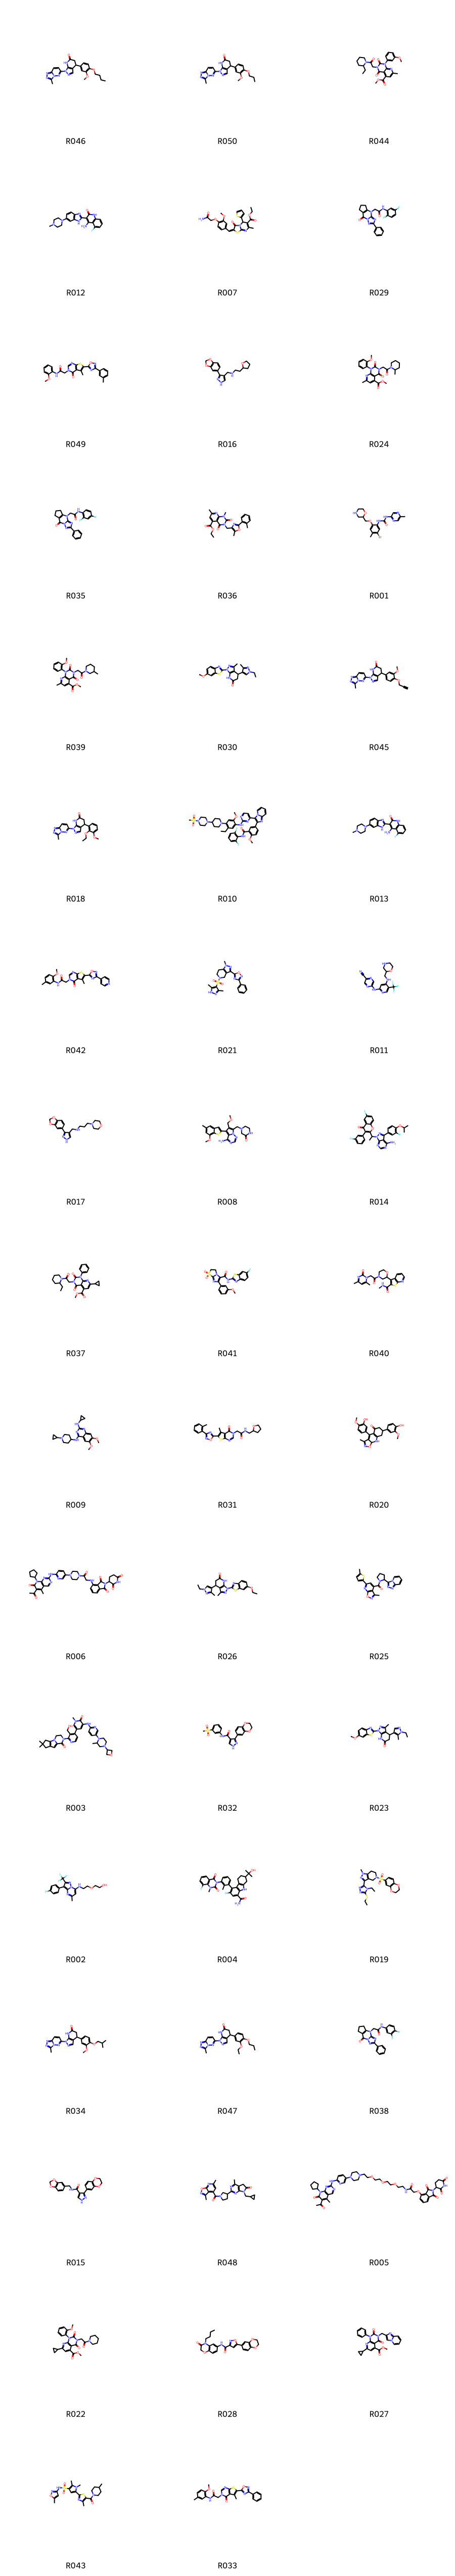

In [7]:
# @title
def cleanup_directory(directory):
    """Clean up all files in a directory"""
    if os.path.exists(directory):
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            except Exception as e:
                print(f'Error deleting {file_path}: {e}')

def convert_pdbqt_to_pdb(pdbqt_file, pdb_file):
    """Convert PDBQT file to PDB format using OpenBabel"""
    cmd = f'obabel -ipdbqt {pdbqt_file} -opdb -O {pdb_file}'
    subprocess.run(cmd, shell=True, capture_output=True)

def visualize_ligands():
    """Convert and visualize all ligands in the ligands directory"""
    # Clean up existing PDB files
    pdb_dir = 'ligands_pdb'
    print("Cleaning up previously generated PDB files...")
    cleanup_directory(pdb_dir)
    os.makedirs(pdb_dir, exist_ok=True)

    # Get all PDBQT files from the ligands directory
    pdbqt_files = glob.glob(os.path.join('ligands', '*.pdbqt'))

    if not pdbqt_files:
        print("No PDBQT files found in the ligands directory. Please upload ligand files first.")
        return

    # Convert and visualize each ligand
    mols = []
    for pdbqt_file in pdbqt_files:
        ligand_name = os.path.basename(pdbqt_file).replace('.pdbqt', '')
        pdb_file = os.path.join(pdb_dir, f'{ligand_name}.pdb')

        # Convert PDBQT to PDB
        convert_pdbqt_to_pdb(pdbqt_file, pdb_file)

        # Load molecule with RDKit
        mol = Chem.MolFromPDBFile(pdb_file)
        if mol is not None:
            # Generate 2D coordinates
            AllChem.Compute2DCoords(mol)
            mols.append(mol)
            print(f"Successfully processed {ligand_name}")
        else:
            print(f"Failed to process {ligand_name}")

    # Visualize all molecules in a grid
    if mols:
        img = Draw.MolsToGridImage(mols,
                                 molsPerRow=3,
                                 subImgSize=(300,300),
                                 legends=[os.path.basename(f).replace('.pdbqt', '') for f in pdbqt_files])
        display(img)
    else:
        print("No molecules were successfully processed")

if __name__ == "__main__":
    visualize_ligands()



---

# **Configuring Docking Parameters**

Before running molecular docking, we need to define key parameters:

- **Binding Site Coordinates**:
  - `center_x`, `center_y`, `center_z`: Specify the center of the binding site on the protein.
  - `size_x`, `size_y`, `size_z`: Define the size of the search space (box) for docking.

- **Docking Settings**:
  - `num_poses`: Number of binding poses to generate for each ligand.

**How to choose these values?**
- The coordinates and box size should be based on the known or predicted binding site of your protein target.
- Adjust these parameters to ensure the search space covers the entire binding pocket.

*Tip: Use visualization tools or literature data to determine appropriate values for your system.*

In [ ]:
# @title
center_x = -2.484 # Modify based on your binding site
center_y = 13.158 # Modify based on your binding site
center_z = -50.769 # Modify based on your binding site
size_x = 22 # Modify based on your binding site
size_y = 30 # Modify based on your binding site
size_z = 48 # Modify based on your binding site
num_poses = 10



---

# **Executing Molecular Docking**

This section performs the core docking simulations:

1. **File Verification**:
   - Check the existence of protein and ligand files.
   - List all available ligand files for docking.

2. **Docking Function**:
   - Define a function to run AutoDock Vina for each ligand.
   - Configure docking parameters and execute the docking command.
   - Capture and process the output for each ligand.

3. **Batch Processing**:
   - Iterate through all ligand files and run docking.
   - Store results for further analysis.

**Why automate docking?**
- Batch processing enables efficient screening of large ligand libraries, saving time and reducing manual errors.

*Note: Docking may take several minutes per ligand, depending on system resources and box size.*

In [12]:
import os
import glob
import subprocess

# === Define paths and docking parameters ===
PROTEIN_PATH = 'protein/protein.pdbqt'
LIGANDS_DIR = 'ligands'
RESULTS_DIR = 'results'

# === Check all required files/directories ===
print("Checking files and directories:")
print(f"Protein file exists: {os.path.exists(PROTEIN_PATH)}")
print(f"Protein file: {PROTEIN_PATH}")
print(f"Ligands directory exists: {os.path.exists(LIGANDS_DIR)}")
print(f"Results directory exists: {os.path.exists(RESULTS_DIR)}")

# List ligand files (sorted for reproducibility)
ligand_files = sorted(glob.glob(os.path.join(LIGANDS_DIR, '*.pdbqt')))
print(f"\nFound {len(ligand_files)} ligand files:")
for lig in ligand_files:
    print(f"- {lig}")

# === Docking Function ===
def run_docking(ligand_file):
    """Run AutoDock Vina docking for a single ligand"""
    ligand_name = os.path.basename(ligand_file).replace('.pdbqt', '')
    output_file = os.path.join(RESULTS_DIR, f'{ligand_name}_out.pdbqt')

    # Argument list style (safe)
    cmd = [
        'vina',
        '--receptor', PROTEIN_PATH,
        '--ligand', ligand_file,
        '--center_x', str(center_x),
        '--center_y', str(center_y),
        '--center_z', str(center_z),
        '--size_x', str(size_x),
        '--size_y', str(size_y),
        '--size_z', str(size_z),
        '--num_modes', str(num_poses),
        '--out', output_file
    ]

    print(f"\nExecuting command for {ligand_name}:")
    print(' '.join(cmd))

    result = subprocess.run(cmd, capture_output=True, text=True)

    print("Command output:")
    print(result.stdout)
    if result.stderr:
        print("Errors:")
        print(result.stderr)

    return output_file, result.stdout

# === Run docking for all ligands ===
results = []
for ligand_file in ligand_files:
    print(f'\nDocking {os.path.basename(ligand_file)}...')
    output_file, vina_output = run_docking(ligand_file)
    results.append({
        'ligand': os.path.basename(ligand_file),
        'output': output_file,
        'vina_output': vina_output
    })


Checking files and directories:
Protein file exists: True
Protein file: protein/protein.pdbqt
Ligands directory exists: True
Results directory exists: True

Found 50 ligand files:
- ligands/R001.pdbqt
- ligands/R002.pdbqt
- ligands/R003.pdbqt
- ligands/R004.pdbqt
- ligands/R005.pdbqt
- ligands/R006.pdbqt
- ligands/R007.pdbqt
- ligands/R008.pdbqt
- ligands/R009.pdbqt
- ligands/R010.pdbqt
- ligands/R011.pdbqt
- ligands/R012.pdbqt
- ligands/R013.pdbqt
- ligands/R014.pdbqt
- ligands/R015.pdbqt
- ligands/R016.pdbqt
- ligands/R017.pdbqt
- ligands/R018.pdbqt
- ligands/R019.pdbqt
- ligands/R020.pdbqt
- ligands/R021.pdbqt
- ligands/R022.pdbqt
- ligands/R023.pdbqt
- ligands/R024.pdbqt
- ligands/R025.pdbqt
- ligands/R026.pdbqt
- ligands/R027.pdbqt
- ligands/R028.pdbqt
- ligands/R029.pdbqt
- ligands/R030.pdbqt
- ligands/R031.pdbqt
- ligands/R032.pdbqt
- ligands/R033.pdbqt
- ligands/R034.pdbqt
- ligands/R035.pdbqt
- ligands/R036.pdbqt
- ligands/R037.pdbqt
- ligands/R038.pdbqt
- ligands/R039.pdbqt
-



---

# **Analyzing Docking Results**

After docking, we need to process and analyze the results:

1. **Output Organization**:
   - Create directories for best poses and all poses.
   - Extract binding energies from Vina output.
   - Separate the best pose from all generated poses.

2. **Data Processing**:
   - Parse Vina output to extract binding energies.
   - Create a summary of results in CSV format.
   - Organize output files for easy access and downstream analysis.

3. **Results Summary**:
   - Generate a comprehensive CSV file with all docking results.
   - Include binding energies and pose information for each ligand.

**Why analyze results?**
- Identifying ligands with the best binding energies is crucial for prioritizing compounds for further study.

*Tip: Use the CSV summary for quick comparison and visualization of docking results.*

In [13]:
# @title
# Define a single output directory
OUTPUT_DIR = 'docking_outputs'
BEST_POSES_DIR = os.path.join(OUTPUT_DIR, 'best_poses')
ALL_POSES_DIR = os.path.join(OUTPUT_DIR, 'all_poses')
os.makedirs(BEST_POSES_DIR, exist_ok=True)
os.makedirs(ALL_POSES_DIR, exist_ok=True)

# Function to parse Vina output and extract binding energies
def parse_vina_output(vina_output):
    """Parse Vina output to extract binding energies from the result table."""
    energies = []
    for line in vina_output.split('\n'):
        # Match lines that start with a mode number and an affinity value
        match = re.match(r'^\s*\d+\s+(-?\d+\.\d+)', line)
        if match:
            try:
                energies.append(float(match.group(1)))
            except ValueError:
                continue
    return energies

# Function to extract the best pose (first MODEL) from a Vina PDBQT output file
def extract_best_pose(pdbqt_file, output_file):
    with open(pdbqt_file, 'r') as infile, open(output_file, 'w') as outfile:
        write = False
        for line in infile:
            if line.startswith('MODEL 1') or line.startswith('MODEL'):
                write = True
            if write:
                outfile.write(line)
            if line.startswith('ENDMDL') and write:
                break

# Copy all output files and extract best poses
for result in results:
    vina_out = result['output']
    ligand_name = os.path.basename(vina_out)
    # Copy all poses
    shutil.copy(vina_out, os.path.join(ALL_POSES_DIR, ligand_name))
    # Extract and save best pose
    best_pose_name = ligand_name.replace('_out.pdbqt', '_best.pdbqt')
    best_pose_path = os.path.join(BEST_POSES_DIR, best_pose_name)
    extract_best_pose(vina_out, best_pose_path)

# Prepare the CSV summary
results_df = pd.DataFrame(results)
results_df['binding_energies'] = results_df['vina_output'].apply(parse_vina_output)
results_df['best_energy'] = results_df['binding_energies'].apply(lambda x: min(x) if x else None)
csv_df = results_df[['ligand', 'output', 'binding_energies', 'best_energy']]
csv_path = os.path.join(OUTPUT_DIR, 'docking_results.csv')
csv_df.to_csv(csv_path, index=False)



---

# **Downloading Results**

To facilitate further analysis and sharing, this section prepares and downloads the docking results:

1. **Results Packaging**:
   - Create a zip archive containing all output files, including best poses, all poses, and analysis results.

2. **File Downloads**:
   - Provide the complete results package as a downloadable zip file.
   - Offer direct download of the CSV summary for quick access.

**Why package results?**
- Packaging results ensures all relevant files are easily accessible and transferable for downstream analysis or collaboration.

*Tip: Keep a backup of your results for reproducibility and future reference.*



In [14]:
# @title
# Zip the entire output directory
zip_filename = 'docking_outputs.zip'
shutil.make_archive('docking_outputs', 'zip', OUTPUT_DIR)
print(f"\nZipped output directory to: {zip_filename}")

# Confirm CSV export
if os.path.exists(csv_path):
    print(f"\nCSV results saved to: {csv_path}")
else:
    print("\nCSV file not found.")


Zipped output directory to: docking_outputs.zip

CSV results saved to: docking_outputs/docking_results.csv




---

# **PLIP Docking Analysis**

PLIP (Protein-Ligand Interaction Profiler) is a powerful tool for analyzing protein-ligand interactions. In this section, we will:

1. **Install PyMOL**:
   - PyMOL is required for visualizing and analyzing protein-ligand complexes.
   - The installation process may take some time and requires a runtime restart.

2. **Create Complexes**:
   - Convert docking results into protein-ligand complexes.
   - Prepare files for PLIP analysis.

**Why use PLIP?**
- PLIP provides detailed insights into protein-ligand interactions, including hydrogen bonds, hydrophobic contacts, and other interaction types.
- This analysis helps validate docking results and understand binding mechanisms.

*Note: PyMOL installation is a one-time setup that may require runtime restart.*

In [15]:
#@title PyMol installation

# Source: https://github.com/MooersLab/colabOpenSourcePyMOLpySnips

try:
  from pymol import cmd
  print("PyMOL already installed.")
except:
  from IPython.utils import io
  import os,time

  start = time.time()
  print("Installing PyMol takes some time.")

  # do not display all the output that installation generates
  with io.capture_output() as captured:

    # install condacolab
    !pip install -q condacolab
    import condacolab
    condacolab.install()

    # January 2024 there seems to be a problem between colab and cudatoolkit=12.2
    # https://stackoverflow.com/questions/77726543/trouble-installing-isce2-in-colab-cudatoolkit-12-2-is-missing-from-the-target
    # sed command below solves problem
    !sed -i '/cudatoolkit/d' /usr/local/conda-meta/pinned
    !conda create -n pymol310 python=3.10

    # Main command: !conda install -c conda-forge pymol-open-source
    !mamba install pymol-open-source

  # test whether install was successful
  ok = ""
  try: from pymol import cmd
  except: ok = "not "
  print("It took %d seconds.\nPyMol import %sok."%(time.time()-start, ok))

PyMOL already installed.


In [16]:
#@title Create complexes

import os
import subprocess
import glob
from pathlib import Path
import tempfile
import pymol
from pymol import cmd
import sys

def convert_pdbqt_to_sdf(pdbqt_file, sdf_file):
    """Convert PDBQT file to SDF format using OpenBabel"""
    cmd = f'obabel -ipdbqt {pdbqt_file} -osdf -O {sdf_file}'
    subprocess.run(cmd, shell=True, check=True)

def convert_pdbqt_to_pdb(pdbqt_file, pdb_file):
    """Convert PDBQT file to PDB format using OpenBabel"""
    cmd = f'obabel -ipdbqt {pdbqt_file} -opdb -O {pdb_file}'
    subprocess.run(cmd, shell=True, check=True)

def split_sdf_file(sdf_file, output_prefix):
    """Splits a multi-pose SDF file into individual SDF files."""
    sdf_content = []
    current_sdf = []
    pose_count = 0

    with open(sdf_file, 'r') as f:
        for line in f:
            current_sdf.append(line)
            if line.strip() == '$$$$':
                sdf_content.append(''.join(current_sdf))
                current_sdf = []
                pose_count += 1

    if current_sdf:
        sdf_content.append(''.join(current_sdf))
        pose_count += 1

    sdf_files = []
    for i, sdf_data in enumerate(sdf_content, 1):
        output_sdf = f"{output_prefix}{i}.sdf"
        with open(output_sdf, 'w') as f:
            f.write(sdf_data)
        sdf_files.append(output_sdf)

    print(f"Split {sdf_file} into {pose_count} individual SDF files")
    return sdf_files, pose_count

def create_complexes():
    """Creates protein-ligand complexes using PyMOL"""

    # Create output directory and clean up existing files
    if os.path.exists('plip_complexes'):
        # Remove all existing files in plip_complexes
        for file in os.listdir('plip_complexes'):
            file_path = os.path.join('plip_complexes', file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            except Exception as e:
                print(f'Error deleting {file_path}: {e}')
    else:
        os.makedirs('plip_complexes')

    # Get all ligand files from best poses
    ligand_files = glob.glob('docking_outputs/best_poses/*.pdbqt')

    # Initialize PyMOL
    try:
        cmd.get_version()
        print("PyMOL session already active.")
    except AttributeError:
        print("Launching PyMOL backend...")
        pymol.finish_launching(['pymol', '-qc'])

    # Convert protein to PDB
    protein_pdbqt = 'protein/protein.pdbqt'
    protein_pdb = 'plip_complexes/protein.pdb'
    convert_pdbqt_to_pdb(protein_pdbqt, protein_pdb)

    # Load protein
    print(f"Loading protein '{protein_pdb}'...")
    cmd.load(protein_pdb, 'receptor')

    # Process each ligand
    for ligand_pdbqt in ligand_files:
        ligand_name = Path(ligand_pdbqt).stem.replace('_best', '')
        print(f"\nProcessing {ligand_name}...")

        # Create temporary files for conversion
        with tempfile.NamedTemporaryFile(suffix='.sdf', delete=False) as temp_sdf:
            # Convert ligand to SDF
            convert_pdbqt_to_sdf(ligand_pdbqt, temp_sdf.name)

            # Split SDF into individual poses
            sdf_files, num_poses = split_sdf_file(temp_sdf.name, f'plip_complexes/{ligand_name}')

            # Process each pose
            for i, sdf_file in enumerate(sdf_files, 1):
                pose_num = i
                complex_name = f"temp_complex_{pose_num}"
                output_pdb_file = f"plip_complexes/{ligand_name}.pdb"

                print(f"  Processing Pose {pose_num}/{num_poses}:")

                # Load ligand
                print(f"  Loading ligand '{sdf_file}'...")
                cmd.load(sdf_file, 'ligand')

                # Check if ligand loaded properly
                atom_count = cmd.count_atoms('ligand')
                if atom_count == 0:
                    print(f"  Error: No atoms found in ligand pose {pose_num}. Skipping...")
                    cmd.delete('ligand')
                    continue

                # Create complex
                print(f"  Creating complex...")
                cmd.create(complex_name, 'receptor or ligand')

                # Save complex
                print(f"  Saving complex to '{output_pdb_file}'...")
                cmd.save(output_pdb_file, complex_name)

                # Clean up
                cmd.delete(complex_name)
                cmd.delete('ligand')

            # Clean up temporary files
            os.unlink(temp_sdf.name)
            for sdf_file in sdf_files:
                os.unlink(sdf_file)

    # Clean up protein
    cmd.delete('receptor')

    # Remove the temporary protein.pdb file
    try:
        os.remove(protein_pdb)
        print(f"Removed temporary protein file: {protein_pdb}")
    except Exception as e:
        print(f"Error removing protein file: {e}")

    print("\nComplex creation completed successfully!")
    print(f"Complexes saved in 'plip_complexes' directory")

if __name__ == "__main__":
    create_complexes()

PyMOL session already active.
Loading protein 'plip_complexes/protein.pdb'...

Processing R035...


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is protein/protein.pdbqt)

1 molecule converted
1 molecule converted


Split /tmp/tmpudklx9ep.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0351.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R035.pdb'...

Processing R039...
Split /tmp/tmpej_zj_s0.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0391.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R039.pdb'...

Processing R024...
Split /tmp/tmp4n0oj03u.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0241.sdf'...
  Creating complex...


1 molecule converted
1 molecule converted
1 molecule converted


  Saving complex to 'plip_complexes/R024.pdb'...

Processing R025...
Split /tmp/tmp8a33rus_.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0251.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R025.pdb'...

Processing R006...
Split /tmp/tmp54xf41nc.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0061.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R006.pdb'...


1 molecule converted
1 molecule converted



Processing R005...
Split /tmp/tmpngazsu3b.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0051.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R005.pdb'...

Processing R004...


1 molecule converted
1 molecule converted


Split /tmp/tmp5snl1gd9.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0041.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R004.pdb'...

Processing R036...
Split /tmp/tmpeetvwj7c.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0361.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R036.pdb'...

Processing R028...


1 molecule converted
1 molecule converted


Split /tmp/tmph95knv3j.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0281.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R028.pdb'...

Processing R011...
Split /tmp/tmpprxb123t.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0111.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R011.pdb'...

Processing R017...


1 molecule converted
1 molecule converted


Split /tmp/tmpeafe6mjp.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0171.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R017.pdb'...

Processing R044...
Split /tmp/tmptrh3ev_y.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0441.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R044.pdb'...

Processing R022...


1 molecule converted
1 molecule converted


Split /tmp/tmpz_druz25.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0221.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R022.pdb'...

Processing R046...
Split /tmp/tmpfgwj2dsg.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0461.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R046.pdb'...

Processing R021...


1 molecule converted
1 molecule converted


Split /tmp/tmpsalcjjbm.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0211.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R021.pdb'...

Processing R034...
Split /tmp/tmpjvh_r8hf.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0341.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R034.pdb'...

Processing R013...


1 molecule converted
1 molecule converted


Split /tmp/tmpkjaf31ul.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0131.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R013.pdb'...

Processing R031...
Split /tmp/tmp6kngl9uo.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0311.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R031.pdb'...

Processing R007...


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is m7)

1 molecule converted
1 molecule converted


Split /tmp/tmpkh3xpgx6.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0071.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R007.pdb'...

Processing R047...
Split /tmp/tmpw8vsmn4i.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0471.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R047.pdb'...

Processing R030...


1 molecule converted
1 molecule converted


Split /tmp/tmpqvp83_h9.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0301.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R030.pdb'...

Processing R009...
Split /tmp/tmp7uamvp54.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0091.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R009.pdb'...

Processing R027...


1 molecule converted
1 molecule converted


Split /tmp/tmpqlxzsebw.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0271.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R027.pdb'...

Processing R048...
Split /tmp/tmpq1tpkkaz.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0481.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R048.pdb'...

Processing R002...


1 molecule converted
1 molecule converted


Split /tmp/tmpils19jml.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0021.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R002.pdb'...

Processing R001...
Split /tmp/tmpnfnw7ipz.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0011.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R001.pdb'...

Processing R029...


1 molecule converted
1 molecule converted


Split /tmp/tmpmiyvgqju.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0291.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R029.pdb'...

Processing R016...
Split /tmp/tmptyk0rk2v.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0161.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R016.pdb'...

Processing R014...


1 molecule converted
1 molecule converted


Split /tmp/tmp8t8_f4rl.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0141.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R014.pdb'...

Processing R050...
Split /tmp/tmpyqjhyzkt.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0501.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R050.pdb'...

Processing R038...


1 molecule converted
1 molecule converted


Split /tmp/tmpwcmlh145.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0381.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R038.pdb'...

Processing R045...
Split /tmp/tmpl43p6cbt.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0451.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R045.pdb'...

Processing R020...


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is m20)

1 molecule converted
1 molecule converted


Split /tmp/tmpbhaob703.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0201.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R020.pdb'...

Processing R023...
Split /tmp/tmplc85i5p0.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0231.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R023.pdb'...

Processing R043...


1 molecule converted
1 molecule converted


Split /tmp/tmpjkeo8w54.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0431.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R043.pdb'...

Processing R018...
Split /tmp/tmpbjpwifzb.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0181.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R018.pdb'...

Processing R041...


1 molecule converted
1 molecule converted


Split /tmp/tmpie5tose6.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0411.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R041.pdb'...

Processing R019...
Split /tmp/tmp15utjuer.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0191.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R019.pdb'...

Processing R003...


1 molecule converted
1 molecule converted


Split /tmp/tmpa2ay71u9.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0031.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R003.pdb'...

Processing R008...
Split /tmp/tmpeh76vw7j.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0081.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R008.pdb'...

Processing R040...


1 molecule converted
1 molecule converted


Split /tmp/tmpos104lri.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0401.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R040.pdb'...

Processing R037...
Split /tmp/tmpagaznzzj.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0371.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R037.pdb'...

Processing R033...


1 molecule converted
1 molecule converted


Split /tmp/tmps7_elrth.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0331.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R033.pdb'...

Processing R012...
Split /tmp/tmpyz0lbpu9.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0121.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R012.pdb'...

Processing R015...


1 molecule converted
1 molecule converted


Split /tmp/tmppdv9nz1d.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0151.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R015.pdb'...

Processing R049...
Split /tmp/tmp_byqvraj.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0491.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R049.pdb'...

Processing R032...


1 molecule converted
1 molecule converted


Split /tmp/tmpbfwas_zb.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0321.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R032.pdb'...

Processing R042...
Split /tmp/tmpqil_buzr.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0421.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R042.pdb'...

Processing R026...
Split /tmp/tmp_1wwone9.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0261.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R026.pdb'...

Processing R010...
Split /tmp/tmpsmw_d15o.sdf into 1 individual SDF files
  Processing Pose 1/1:
  Loading ligand 'plip_complexes/R0101.sdf'...
  Creating complex...
  Saving complex to 'plip_complexes/R010.pdb'...
Removed temporary protein file: plip_complexes/protein.pdb

Complex creation completed successfully!
Complexes saved in 'plip_complexes' directory


1 molecule converted
1 molecule converted


# Processing PDB Files with PLIP

In this section, we will:

1. **Check PDB Files**:
   - Verify the existence of PDB files in the specified directory.
   - List all available PDB files for analysis.

2. **Process PDB Files**:
   - Run PLIP analysis on each PDB file.
   - Generate detailed reports and visualizations.
   - Organize results in a structured directory.

**What to expect from PLIP analysis?**
- Detailed reports on protein-ligand interactions.
- Visualizations of binding sites and interaction types.
- Comprehensive summaries for each complex.

*Note: Processing time depends on the number and size of PDB files.*

PyMOL already installed.
Cloning into 'plip'...
remote: Enumerating objects: 3173, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 3173 (delta 165), reused 128 (delta 116), pack-reused 2963 (from 2)
Receiving objects: 100% (3173/3173), 9.20 MiB | 8.26 MiB/s, done.
Resolving deltas: 100% (1991/1991), done.
Obtaining file:///home/ai_ml/user2/AI-ML-Workshop/ML/plip
  Preparing metadata (setup.py) ... one
  Attempting uninstall: plip
    Found existing installation: plip 2.4.0
    Uninstalling plip-2.4.0:
      Successfully uninstalled plip-2.4.0
  DEPRECATION: Legacy editable install of plip==2.4.0 from file:///home/ai_ml/user2/AI-ML-Workshop/ML/plip (setup.py develop) is deprecated. pip 25.3 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_

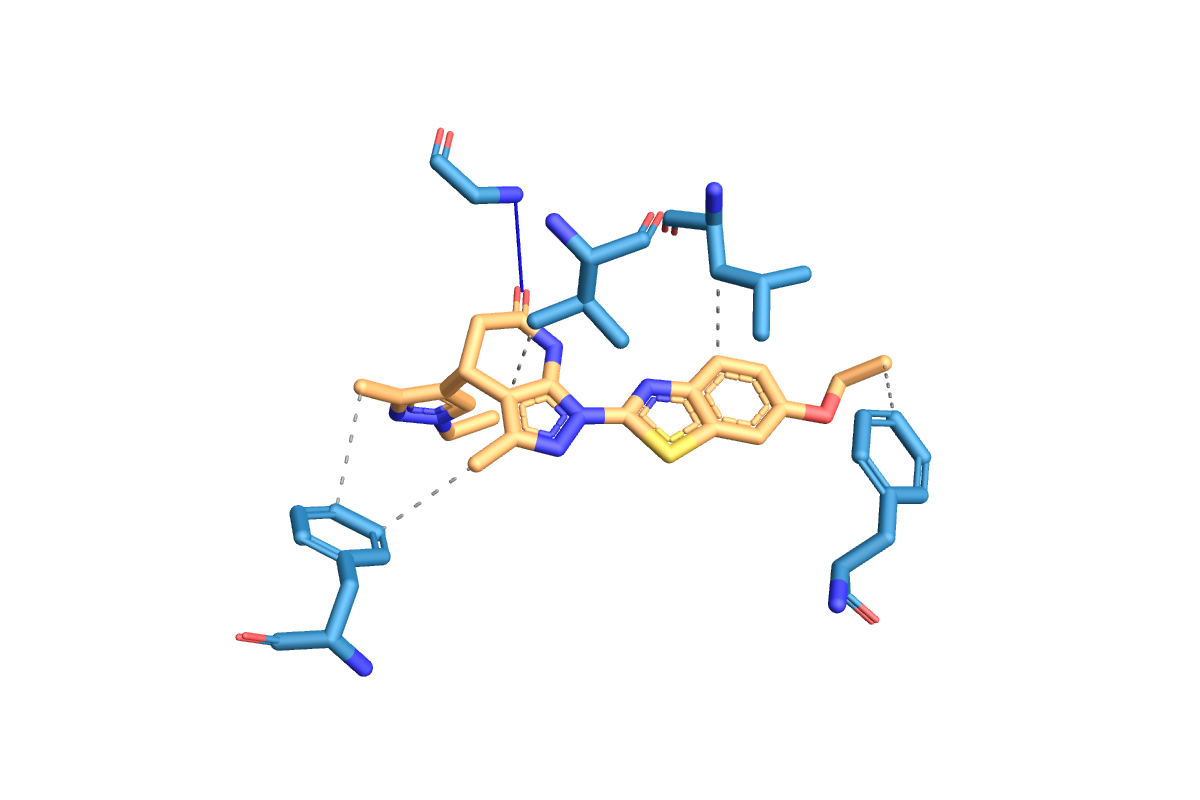


Binding sites for R020:


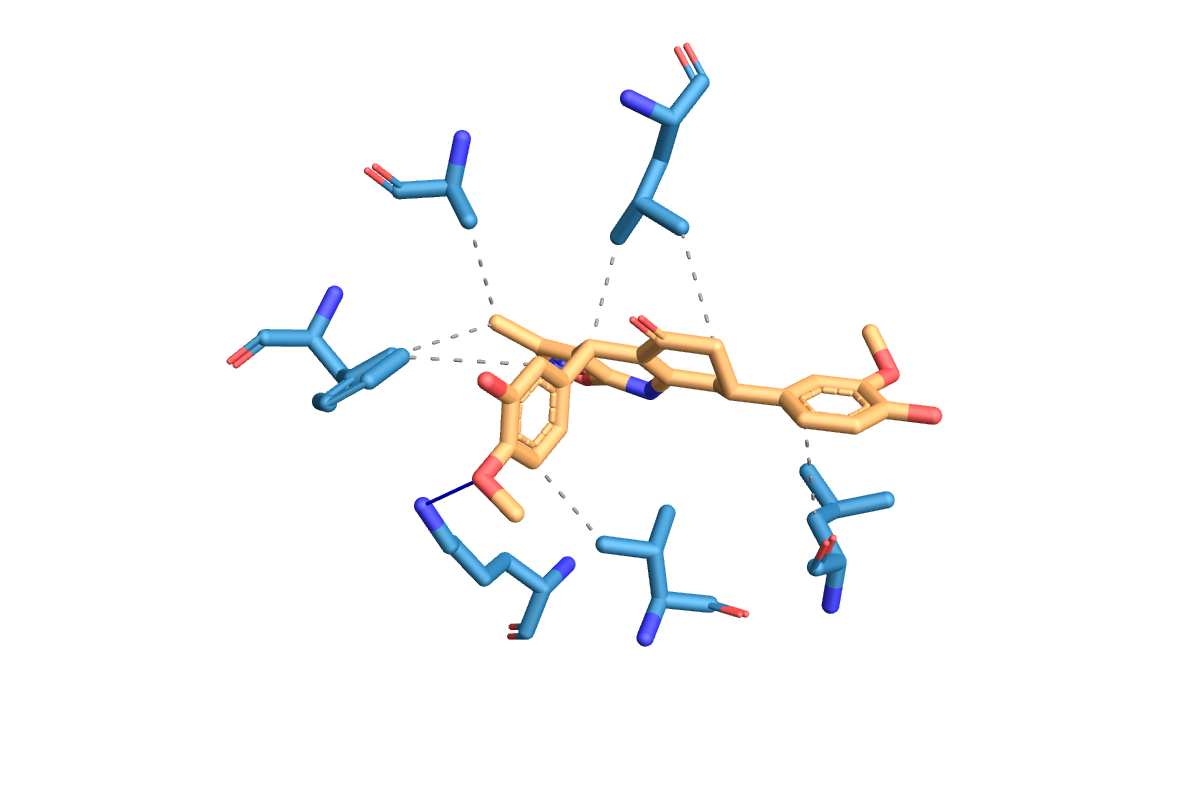


Binding sites for R041:


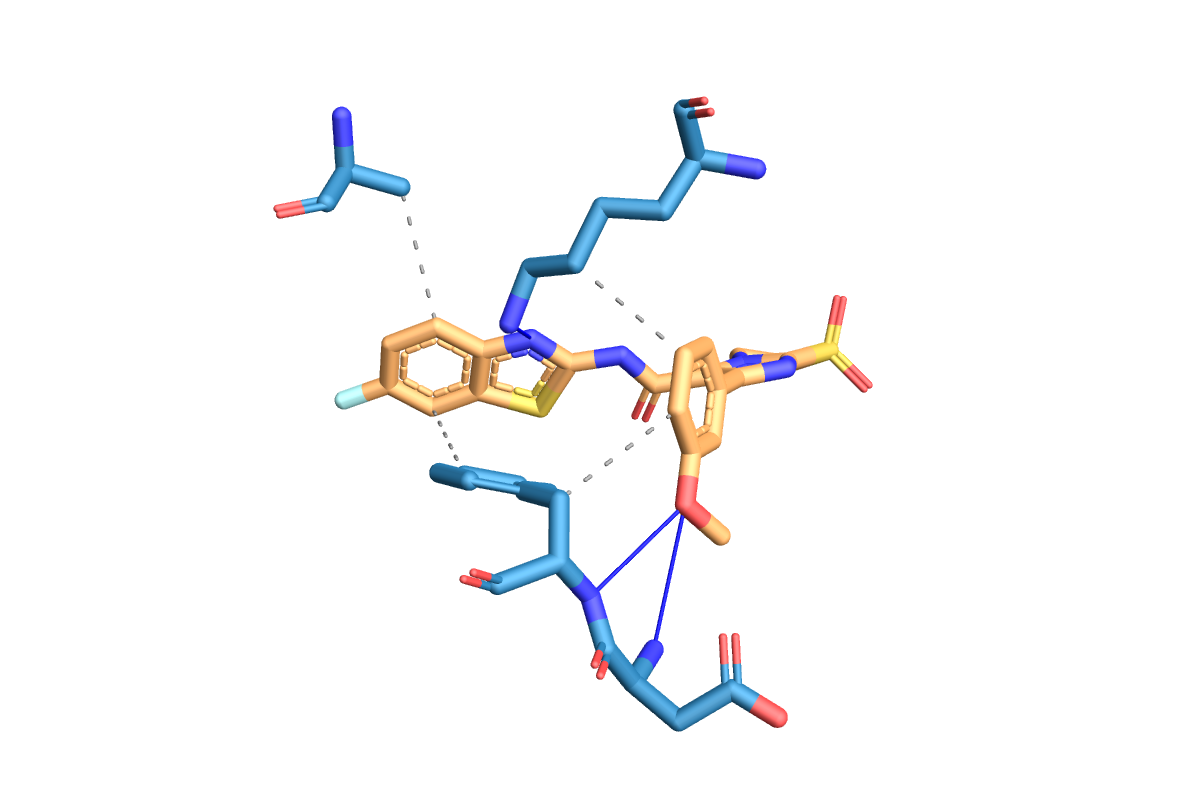


Binding sites for R032:


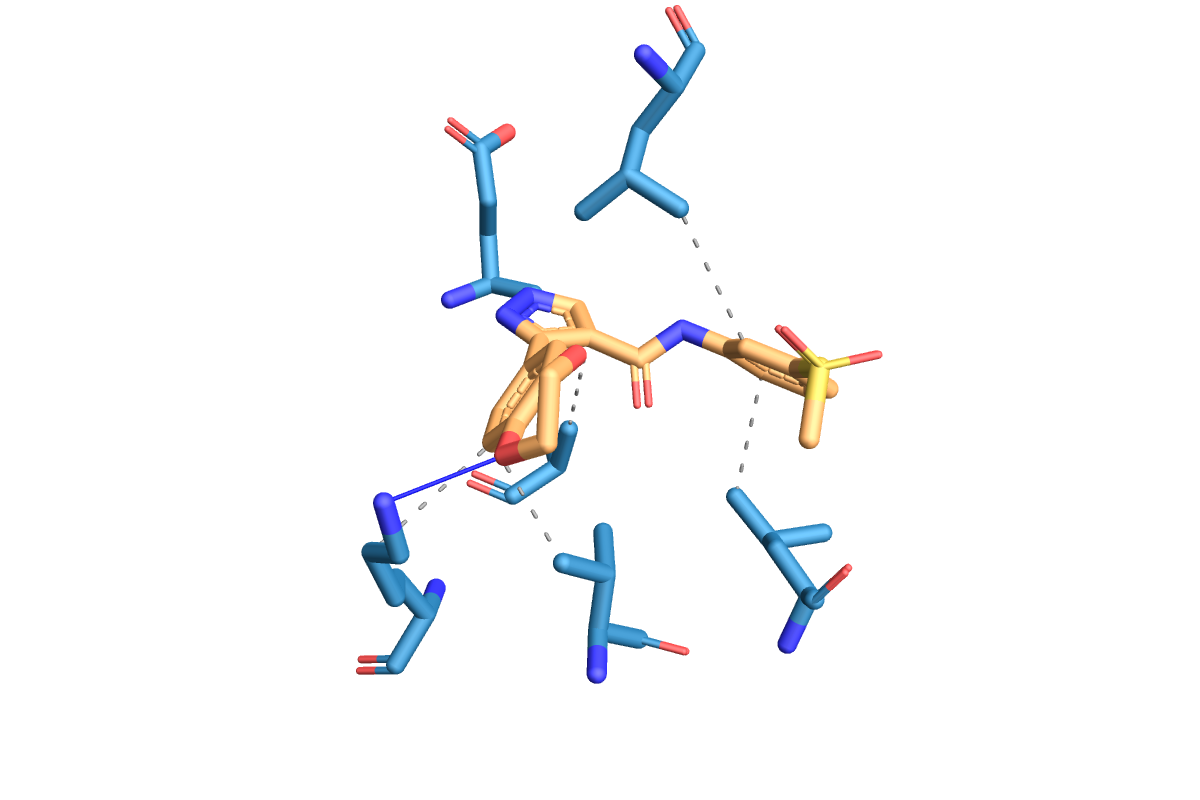


Binding sites for R037:


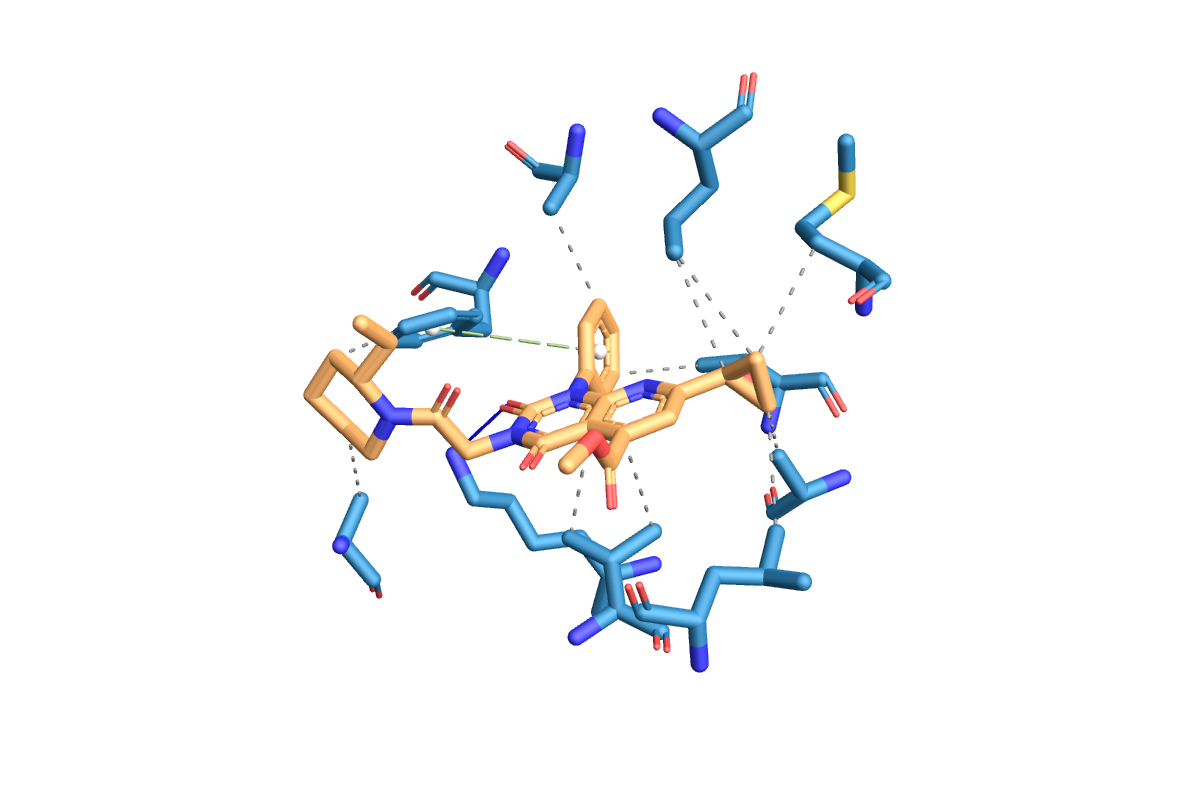


Binding sites for R015:


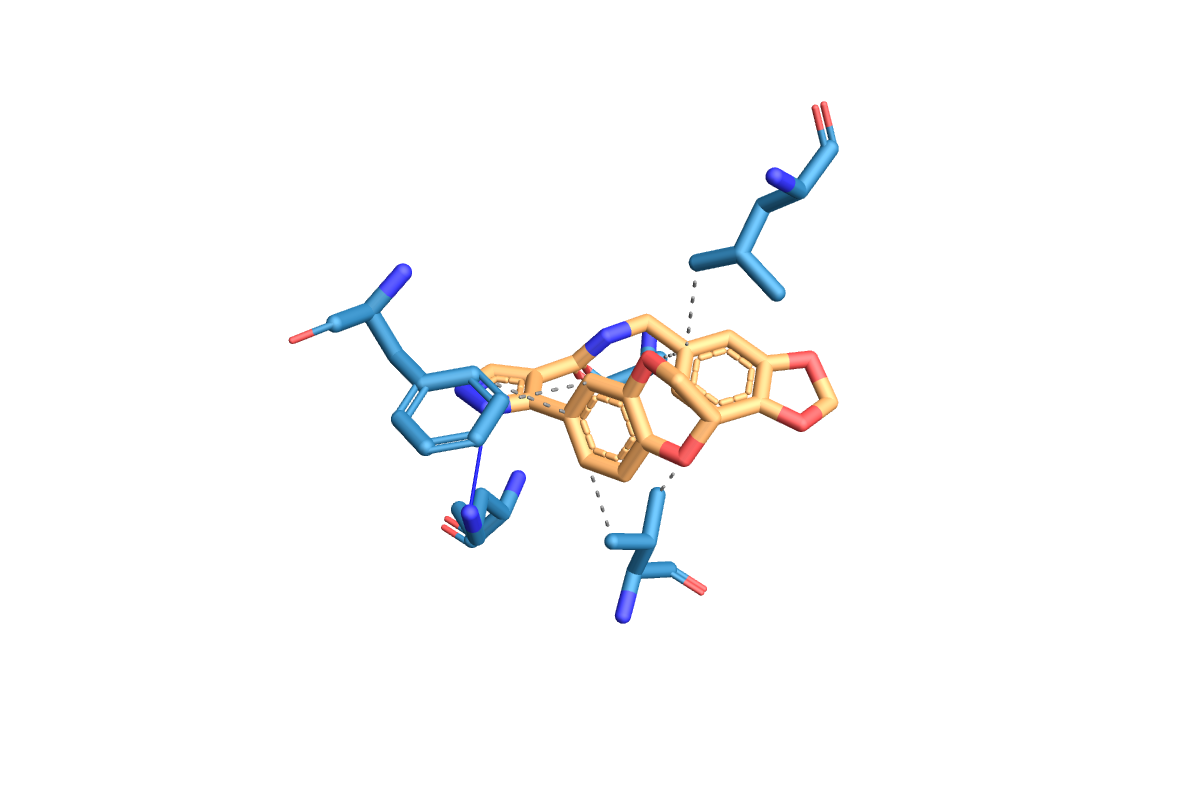


Binding sites for R009:


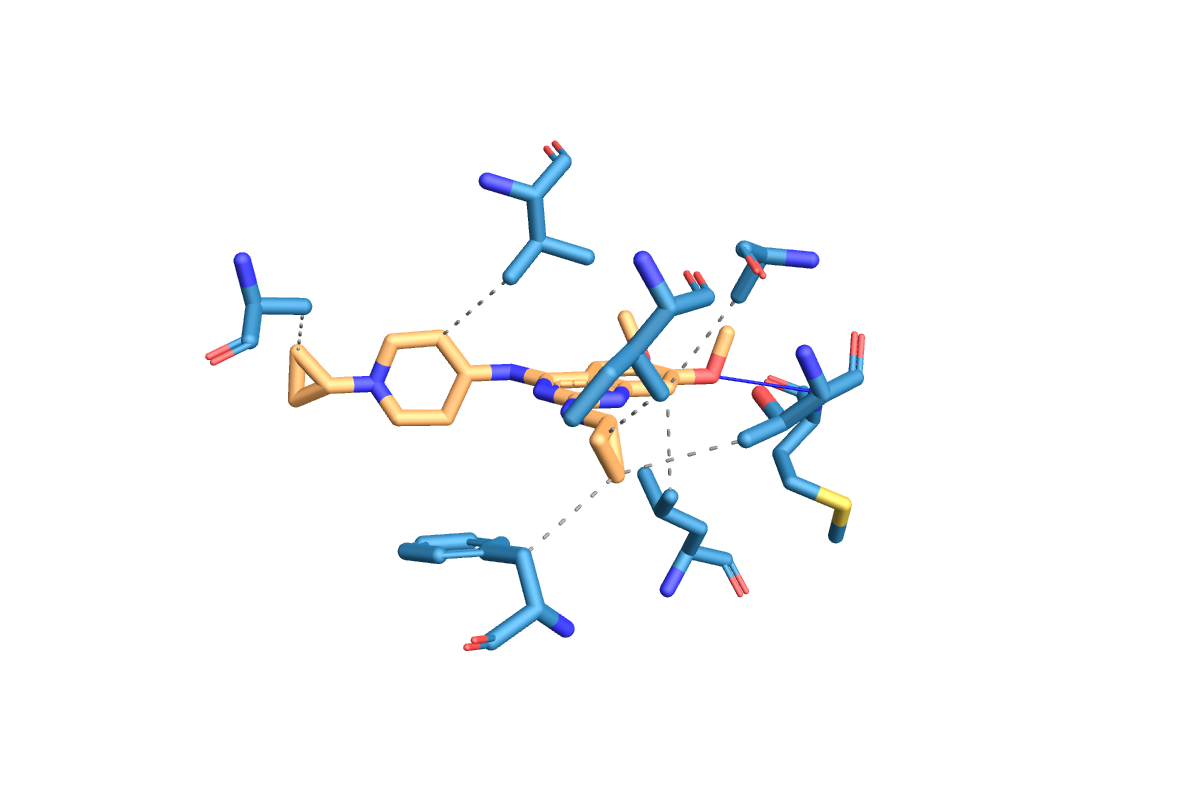


Binding sites for R002:


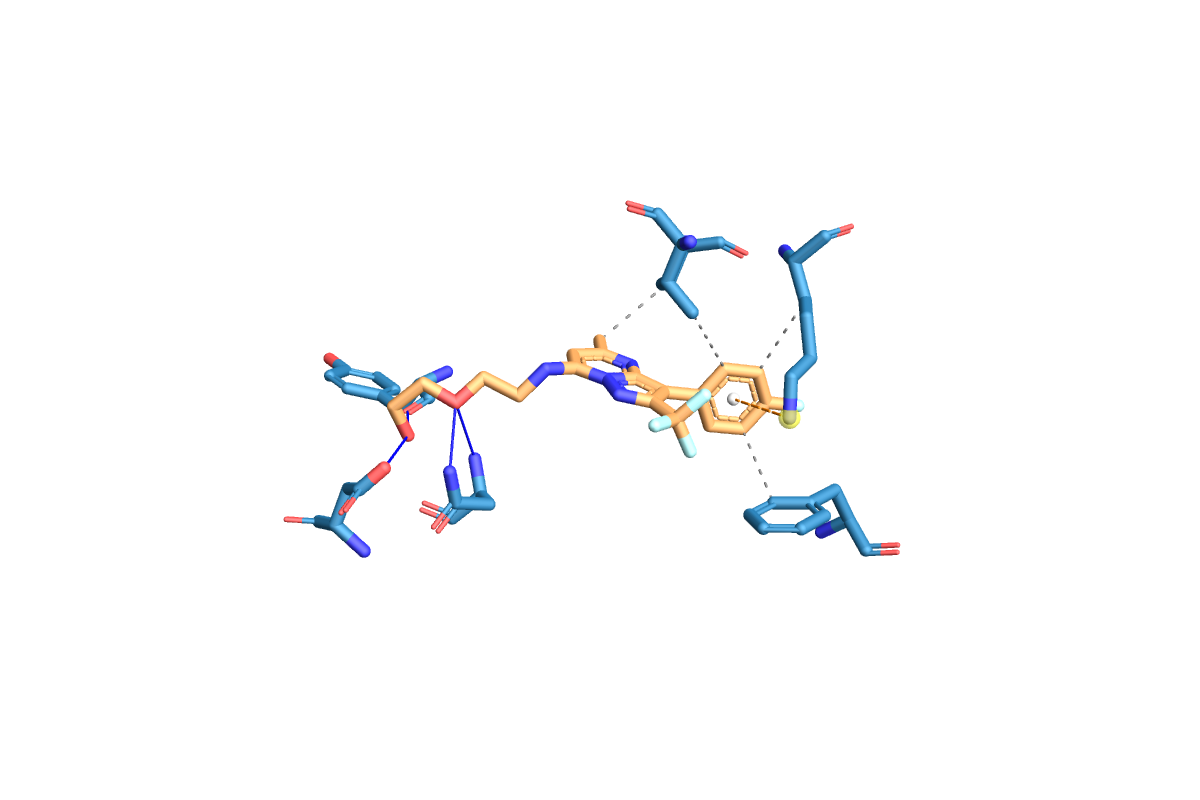


Binding sites for R029:


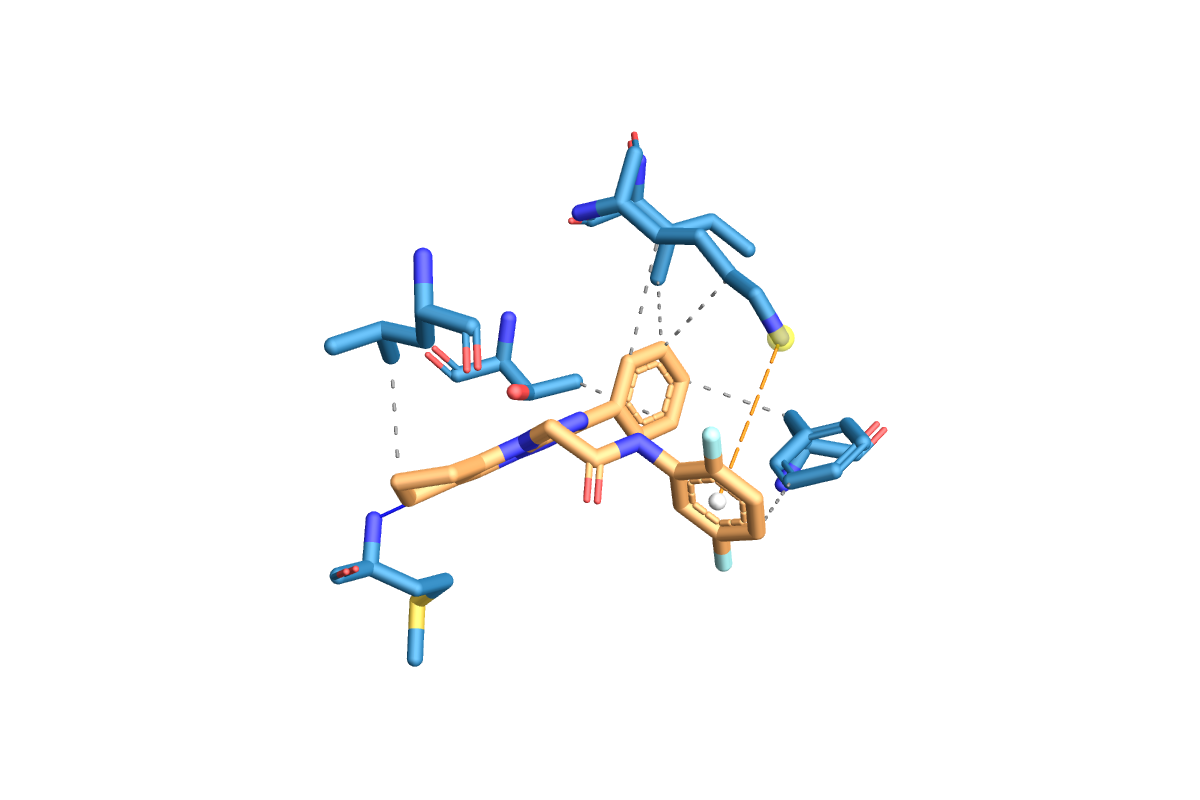


Binding sites for R004:


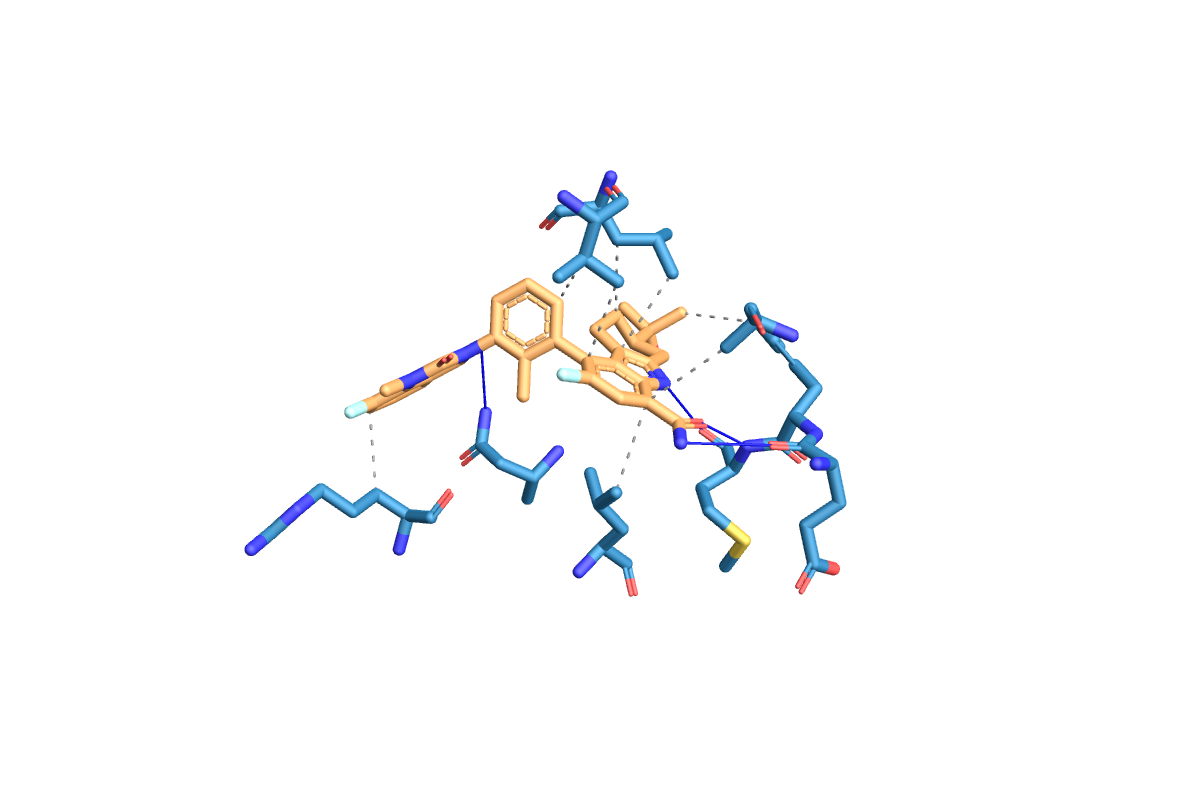


Binding sites for R046:


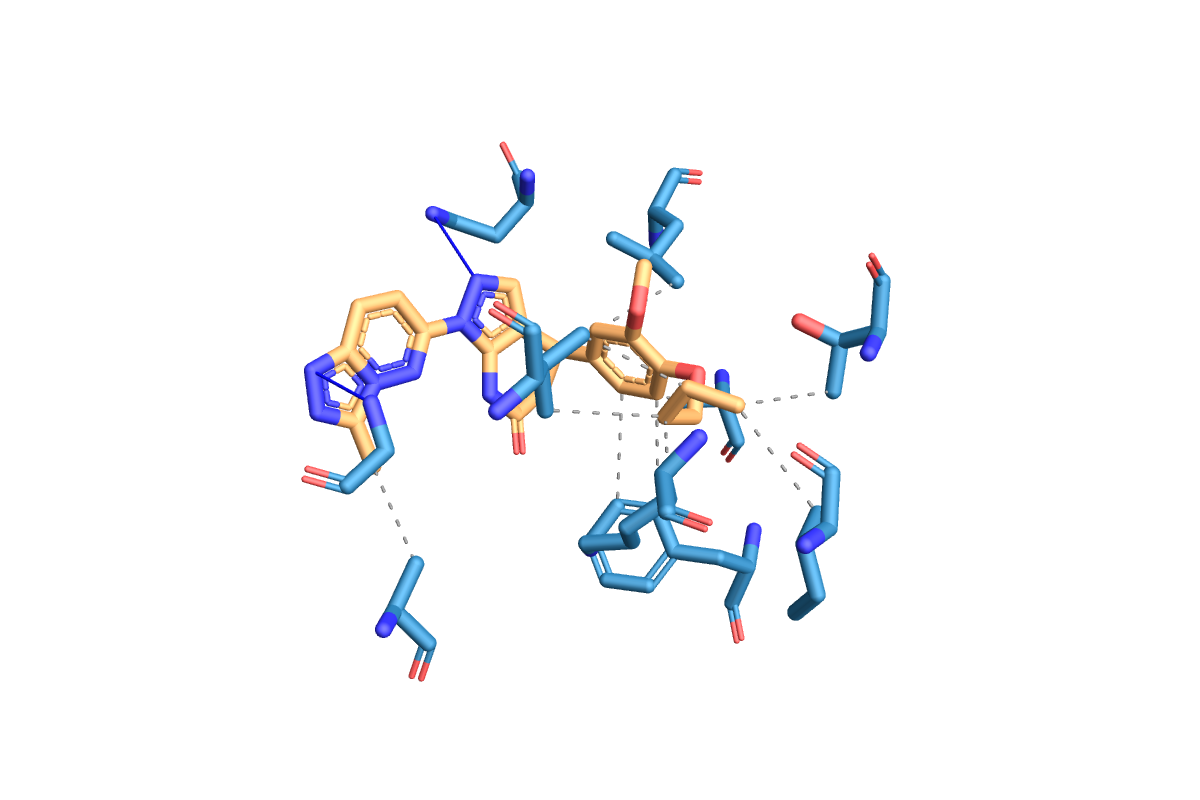


Binding sites for R006:


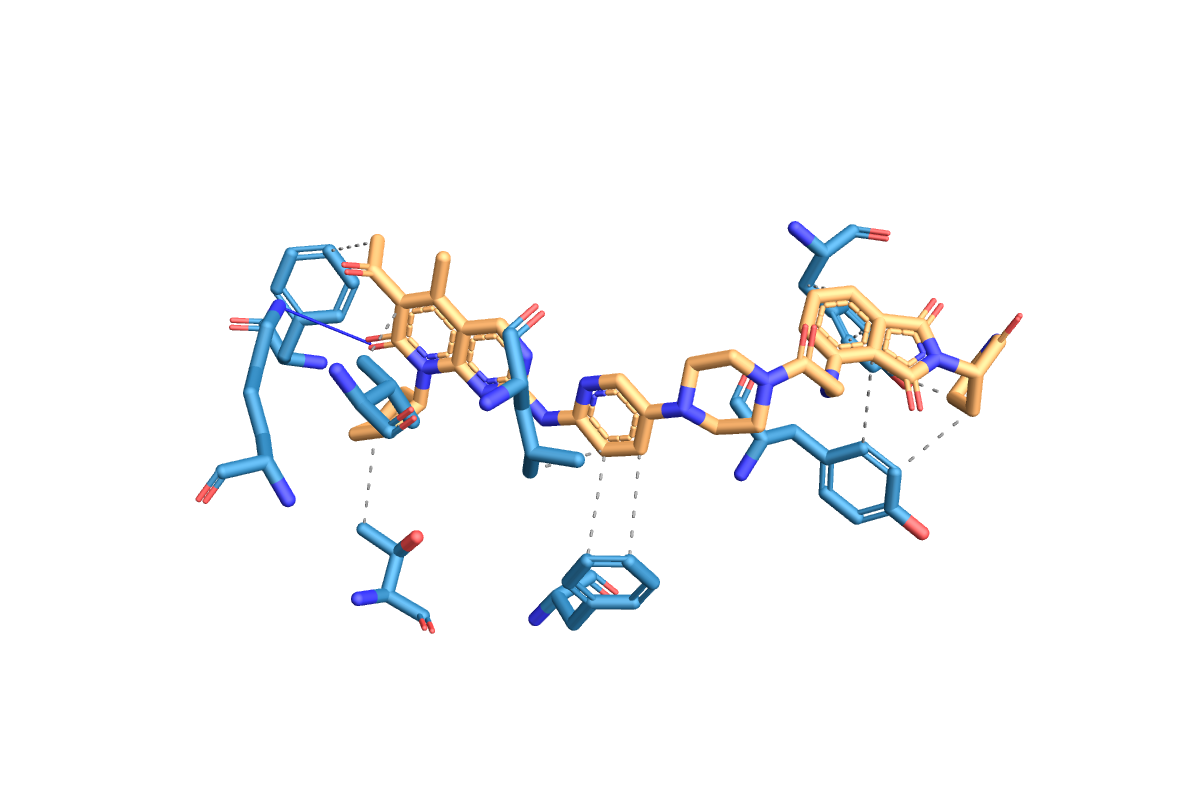


Binding sites for R040:


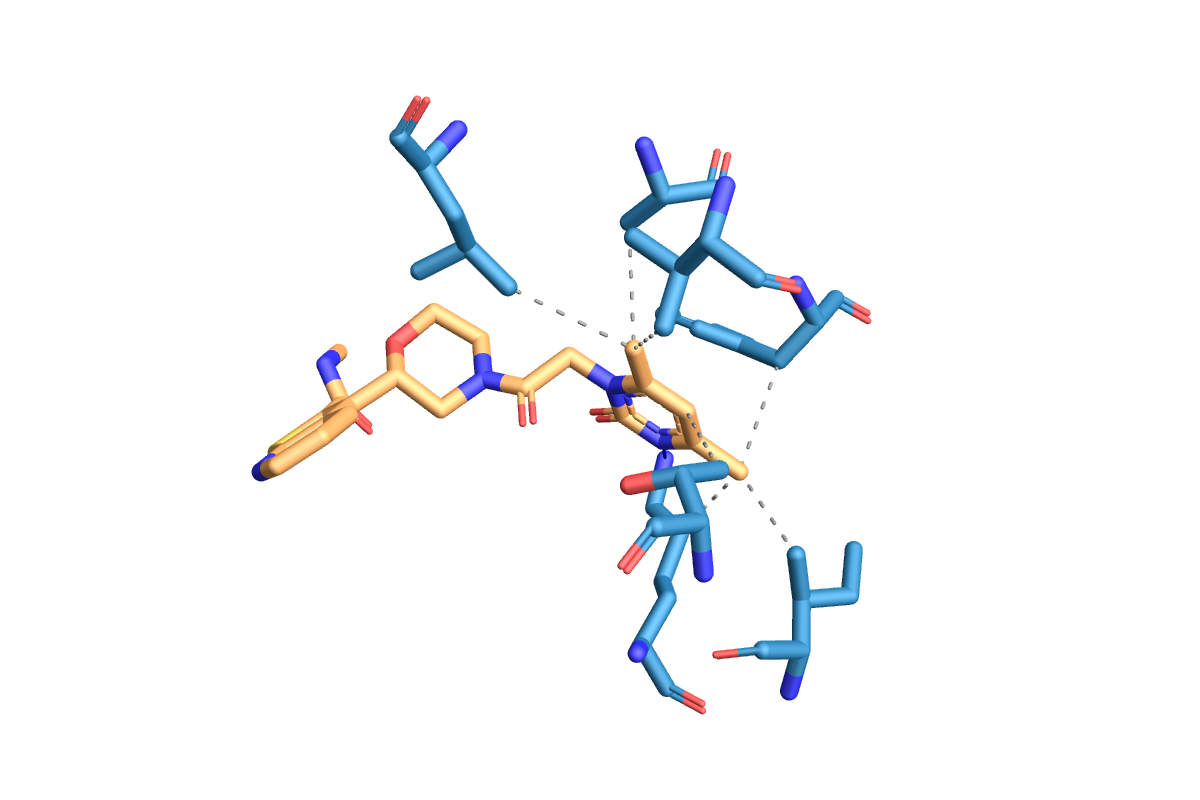


Binding sites for R019:


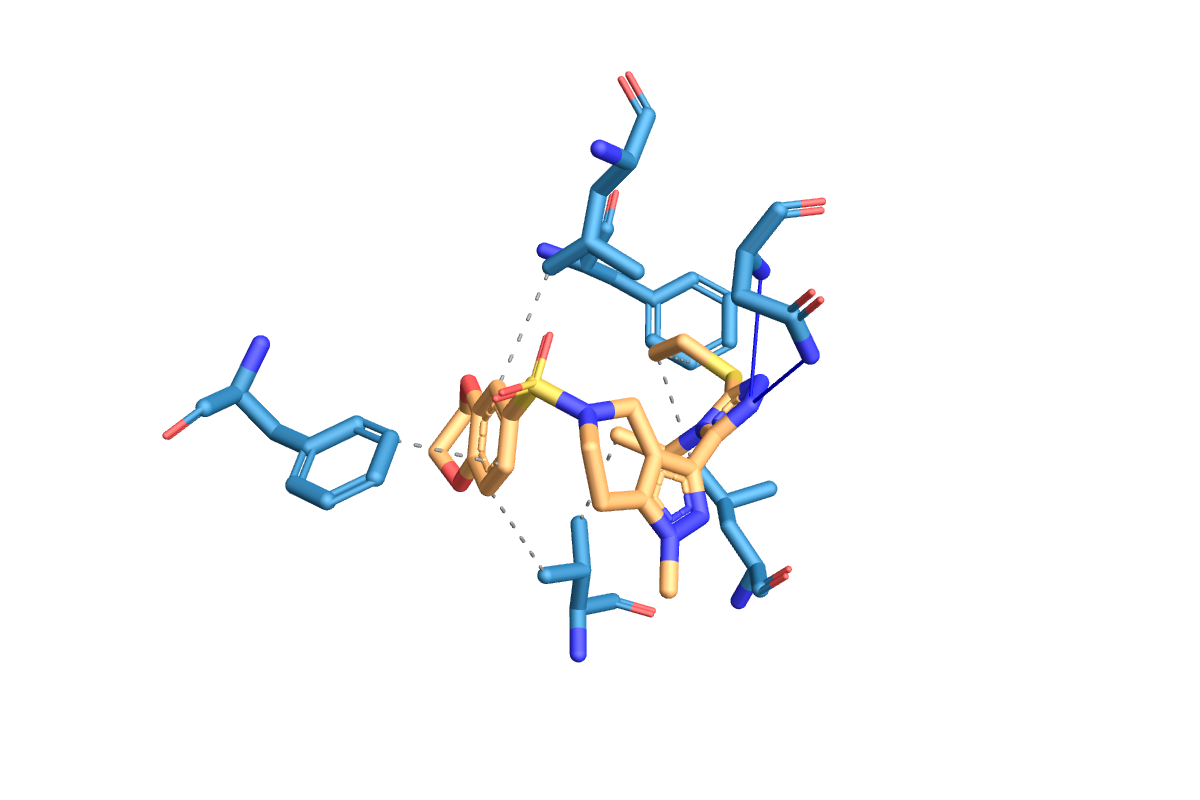


Binding sites for R043:


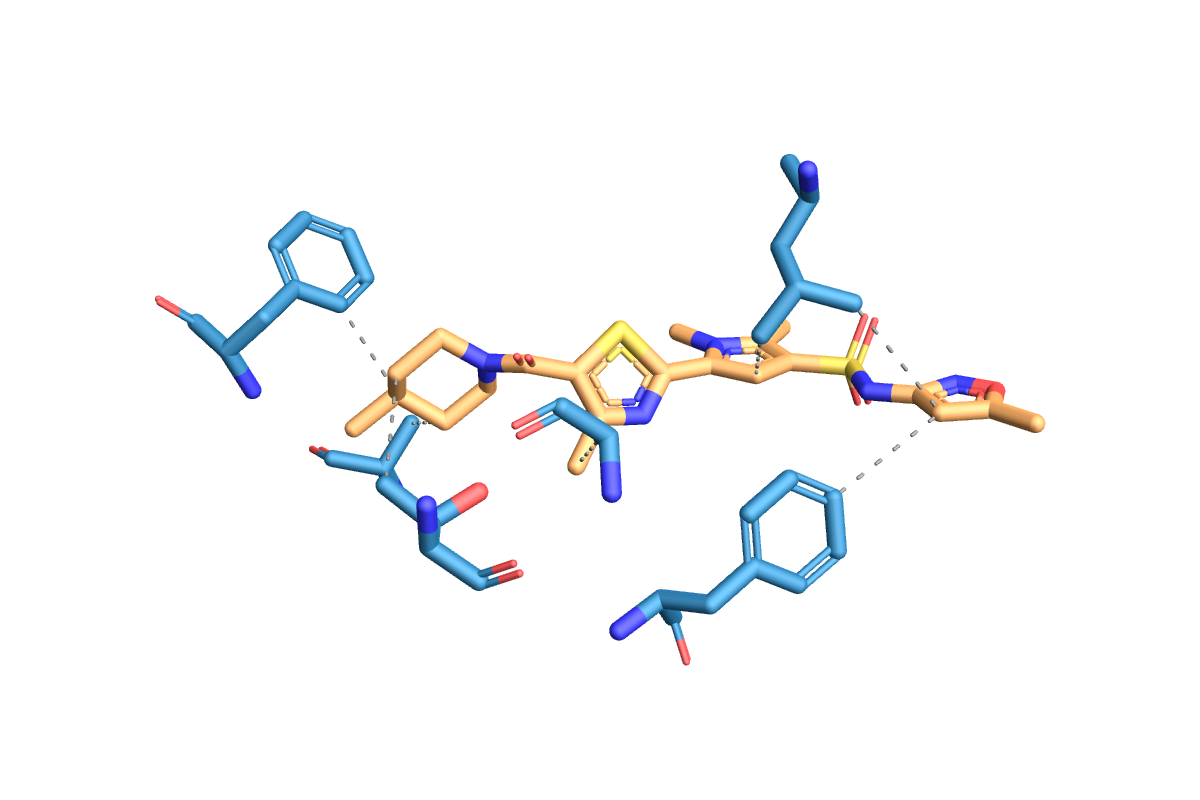


Binding sites for R018:


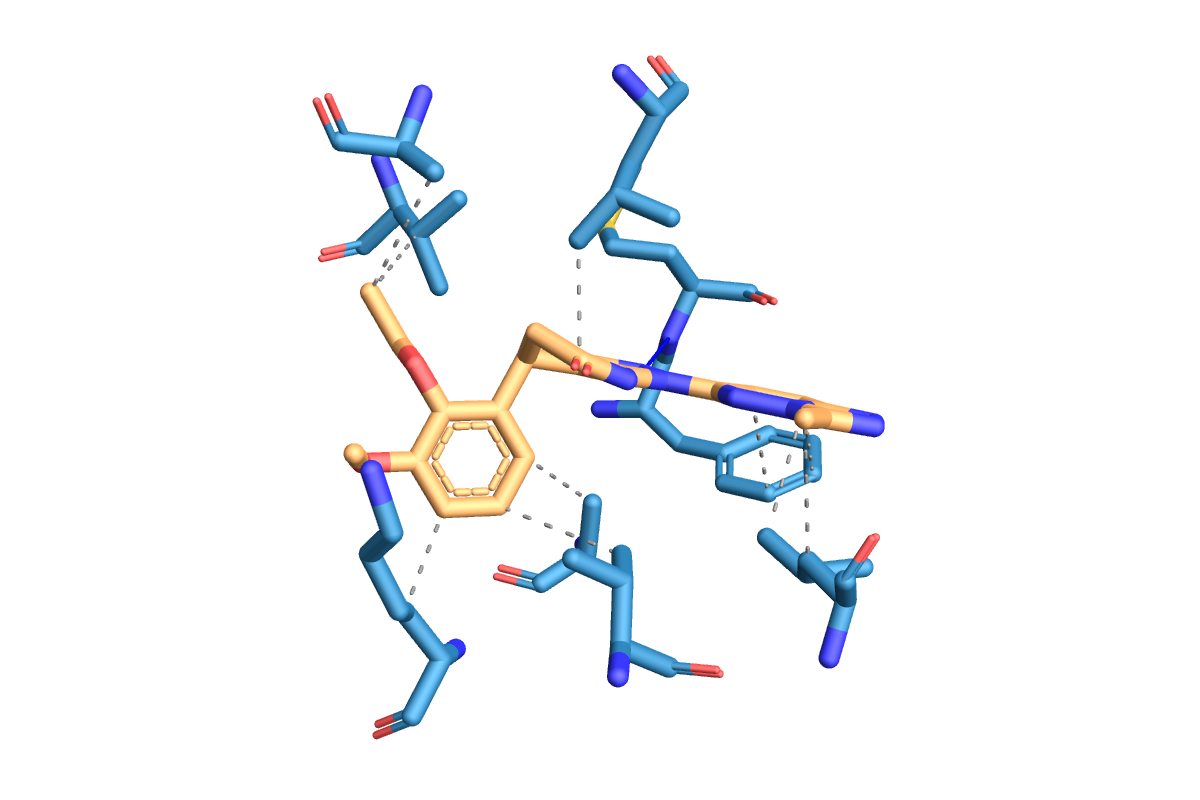


Binding sites for R048:


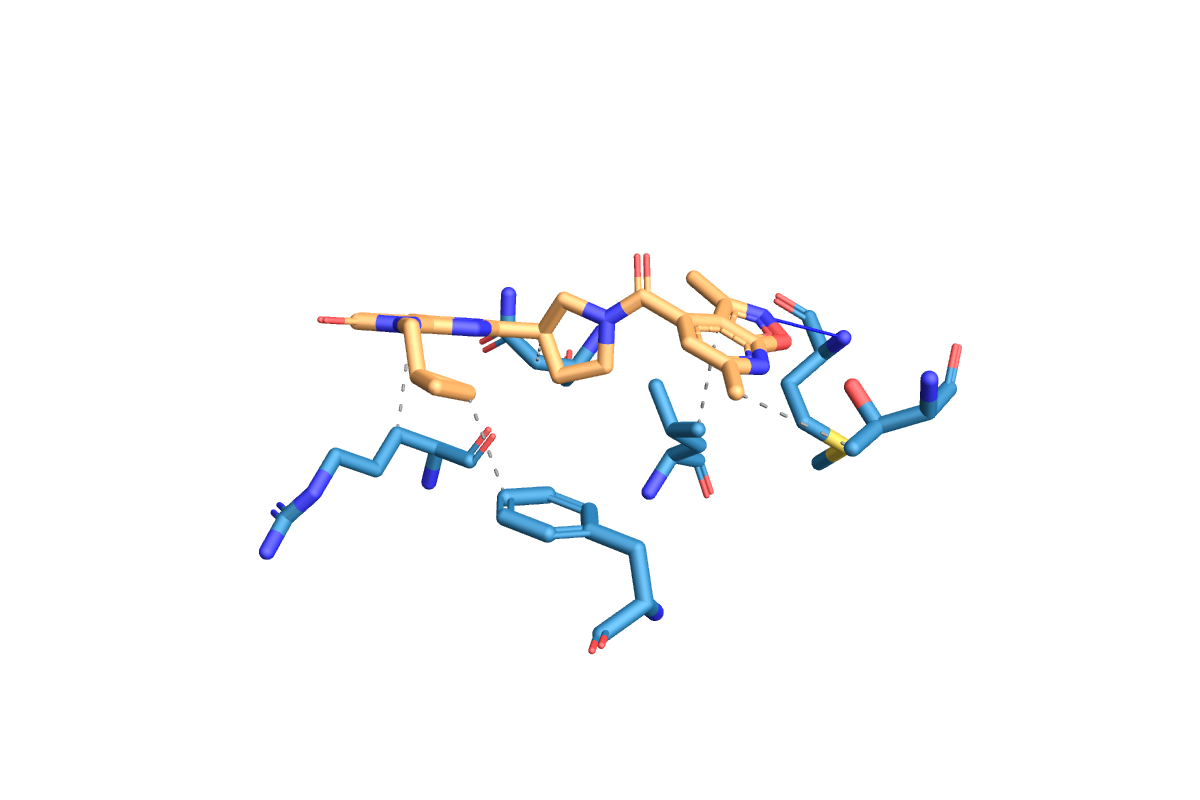


Binding sites for R033:


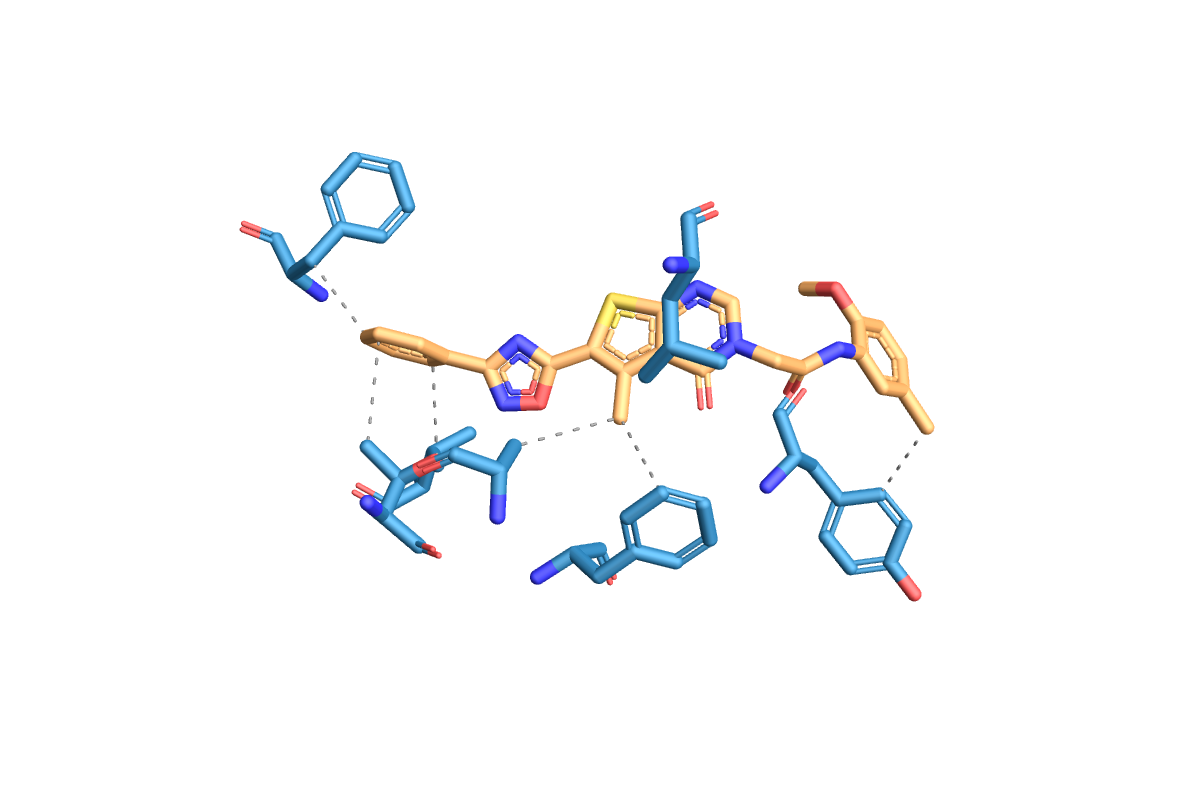


Binding sites for R049:


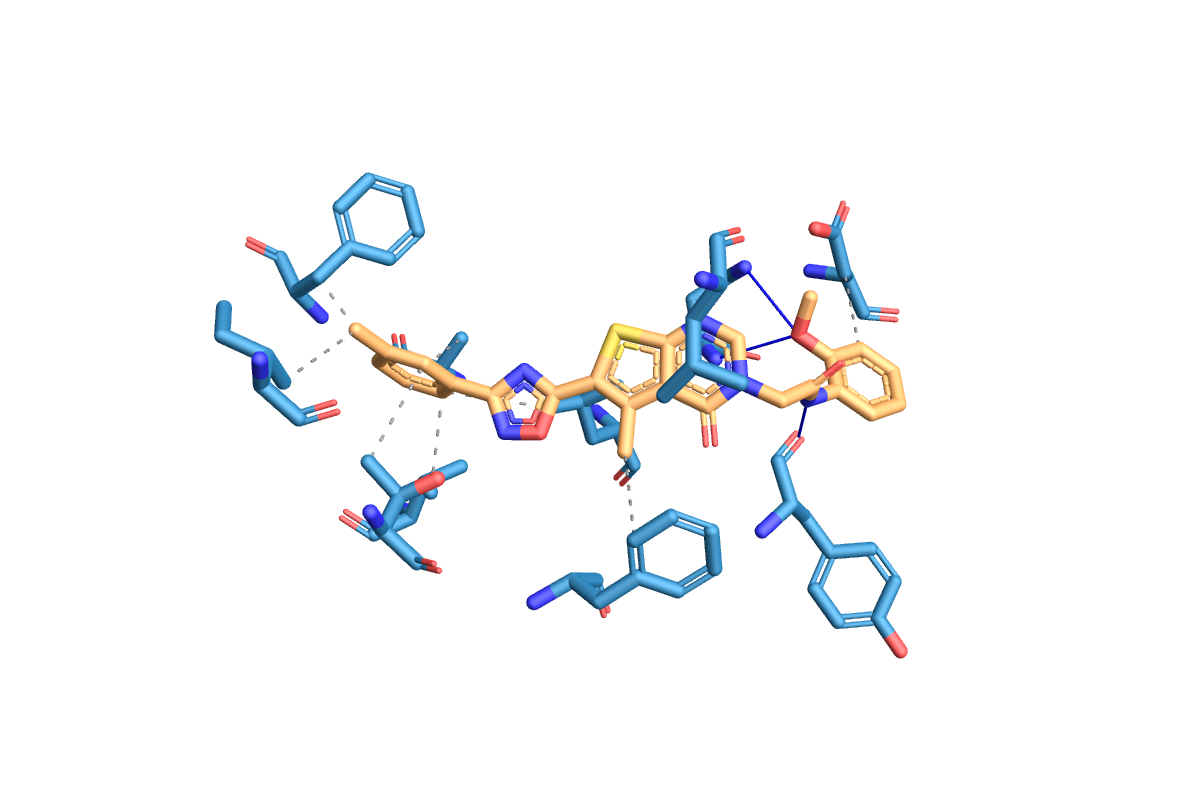


Binding sites for R035:


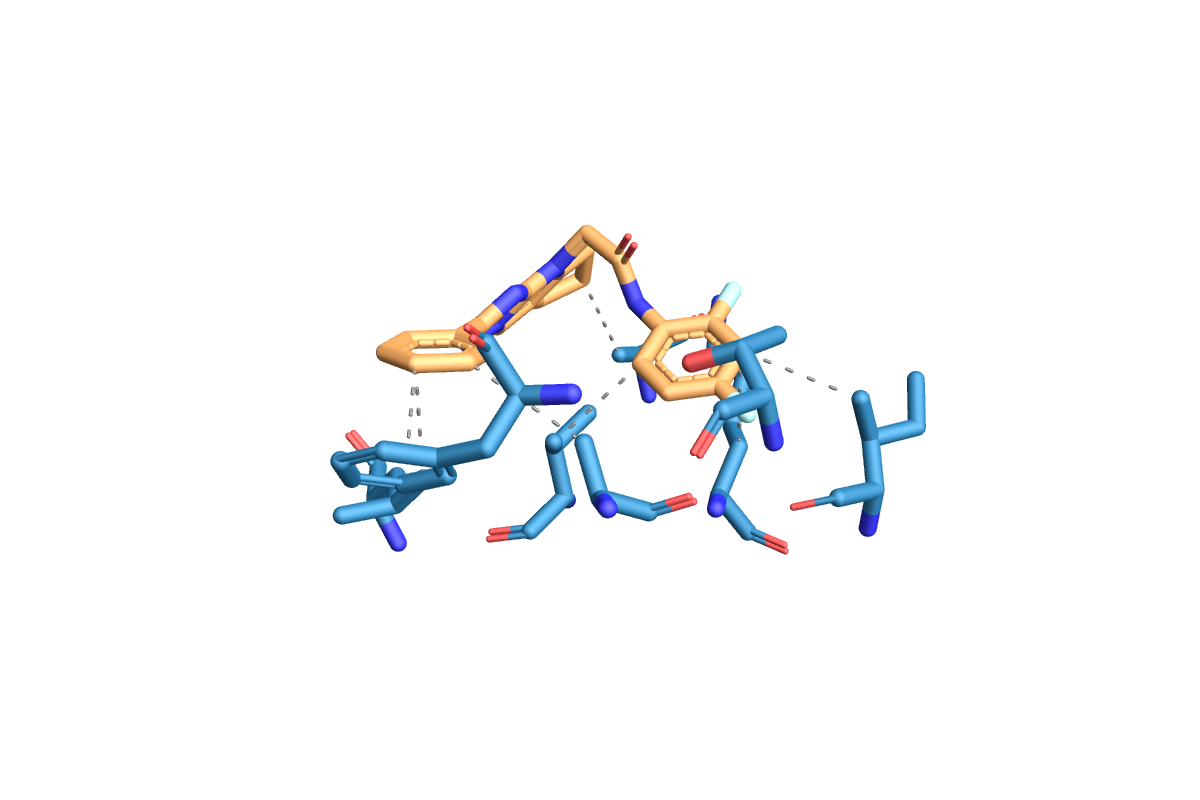


Binding sites for R038:


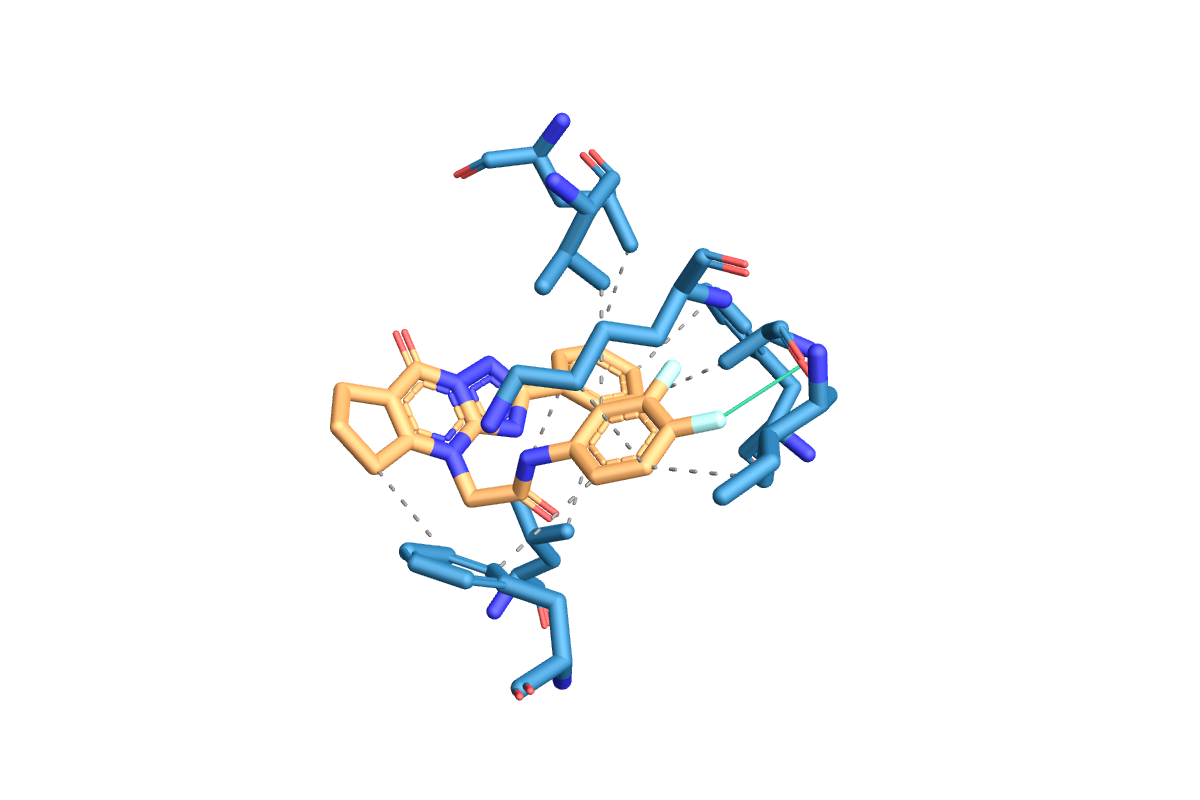


Binding sites for R045:


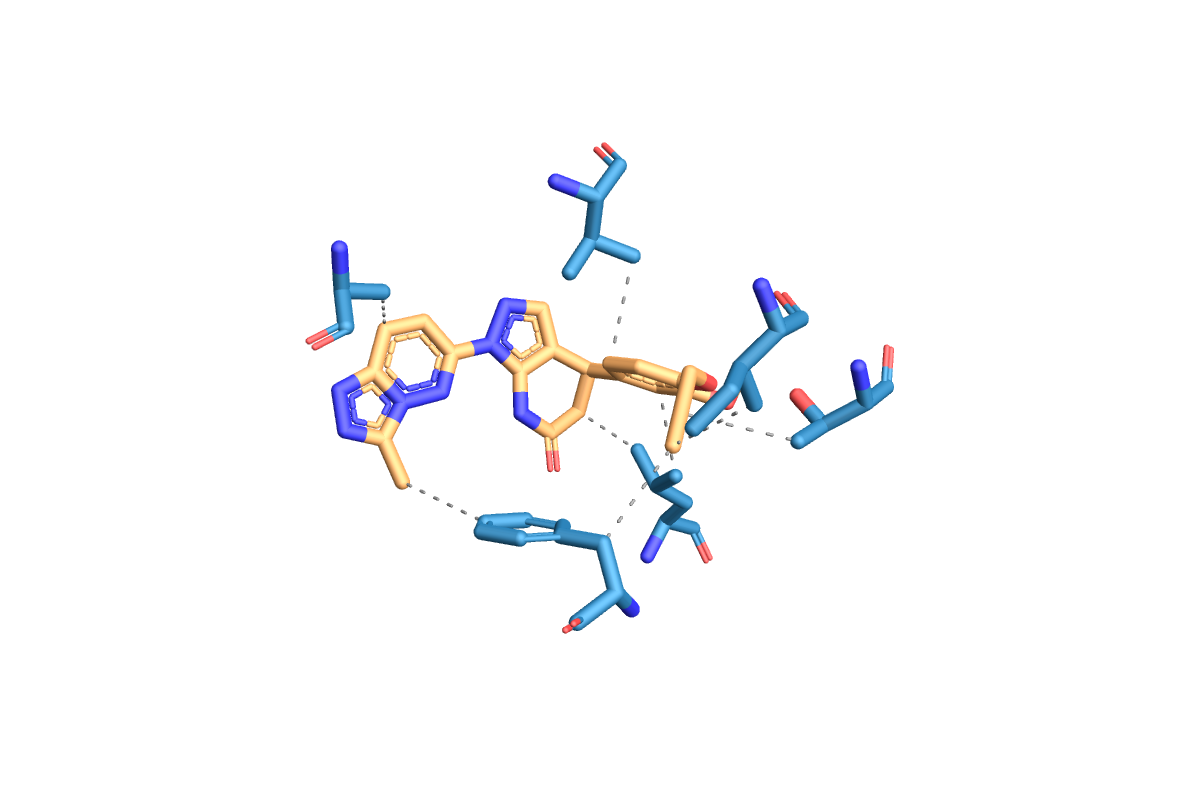


Binding sites for R021:


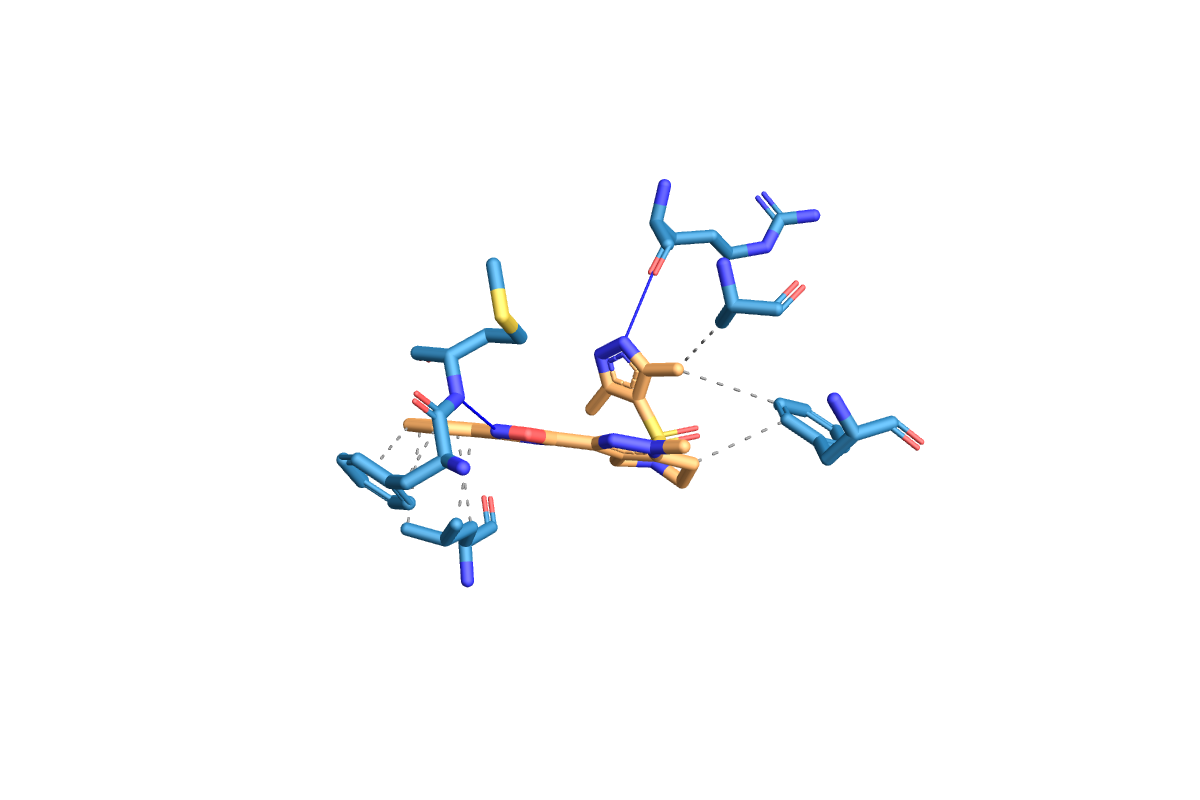


Binding sites for R050:


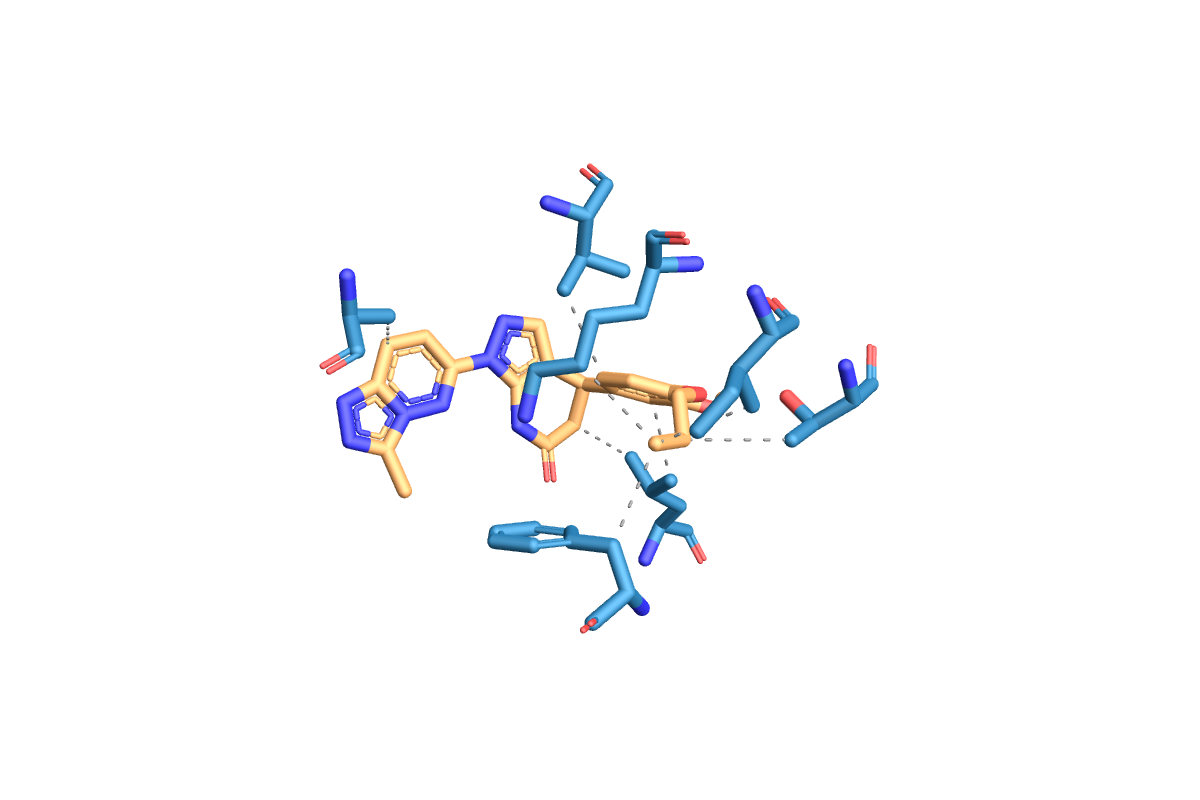


Binding sites for R031:


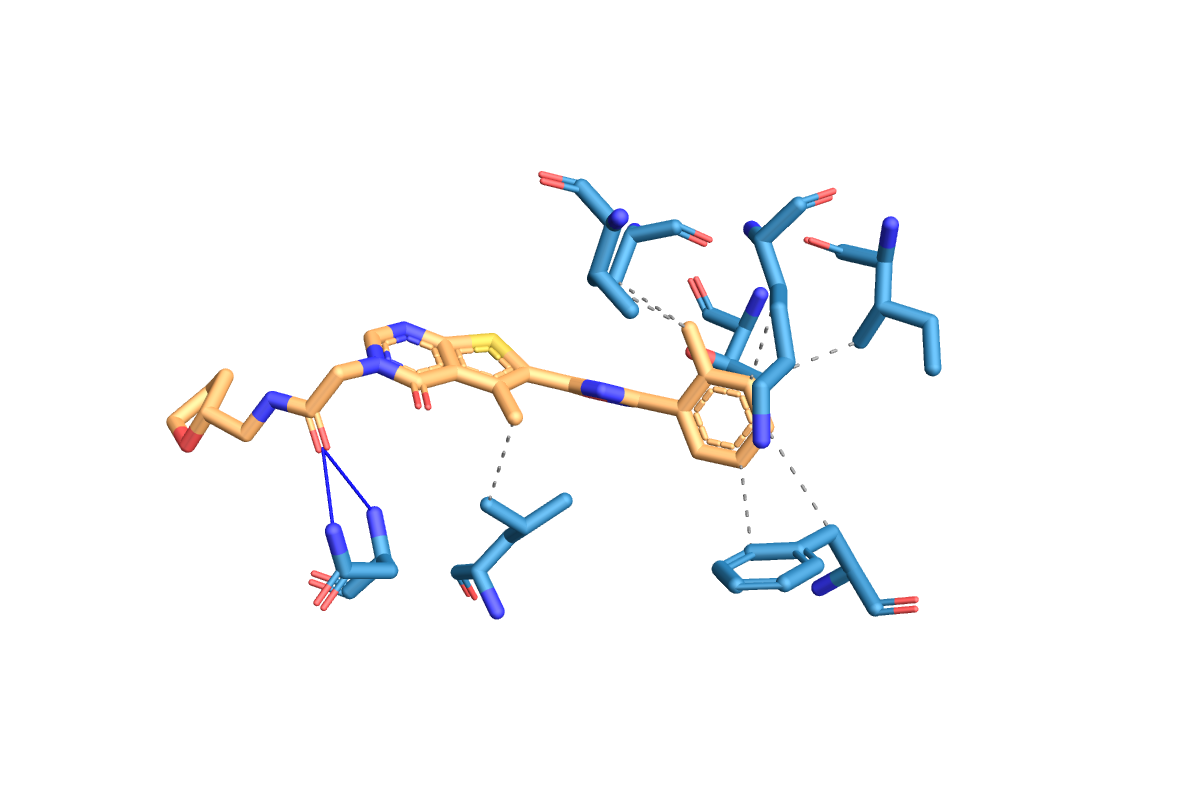


Binding sites for R023:


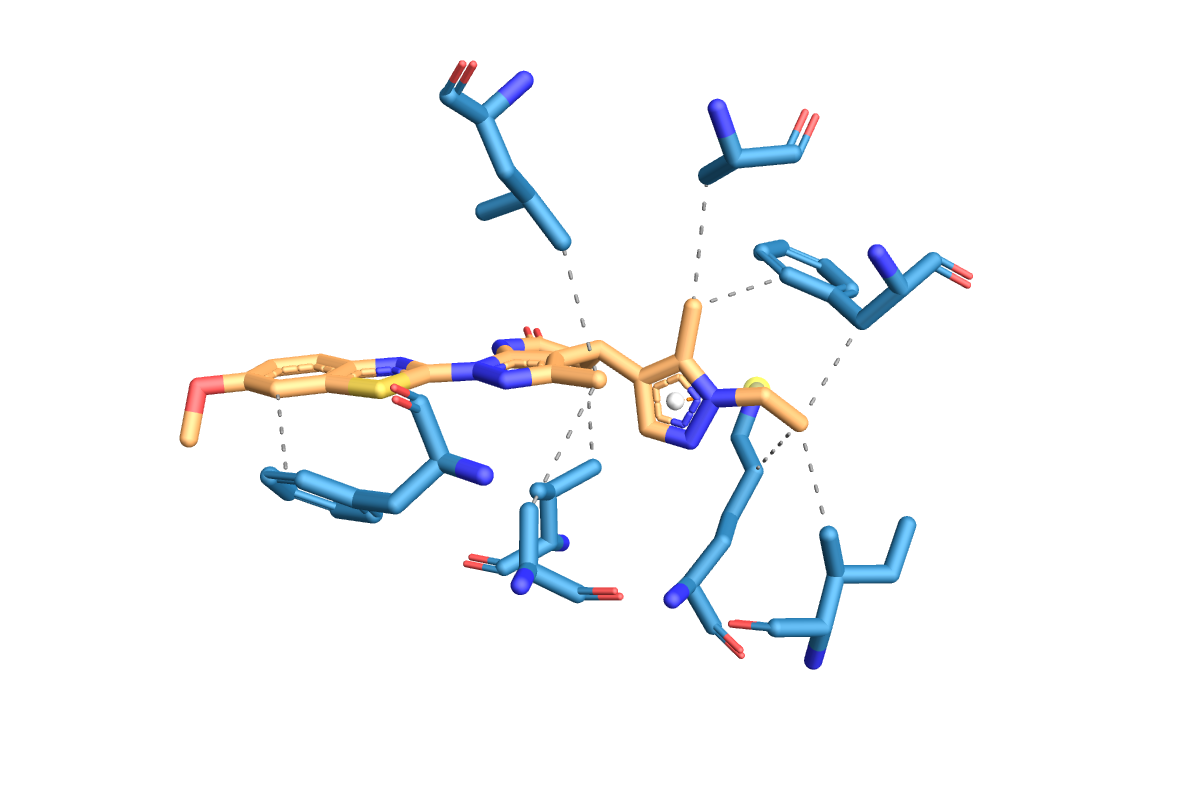


Binding sites for R007:


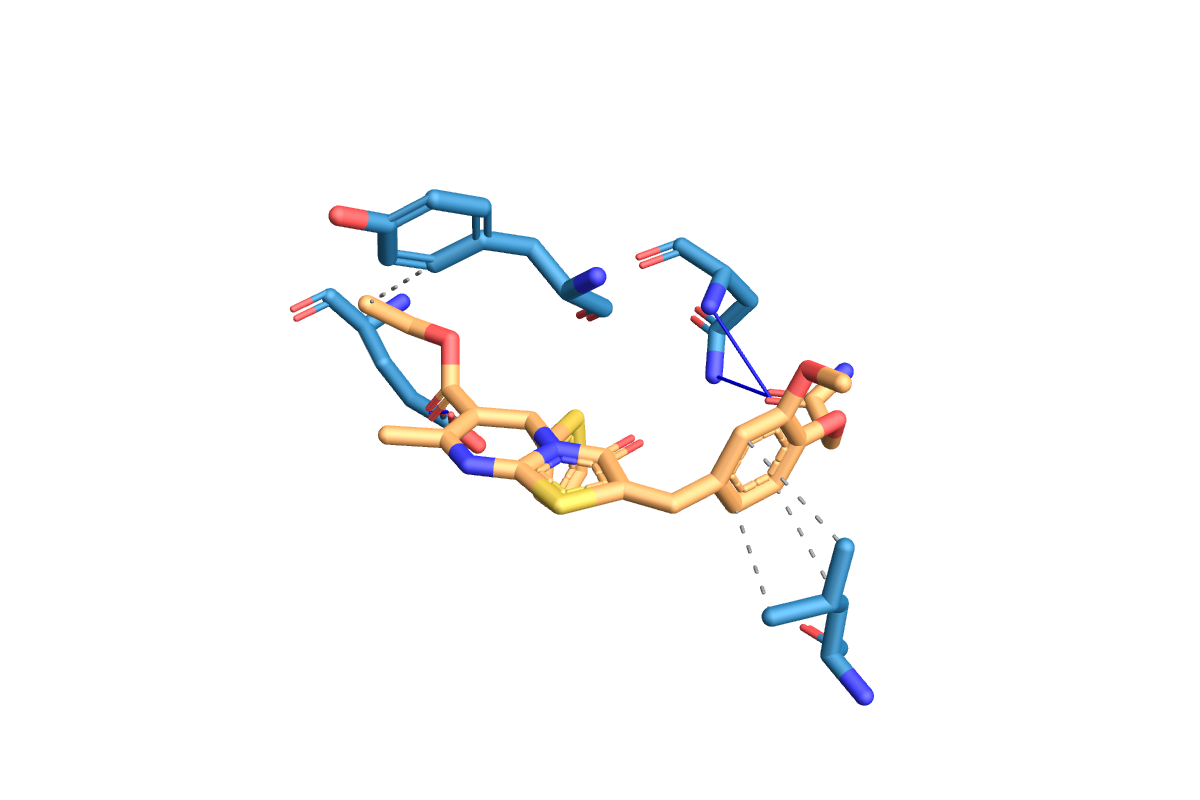


Binding sites for R014:


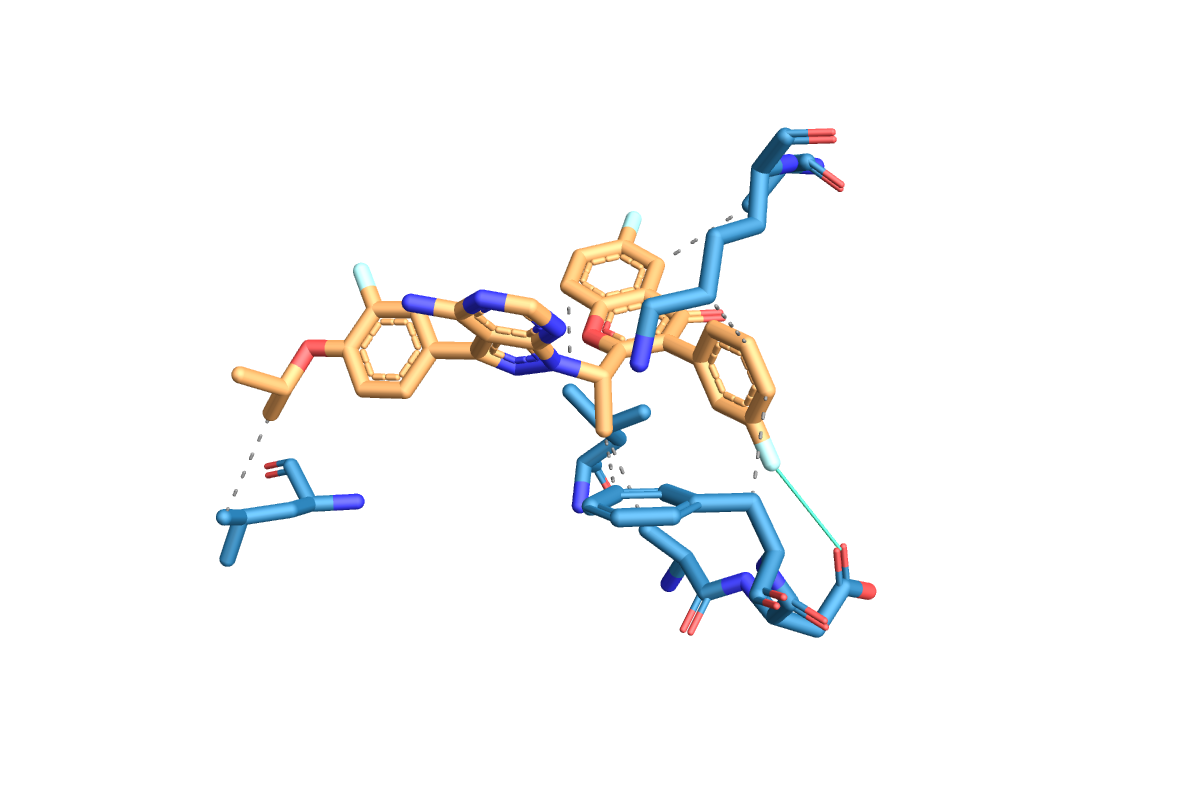


Binding sites for R022:


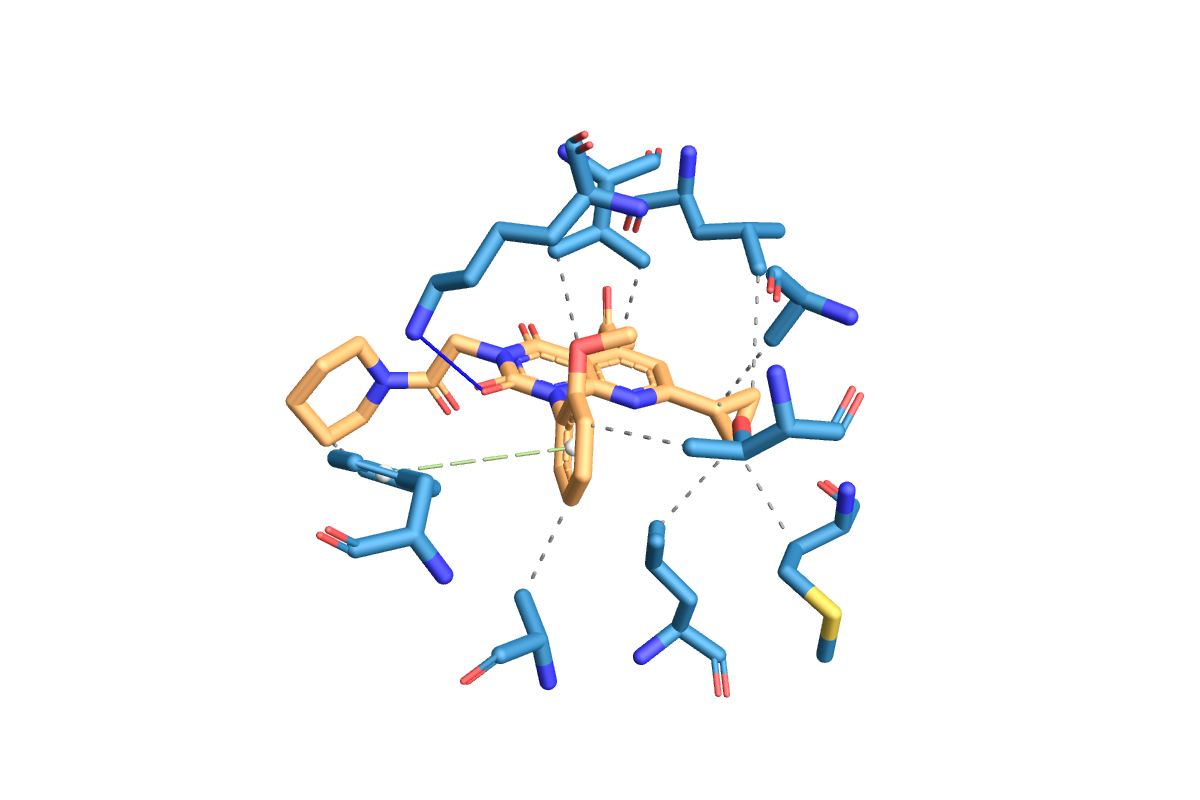


Binding sites for R030:


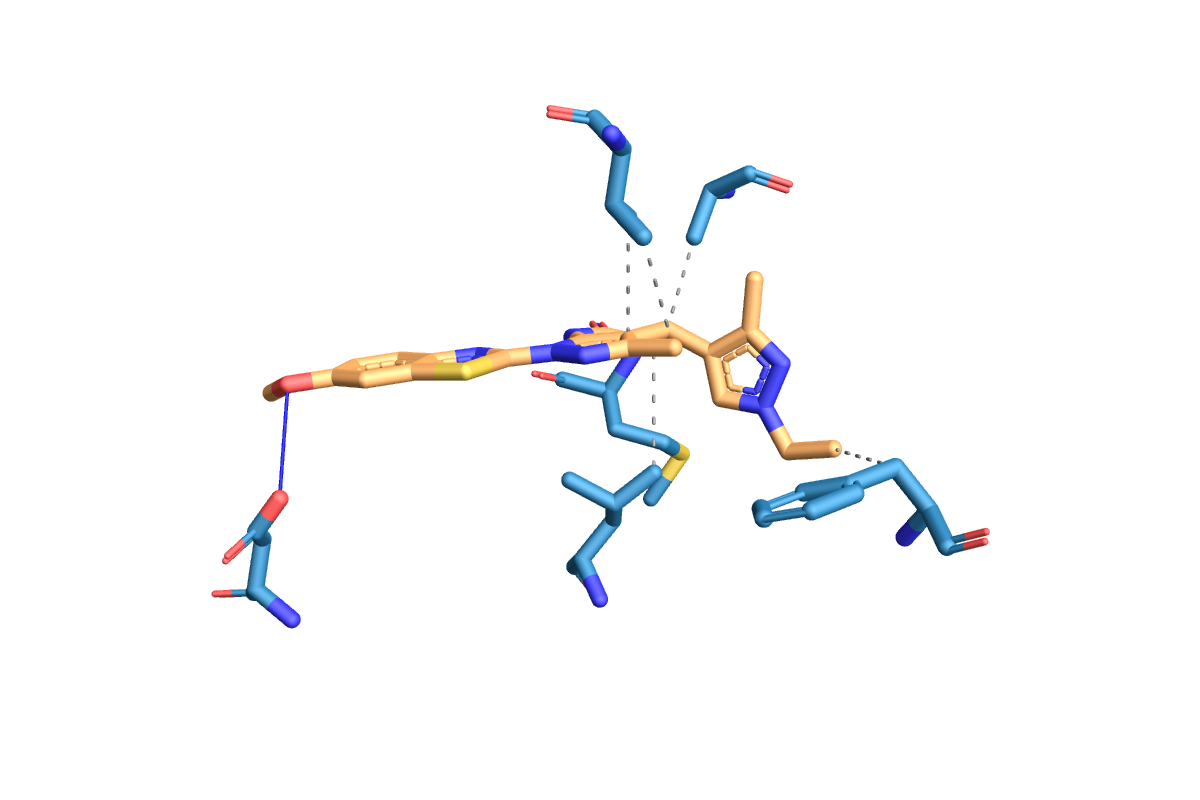


Binding sites for R013:


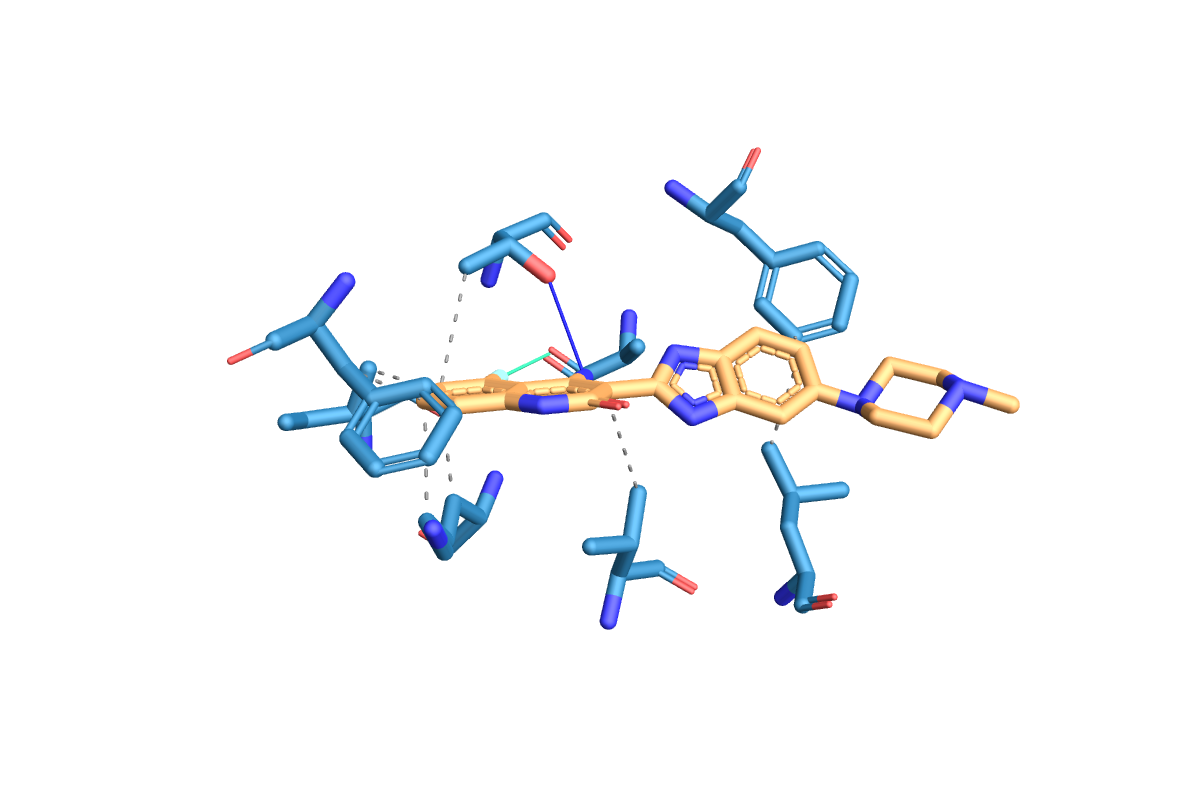


Binding sites for R001:


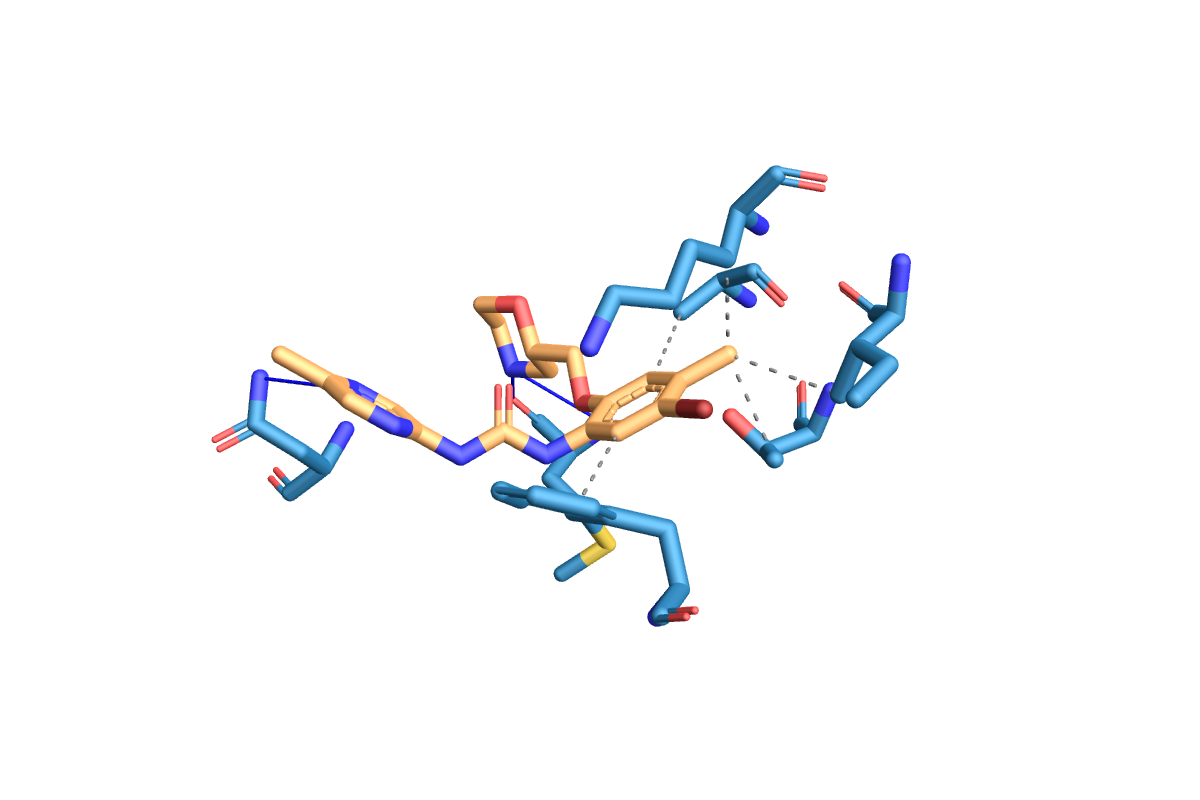


Binding sites for R044:


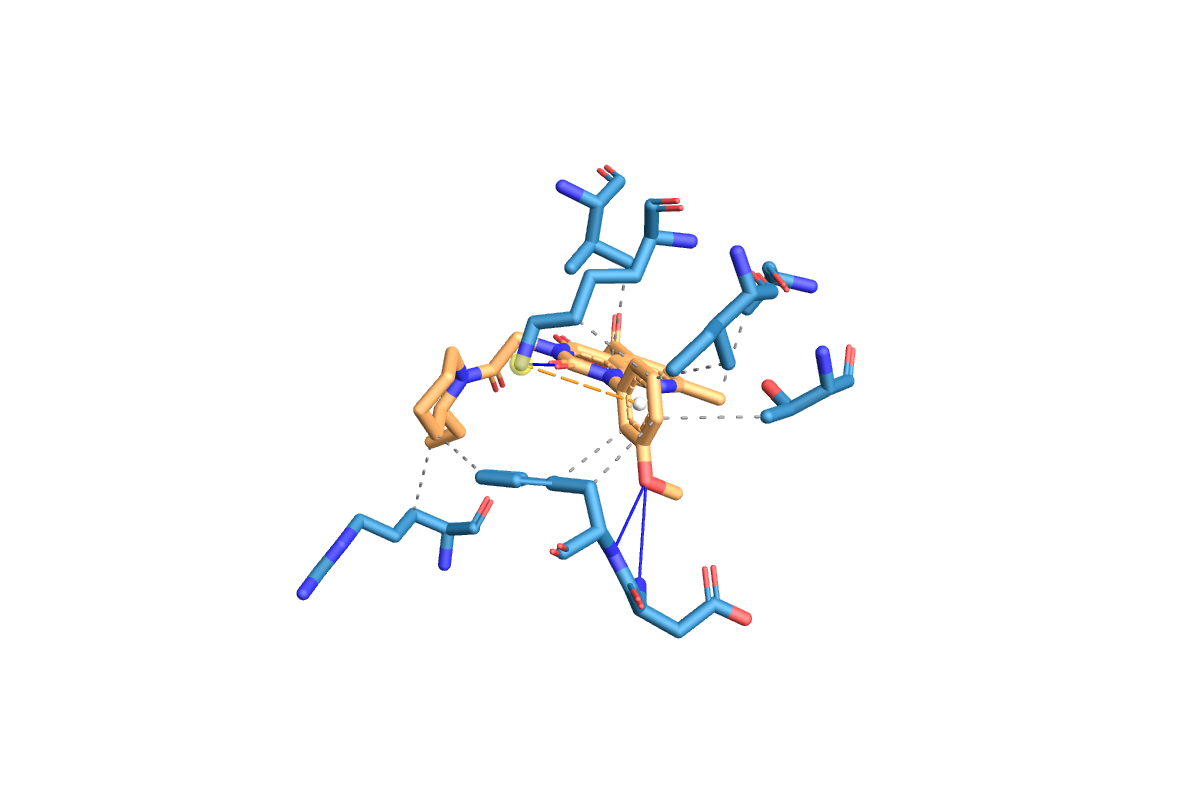


Binding sites for R042:


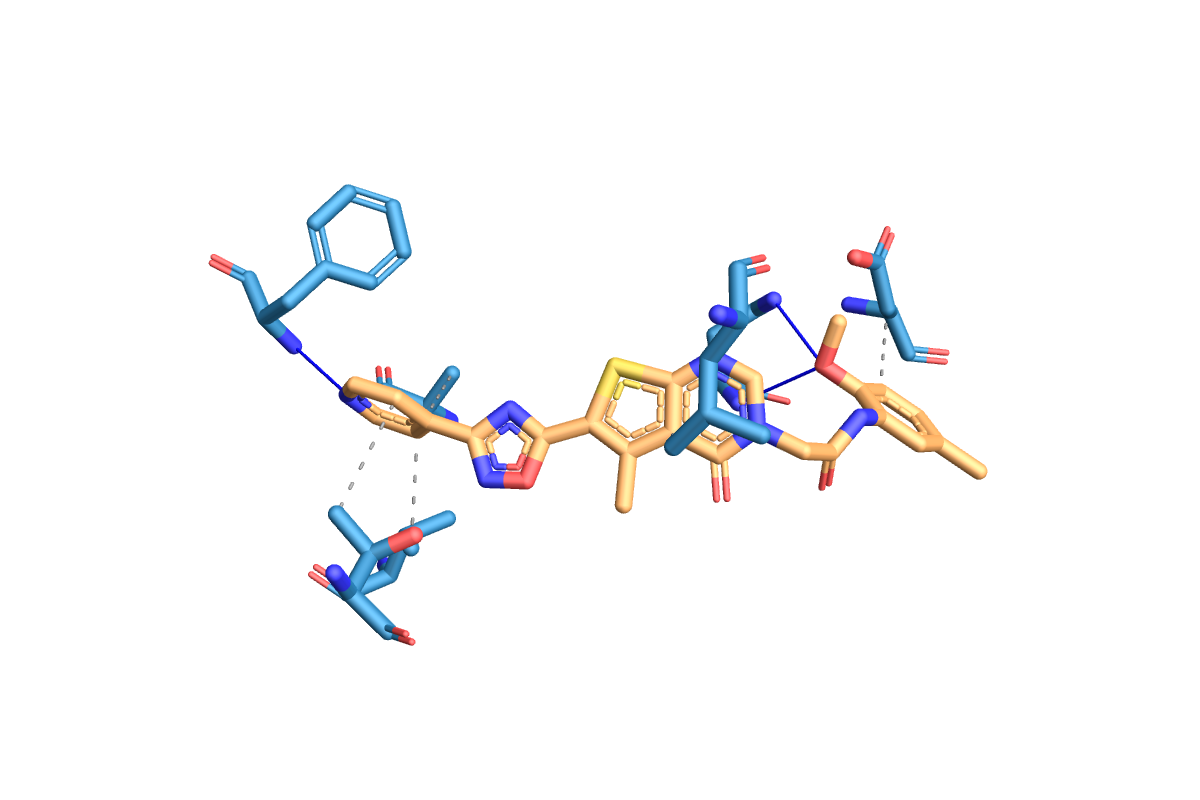


Binding sites for R011:


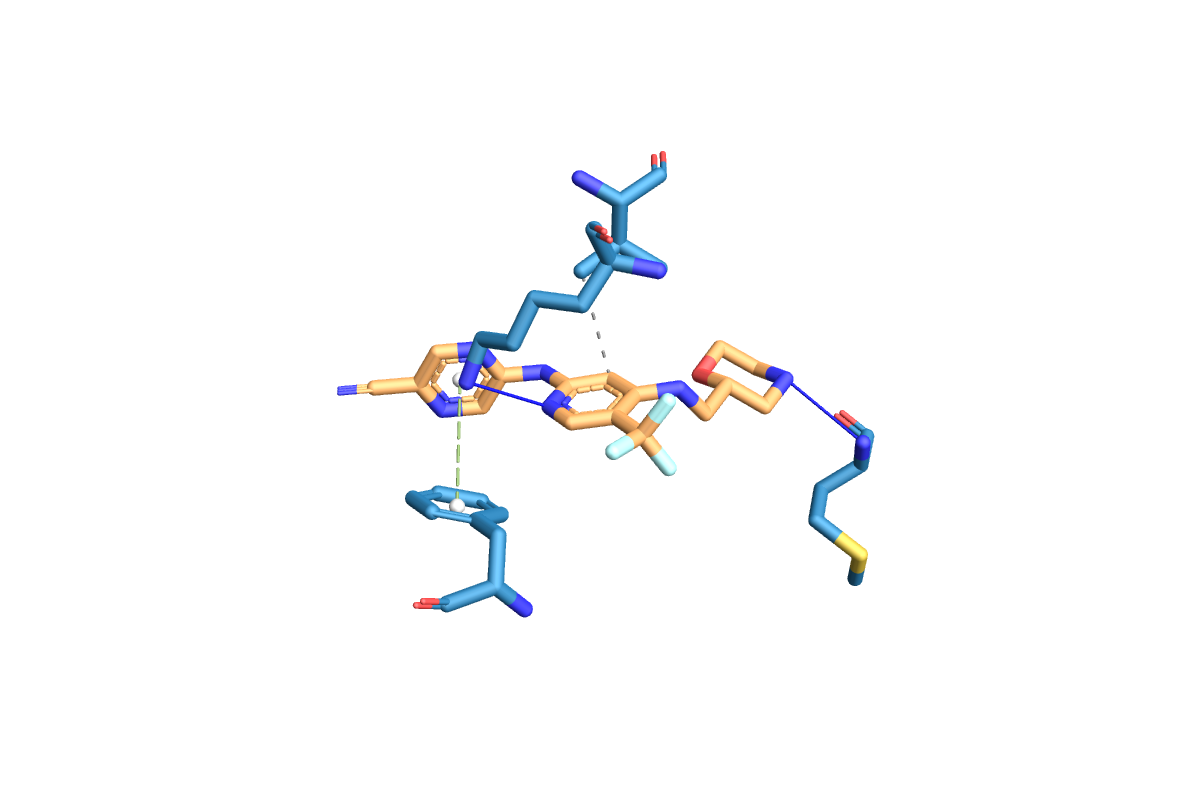


Binding sites for R008:


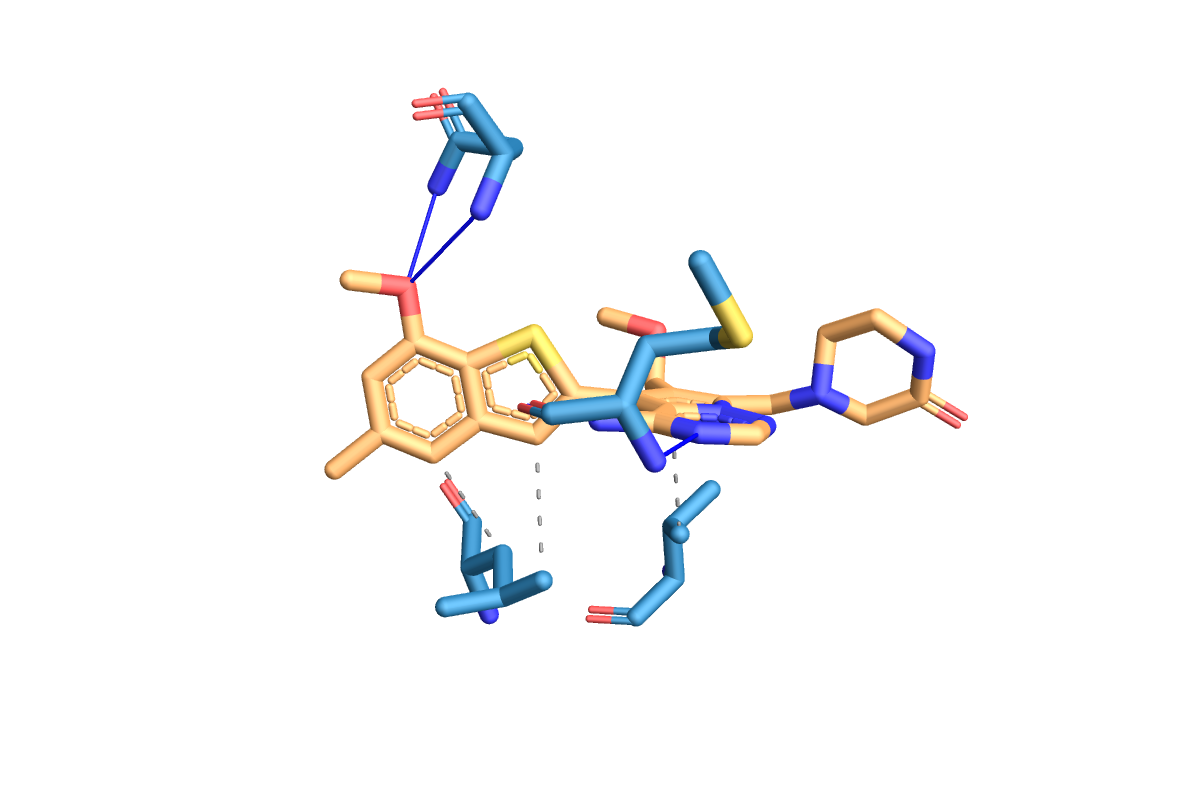


Binding sites for R017:


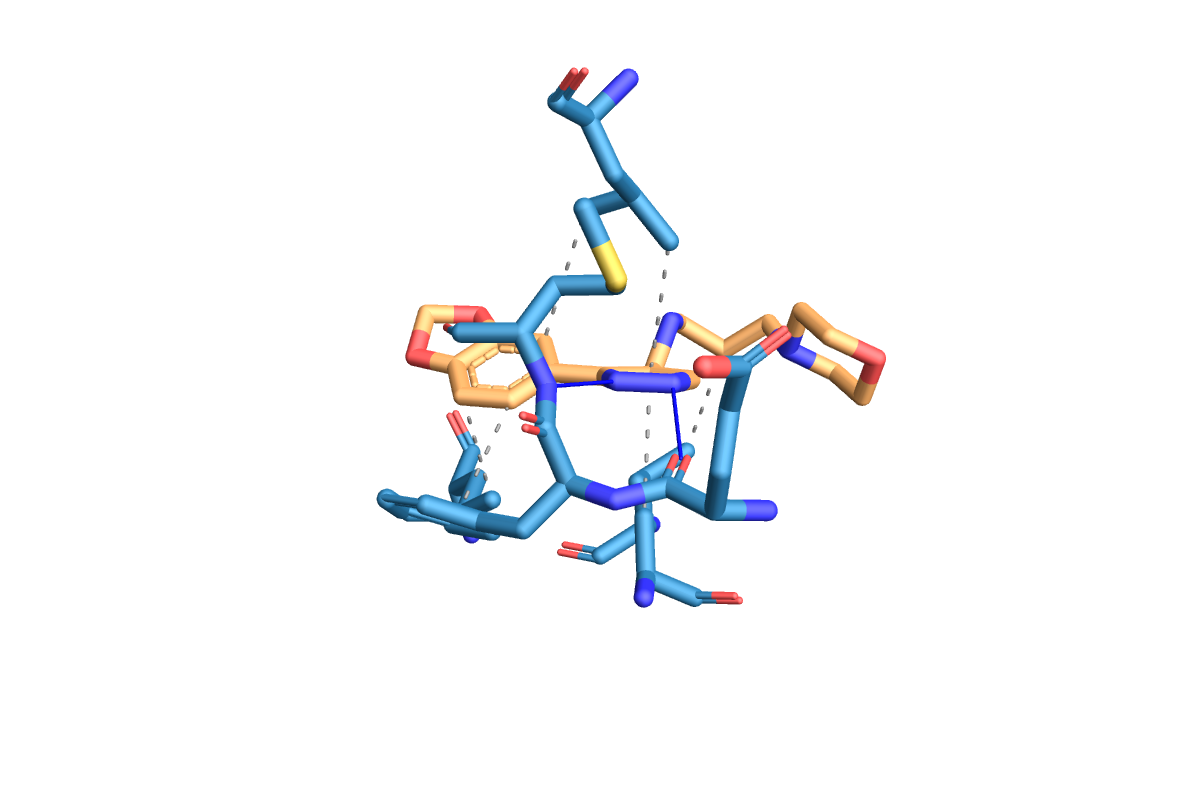


Binding sites for R047:


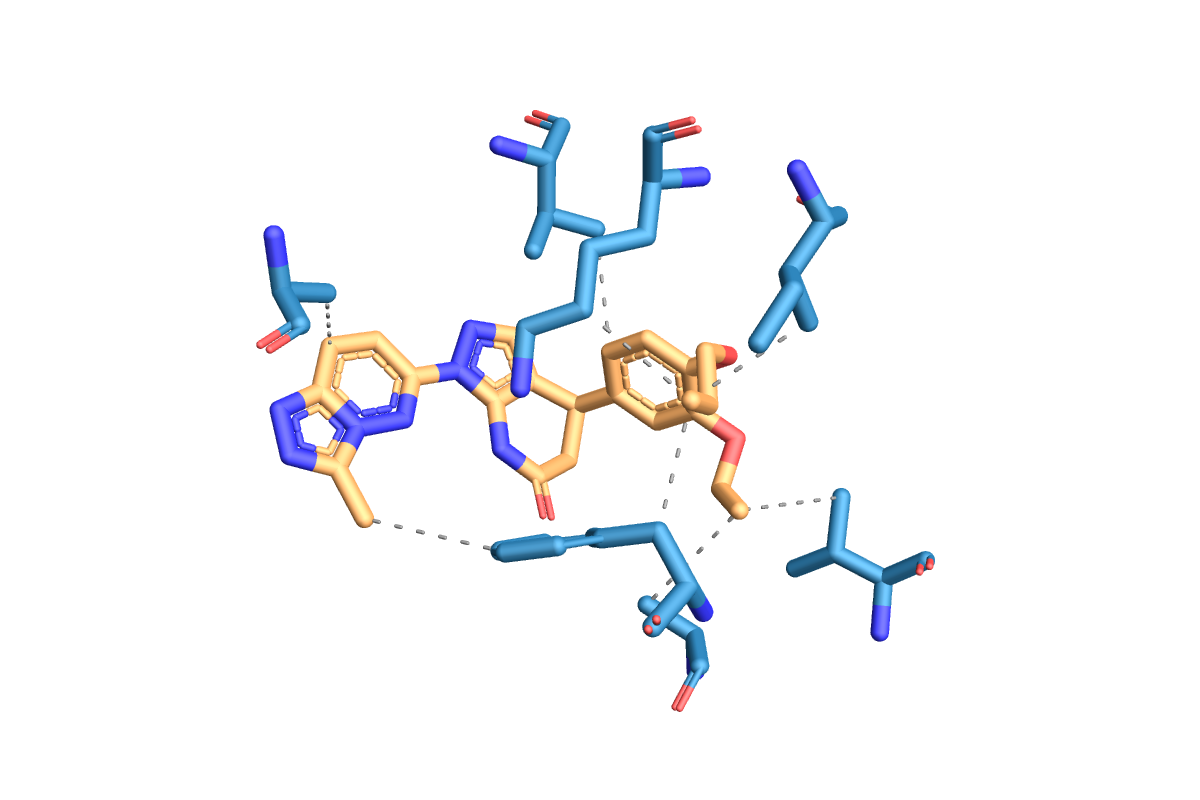


Binding sites for R010:


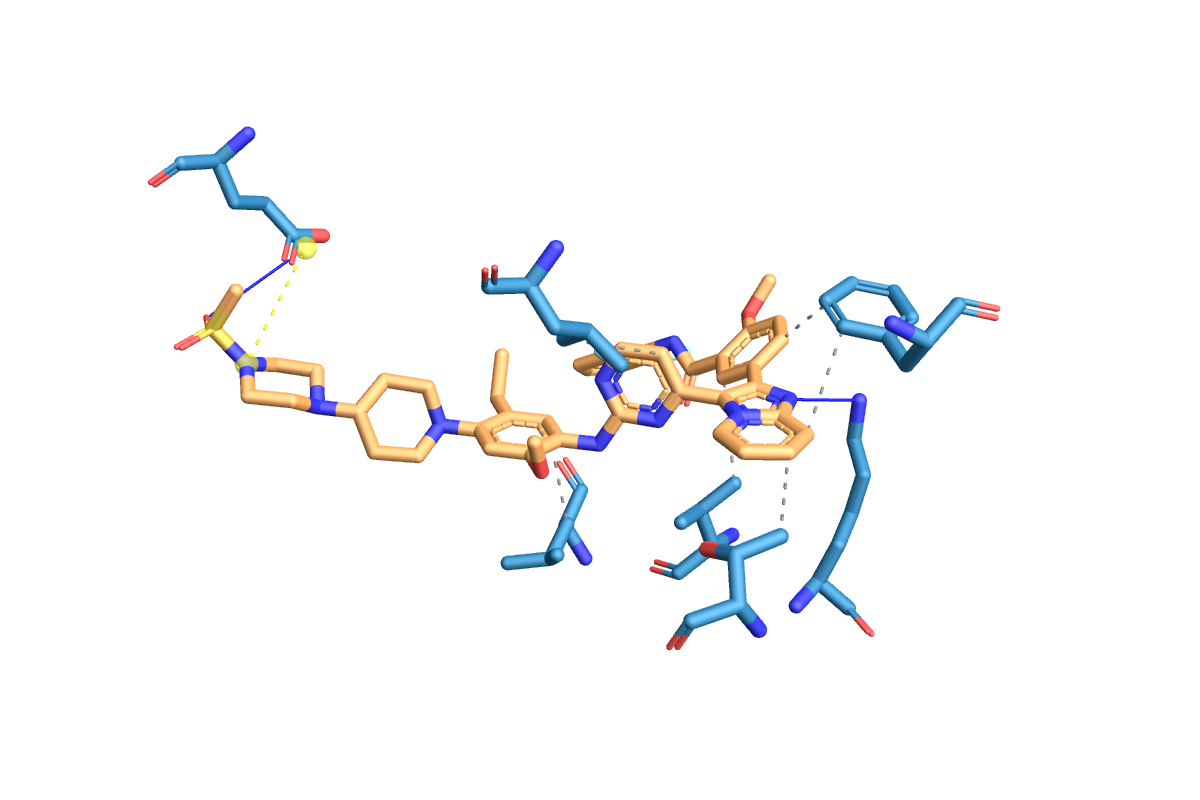


Binding sites for R027:


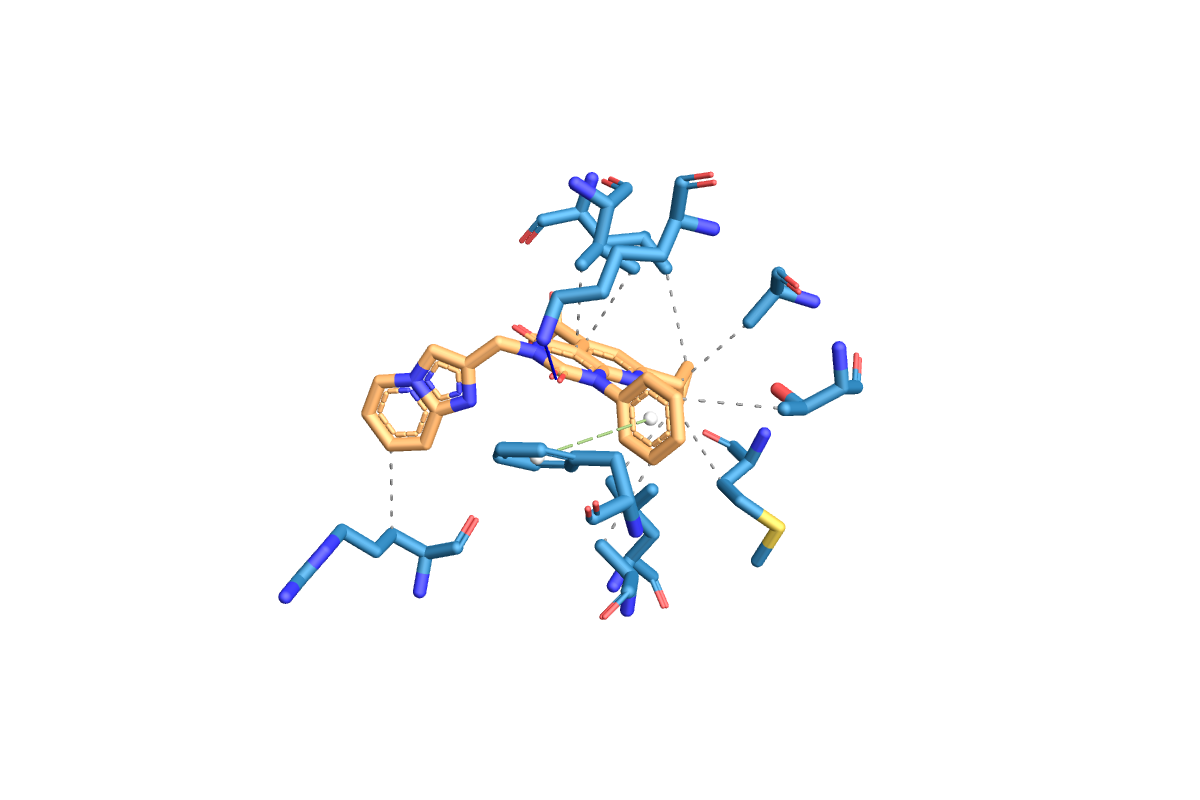


Binding sites for R003:


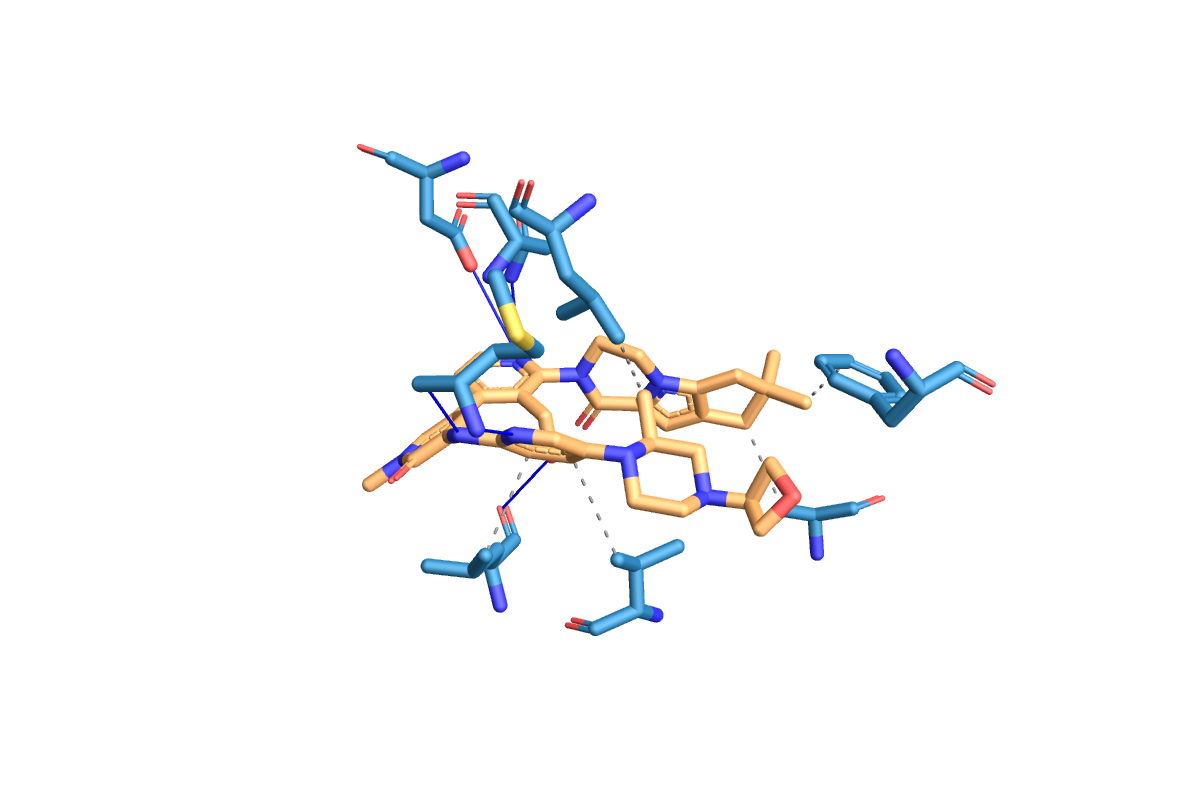


Binding sites for R039:


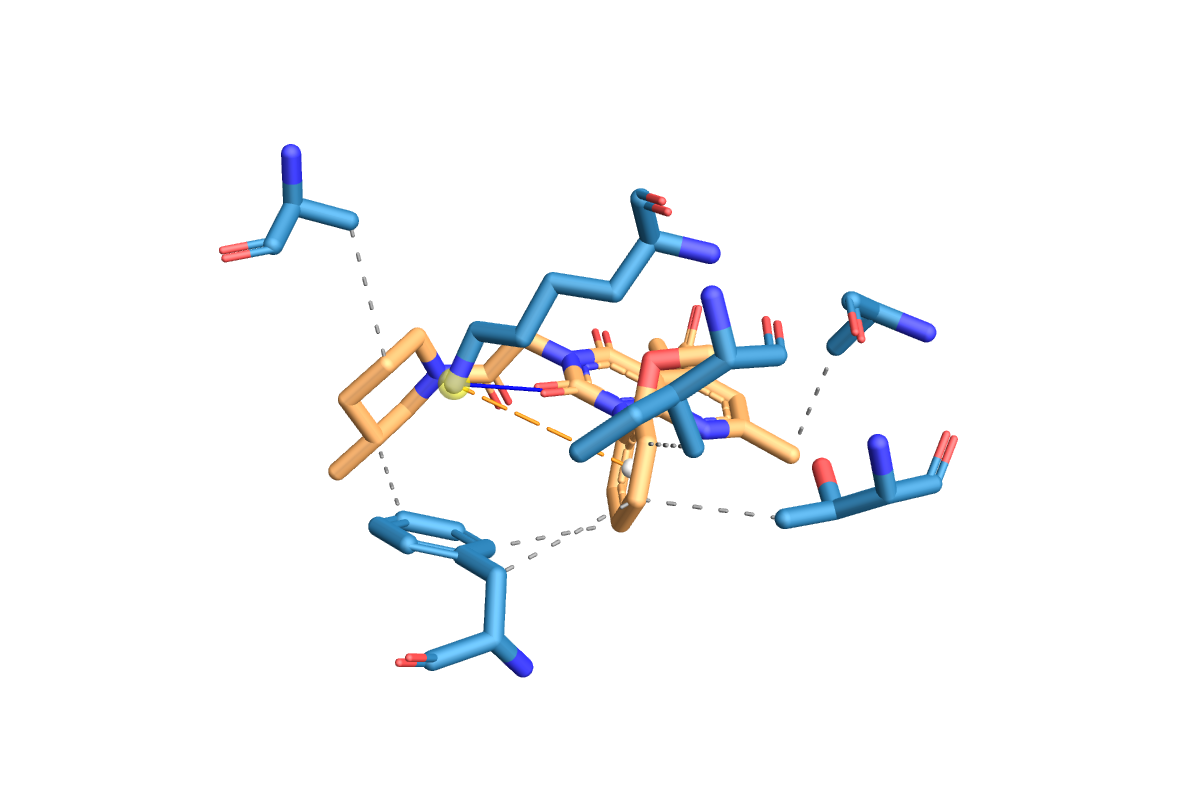


Binding sites for R028:


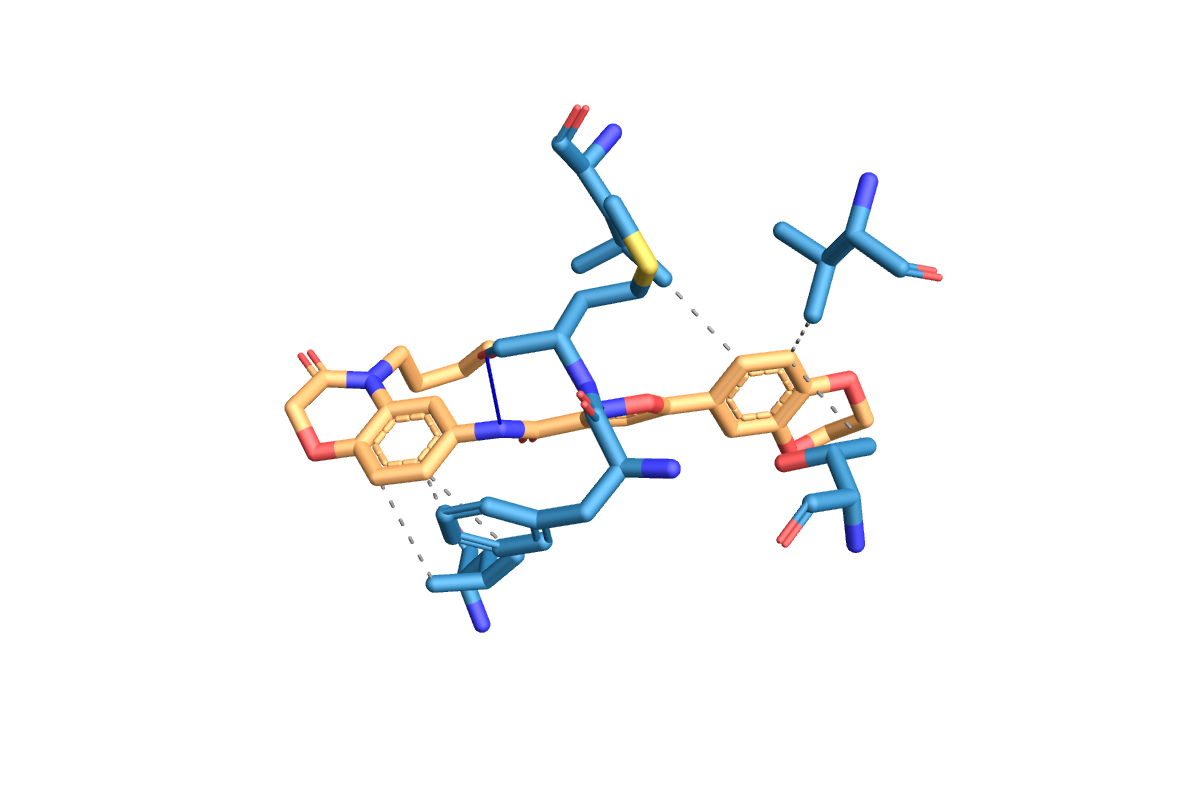


Binding sites for R016:


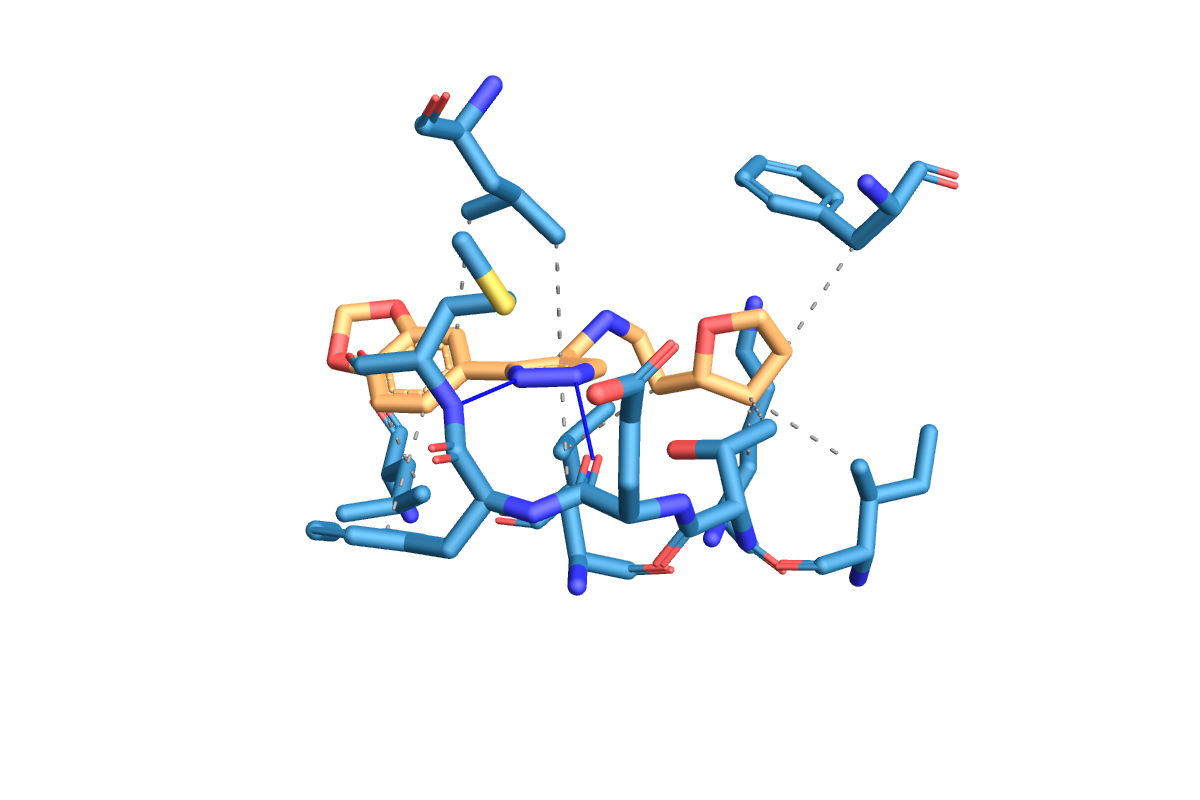


Binding sites for R034:


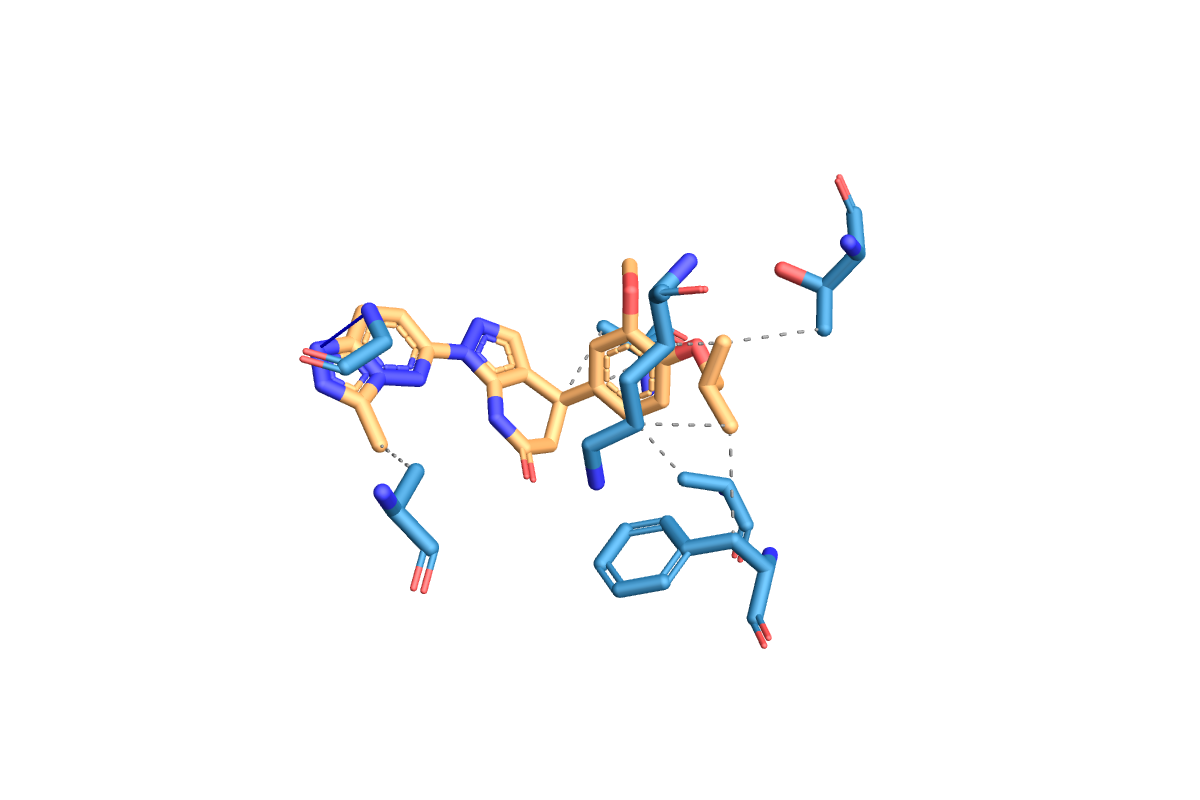


Binding sites for R012:


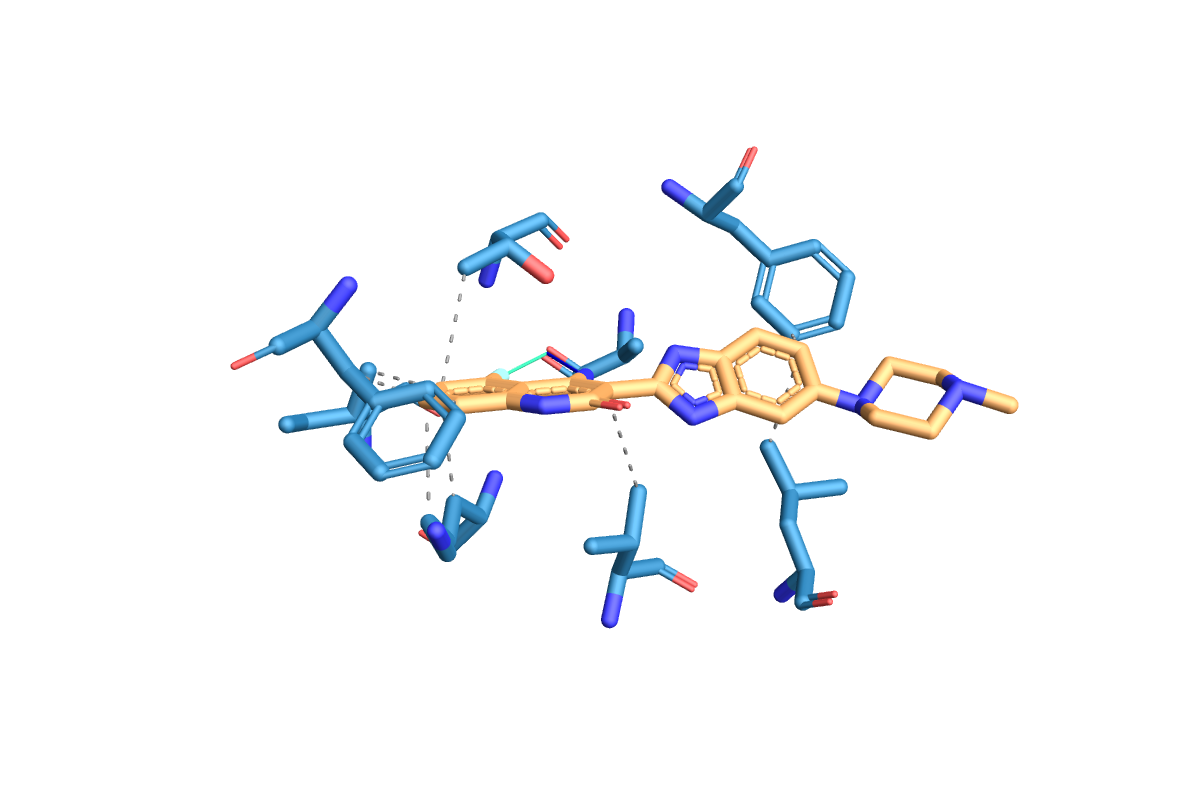


Binding sites for R025:


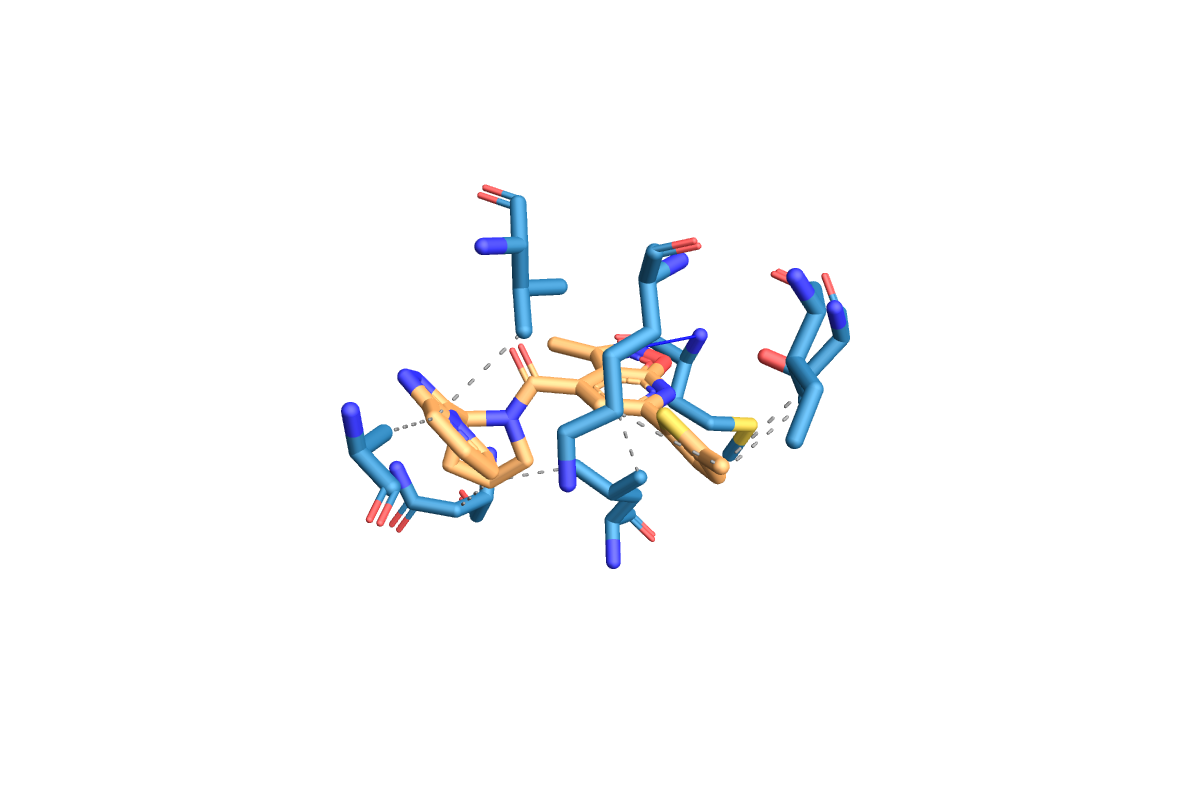


Binding sites for R005:


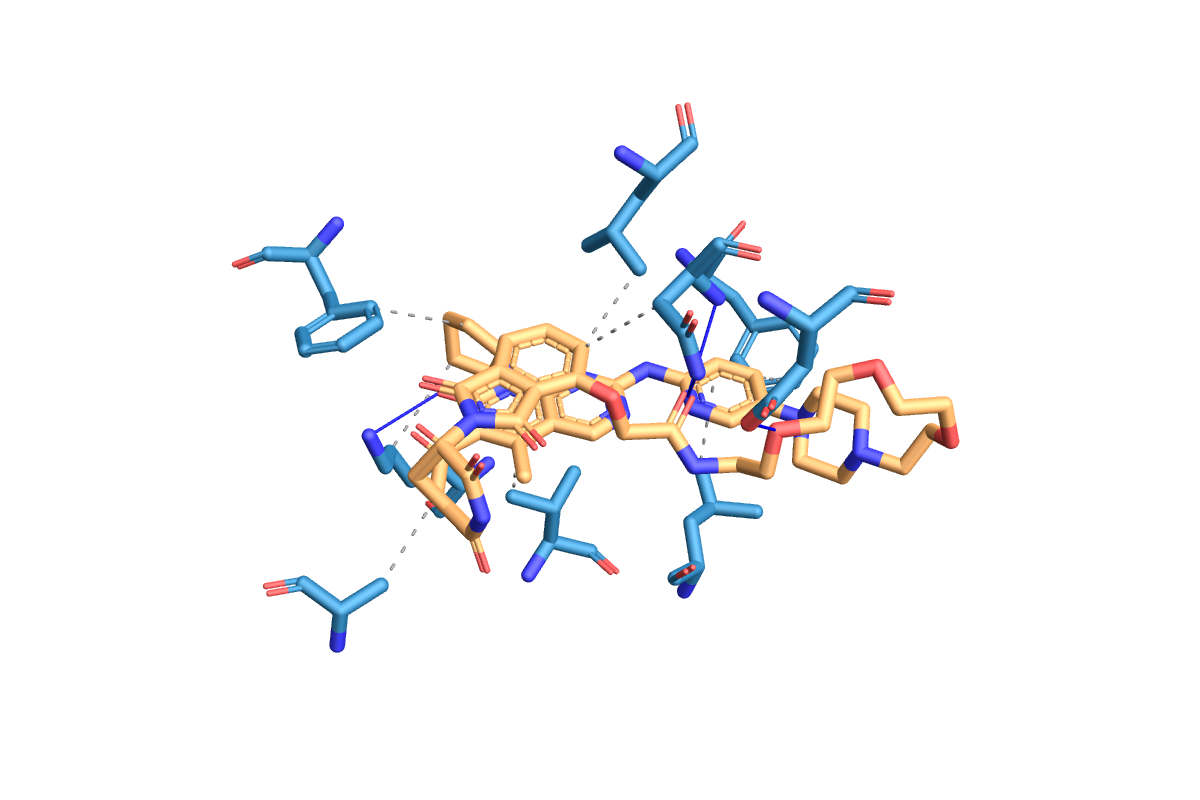


Binding sites for R036:


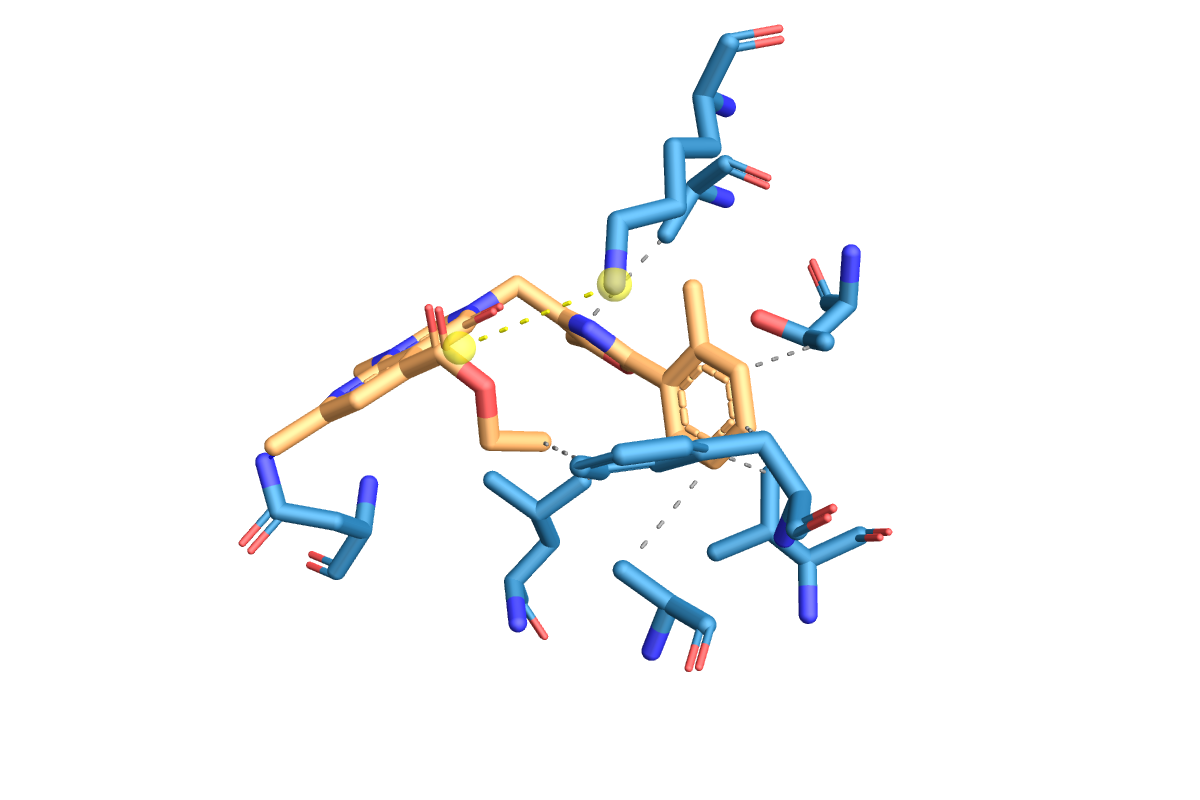


Binding sites for R024:


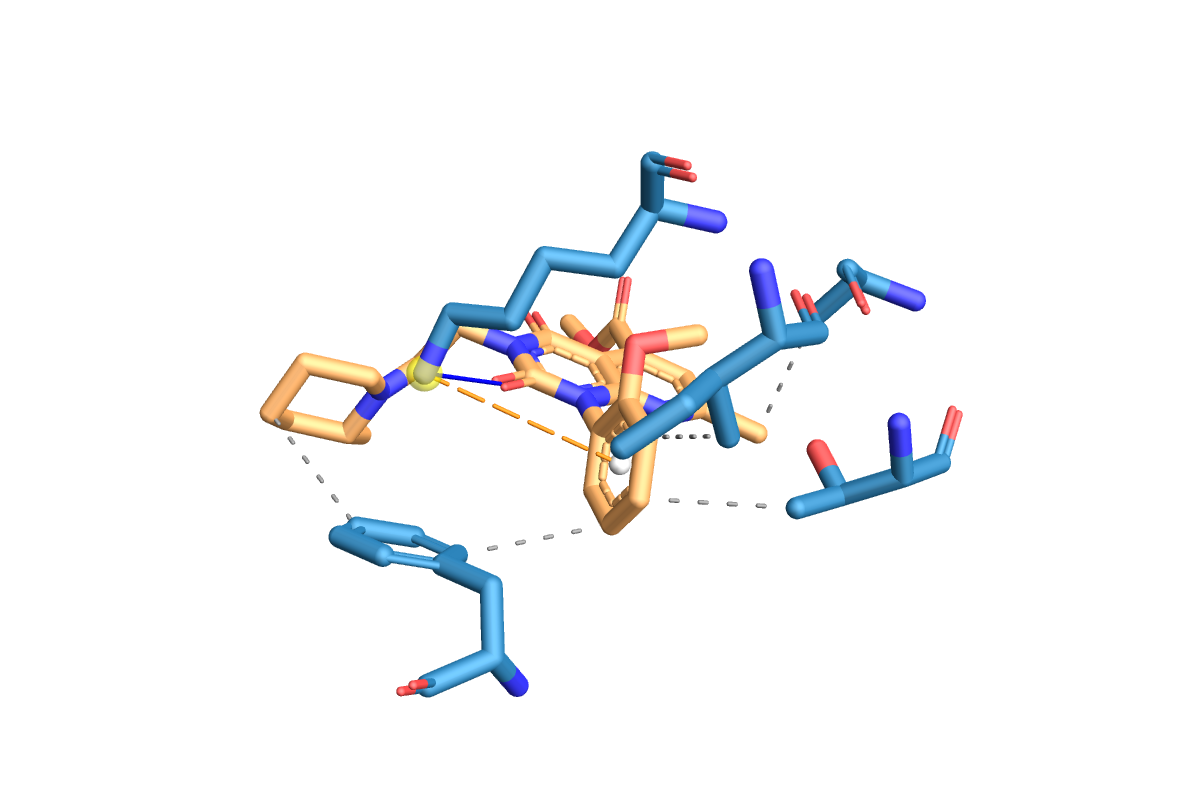

In [17]:
# @title
# -*- coding: utf-8 -*-
"""PLIP in Colab Chains - Batch Processing Version

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1KV0Yx6vMFXvtyIRtmkPoMLN0Q6GKG1pm

# Analyze Multiple PDB files with PLIP in Colab
Workflow:
1. Run the "Setup" cell first. This will take some time.
2. Place your PDB files in the 'plip_complexes' directory
3. Run the analysis cell to process all PDB files
4. Results will be saved in the 'plip_report' directory
"""

# Source: https://github.com/MooersLab/colabOpenSourcePyMOLpySnips

try:
  from pymol import cmd
  print("PyMOL already installed.")
except:
  from IPython.utils import io
  import os,time

  start = time.time()
  print("Installing PyMol takes some time.")

  # do not display all the output that installation generates
  with io.capture_output() as captured:

    # install condacolab
    !pip install -q condacolab
    import condacolab
    condacolab.install()

    # January 2024 there seems to be a problem between colab and cudatoolkit=12.2
    # https://stackoverflow.com/questions/77726543/trouble-installing-isce2-in-colab-cudatoolkit-12-2-is-missing-from-the-target
    # sed command below solves problem
    !sed -i '/cudatoolkit/d' /usr/local/conda-meta/pinned
    !conda create -n pymol310 python=3.10

    # Main command: !conda install -c conda-forge pymol-open-source
    !mamba install pymol-open-source

  # test whether install was successful
  ok = ""
  try: from pymol import cmd
  except: ok = "not "
  print("It took %d seconds.\nPyMOL import %sok."%(time.time()-start, ok))

"""⚠ Important! Installing PyMol restarts your runtime - remember to afterwards rerun all setup cells for the colab to work again properly if you are not installing PyMol first!

## Install other requirments

###Install OpenBabel
"""

!pip install openbabel-wheel

!git clone -b master https://github.com/pharmai/plip.git

"""### Adapt PLIP's installation requierements to be able to work with new PyPI package"""

!sed -i '23d' plip/setup.py

"""### Install PLIP to be usable via the plip command line call"""

!pip install -e plip

"""## Process Multiple PDB Files"""

import os
import glob
from IPython.display import display, clear_output, Image
import shutil

def check_pdb_files():
    # Check if plip_complexes directory exists
    if not os.path.exists('plip_complexes'):
        print("Creating plip_complexes directory...")
        os.makedirs('plip_complexes')
        print("Please place your PDB files in the 'plip_complexes' directory and run this cell again.")
        return False

    # Get all PDB files
    pdb_files = glob.glob('plip_complexes/*.pdb')

    if not pdb_files:
        print("No PDB files found in the plip_complexes directory!")
        print("Please place your PDB files in the 'plip_complexes' directory and run this cell again.")
        return False

    print("Found the following PDB files:")
    for file in pdb_files:
        print(f"- {os.path.basename(file)}")
    return True

from ipywidgets import Button

def process_pdb_files(dna_receptor='Ligand', receptor_chains='A', ligand_chains='B', create_visualization=True):
    # Get all PDB files
    pdb_files = glob.glob('plip_complexes/*.pdb')

    if not pdb_files:
        print("No PDB files found in the plip_complexes directory!")
        return

    # Clear existing plip_report directory if it exists
    if os.path.exists('plip_report'):
        print("Clearing existing plip_report directory...")
        shutil.rmtree('plip_report')

    # Create plip_report directory
    os.makedirs('plip_report')

    # Create a summary file
    summary_file = open('plip_report/summary.txt', 'w')
    summary_file.write("PLIP Analysis Summary\n")
    summary_file.write("====================\n\n")

    for pdb_file in pdb_files:
        print(f"\nProcessing {os.path.basename(pdb_file)}...")
        base_name = os.path.splitext(os.path.basename(pdb_file))[0]

        # Create individual folder for this PDB file
        pdb_report_dir = os.path.join('plip_report', base_name)
        os.makedirs(pdb_report_dir, exist_ok=True)
        os.makedirs(os.path.join(pdb_report_dir, 'reports'), exist_ok=True)
        os.makedirs(os.path.join(pdb_report_dir, 'visualizations'), exist_ok=True)
        os.makedirs(os.path.join(pdb_report_dir, 'processed_files'), exist_ok=True)

        # Create PLIP command line call
        plip_call = f"plip -f {pdb_file}"

        if dna_receptor == 'Receptor':
            plip_call += " --dnareceptor"
        elif dna_receptor == 'Specify Chains':
            chains_input = f"'[[{receptor_chains.strip()}],[{ligand_chains.strip()}]]'"
            plip_call += f" --chains {chains_input}"

        plip_call += " -vtx"

        if create_visualization:
            try:
                from pymol import cmd
                plip_call += "yp"
            except:
                print("---------------------------------")
                print("   !!! PyMol not installed !!!   ")
                print("---------------------------------")
                print("Run the cell at the very top to install it - this will take a moment.")
                print("Continuing without visualization.")
                create_visualization = False

        # Call PLIP
        print(f"Running command: {plip_call}")
        !$plip_call

        # Move results to individual PDB folder
        if os.path.exists('report.xml'):
            shutil.move('report.xml', os.path.join(pdb_report_dir, 'reports', f'{base_name}_report.xml'))
        if os.path.exists('report.txt'):
            shutil.move('report.txt', os.path.join(pdb_report_dir, 'reports', f'{base_name}_report.txt'))

        # Move visualization images if they exist
        if create_visualization:
            image_files = glob.glob('*.png')
            for img in image_files:
                if img.startswith(base_name.upper()):
                    shutil.move(img, os.path.join(pdb_report_dir, 'visualizations', img))

            # Move PSE file if it exists
            pse_file = f"{base_name.upper()}.pse"
            if os.path.exists(pse_file):
                shutil.move(pse_file, os.path.join(pdb_report_dir, 'visualizations', pse_file))

        # Move files from /content directory
        content_files = glob.glob('/content/*.pdb') + glob.glob('/content/*.pse')
        for file in content_files:
            if base_name.lower() in file.lower():
                target_dir = os.path.join(pdb_report_dir, 'processed_files')
                shutil.move(file, os.path.join(target_dir, os.path.basename(file)))

        # Add to summary
        summary_file.write(f"\nResults for {base_name}:\n")
        summary_file.write(f"- XML report: {base_name}/reports/{base_name}_report.xml\n")
        summary_file.write(f"- Text report: {base_name}/reports/{base_name}_report.txt\n")
        if create_visualization:
            summary_file.write(f"- Visualizations: {base_name}/visualizations/\n")
        summary_file.write(f"- Processed files: {base_name}/processed_files/\n")
        summary_file.write("-" * 50 + "\n")

    summary_file.close()

    print("\n---------------------------------")
    print("             Done!")
    print("---------------------------------")

    # Create zip file of results
    shutil.make_archive('plip_report', 'zip', 'plip_report')



    print("\n✅ All done! You can find your results in files")


    # Display visualizations if they exist
    if create_visualization:
        print("\nVisualizations:")
        for pdb_file in pdb_files:
            base_name = os.path.splitext(os.path.basename(pdb_file))[0]
            image_files = glob.glob(os.path.join('plip_report', base_name, 'visualizations', f'{base_name.upper()}*.png'))
            if image_files:
                print(f"\nBinding sites for {base_name}:")
                for img in image_files:
                    display(Image(filename=img, width=600))

# Set your parameters here
DNA_RECEPTOR = 'Ligand'  # Options: 'Ligand', 'Receptor', 'Specify Chains'
RECEPTOR_CHAINS = 'A'    # Only used if DNA_RECEPTOR is 'Specify Chains'
LIGAND_CHAINS = 'B'      # Only used if DNA_RECEPTOR is 'Specify Chains'
CREATE_VISUALIZATION = True  # Set to False if you don't want visualizations

# First check for PDB files
print("Checking for PDB files in plip_complexes directory...")
if check_pdb_files():
    # Then process them
    print("\nProcessing PDB files...")
    process_pdb_files(
        dna_receptor=DNA_RECEPTOR,
        receptor_chains=RECEPTOR_CHAINS,
        ligand_chains=LIGAND_CHAINS,
        create_visualization=CREATE_VISUALIZATION
    )



---

# **Developing a GCN-based Binding Energy Prediction Model**

This section introduces the machine learning component of the workflow:

1. **Model Overview**:
   - Graph Convolutional Network (GCN) for binding energy prediction.
   - Uses molecular graph representation of ligands.
   - Predicts binding energies based on molecular structure.

2. **Implementation**:
   - Training the GCN model on docking results.
   - Making predictions for new ligands.
   - Integrating ML predictions with docking results.

**Why use GCN?**
- GCNs are well-suited for molecular data, capturing structural information effectively.
- They enhance docking results by providing additional insights into binding energies.

*Tip: Ensure sufficient training data for robust model performance.*



---

# **Training the GCN Model**

This section covers the training process of the GCN model:

1. **Data Preparation**:
   - Convert docking results to molecular graphs.
   - Prepare training and validation datasets.
   - Extract features from molecular structures.

2. **Model Training**:
   - Set up the GCN architecture.
   - Train the model on docking results.
   - Validate model performance.

**What to monitor during training?**
- Loss and accuracy metrics.
- Overfitting and underfitting signs.
- Model convergence.

*Note: Training time depends on dataset size and model complexity.*

In [18]:
# @title
%run train_gcn.py

Starting data preparation...
Reading CSV file from: docking_outputs/docking_results.csv
Found 50 entries in CSV file

CSV file columns: ['ligand', 'output', 'binding_energies', 'best_energy']

First few rows of CSV:
       ligand                  output  \
0  R001.pdbqt  results/R001_out.pdbqt   
1  R002.pdbqt  results/R002_out.pdbqt   
2  R003.pdbqt  results/R003_out.pdbqt   
3  R004.pdbqt  results/R004_out.pdbqt   
4  R005.pdbqt  results/R005_out.pdbqt   

                                    binding_energies  best_energy  
0  [-7.378, -7.272, -7.231, -7.028, -6.999, -6.87...       -7.378  
1  [-7.744, -7.579, -7.557, -7.406, -7.371, -7.37...       -7.744  
2  [-9.428, -9.363, -9.23, -9.189, -9.178, -9.144...       -9.428  
3  [-10.72, -10.06, -9.945, -9.895, -9.824, -9.74...      -10.720  
4  [-9.658, -9.416, -9.274, -9.005, -8.85, -8.773...       -9.658  

Found 50 PDBQT files in docking_outputs/best_poses
First few PDBQT files: ['R035_best.pdbqt', 'R039_best.pdbqt', 'R024_best.pdbq

[16:56:11] Explicit valence for atom # 8 C, 5, is greater than permitted


Conversion successful
Reading PDB file with RDKit...
Successfully processed molecule with 66 atoms
Successfully created molecule with 66 atoms
Converting molecule to graph...
Successfully created graph with 66 atoms and 69 bonds
Successfully added data for R044_best.pdbqt

Processing: R022_best.pdbqt
Found binding energy: -8.862
Converting PDBQT to PDB...
Converting PDBQT to PDB: obabel docking_outputs/best_poses/R022_best.pdbqt -O /tmp/tmpc4yzicze.pdb --gen3D
Conversion successful
Reading PDB file with RDKit...
Successfully processed molecule with 64 atoms
Successfully created molecule with 64 atoms
Converting molecule to graph...
Successfully created graph with 64 atoms and 68 bonds
Successfully added data for R022_best.pdbqt

Processing: R046_best.pdbqt
Found binding energy: -8.365
Converting PDBQT to PDB...
Converting PDBQT to PDB: obabel docking_outputs/best_poses/R046_best.pdbqt -O /tmp/tmptbwpi6w6.pdb --gen3D
Conversion successful
Reading PDB file with RDKit...
Successfully proc

[16:56:16] Explicit valence for atom # 8 C, 5, is greater than permitted


Conversion successful
Reading PDB file with RDKit...
Successfully processed molecule with 66 atoms
Successfully created molecule with 66 atoms
Converting molecule to graph...
Successfully created graph with 66 atoms and 71 bonds
Successfully added data for R014_best.pdbqt

Processing: R050_best.pdbqt
Found binding energy: -8.513
Converting PDBQT to PDB...
Converting PDBQT to PDB: obabel docking_outputs/best_poses/R050_best.pdbqt -O /tmp/tmpreh5ykap.pdb --gen3D
Conversion successful
Reading PDB file with RDKit...
Successfully processed molecule with 55 atoms
Successfully created molecule with 55 atoms
Converting molecule to graph...
Successfully created graph with 55 atoms and 59 bonds
Successfully added data for R050_best.pdbqt

Processing: R038_best.pdbqt
Found binding energy: -10.009
Converting PDBQT to PDB...
Converting PDBQT to PDB: obabel docking_outputs/best_poses/R038_best.pdbqt -O /tmp/tmp__hwos8f.pdb --gen3D
Conversion successful
Reading PDB file with RDKit...
Successfully pro

[16:56:18] Explicit valence for atom # 8 C, 5, is greater than permitted


Conversion successful
Reading PDB file with RDKit...
Successfully processed molecule with 59 atoms
Successfully created molecule with 59 atoms
Converting molecule to graph...
Successfully created graph with 59 atoms and 62 bonds
Successfully added data for R043_best.pdbqt

Processing: R018_best.pdbqt
Found binding energy: -9.014
Converting PDBQT to PDB...
Converting PDBQT to PDB: obabel docking_outputs/best_poses/R018_best.pdbqt -O /tmp/tmpiqp1eo7w.pdb --gen3D
Conversion successful
Reading PDB file with RDKit...
Successfully processed molecule with 52 atoms
Successfully created molecule with 52 atoms
Converting molecule to graph...
Successfully created graph with 52 atoms and 56 bonds
Successfully added data for R018_best.pdbqt

Processing: R041_best.pdbqt
Found binding energy: -9.5
Converting PDBQT to PDB...
Converting PDBQT to PDB: obabel docking_outputs/best_poses/R041_best.pdbqt -O /tmp/tmpn_doaylr.pdb --gen3D
Conversion successful
Reading PDB file with RDKit...
Successfully proces

[16:56:21] Explicit valence for atom # 21 C, 5, is greater than permitted


Conversion successful
Reading PDB file with RDKit...
Successfully processed molecule with 56 atoms
Successfully created molecule with 56 atoms
Converting molecule to graph...
Successfully created graph with 56 atoms and 60 bonds
Successfully added data for R049_best.pdbqt

Processing: R032_best.pdbqt
Found binding energy: -8.874
Converting PDBQT to PDB...
Converting PDBQT to PDB: obabel docking_outputs/best_poses/R032_best.pdbqt -O /tmp/tmp6ivwh6px.pdb --gen3D
Conversion successful
Reading PDB file with RDKit...
Successfully processed molecule with 45 atoms
Successfully created molecule with 45 atoms
Converting molecule to graph...
Successfully created graph with 45 atoms and 48 bonds
Successfully added data for R032_best.pdbqt

Processing: R042_best.pdbqt
Found binding energy: -9.149
Converting PDBQT to PDB...
Converting PDBQT to PDB: obabel docking_outputs/best_poses/R042_best.pdbqt -O /tmp/tmplf09nom9.pdb --gen3D
Conversion successful
Reading PDB file with RDKit...
Successfully proc

/home/ai_ml/user2/AI-ML-Workshop/ML/train_gcn.py:259: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, data.y)
/home/ai_ml/user2/AI-ML-Workshop/ML/train_gcn.py:270: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss += F.mse_loss(out, data.y).item()


Epoch 10/200, Train Loss: 1.0508, Val Loss: 1.3732
Epoch 20/200, Train Loss: 1.0556, Val Loss: 1.1342
Epoch 30/200, Train Loss: 0.9148, Val Loss: 1.0652
Epoch 40/200, Train Loss: 0.7555, Val Loss: 1.2675
Epoch 50/200, Train Loss: 0.7298, Val Loss: 1.0750
Epoch 60/200, Train Loss: 0.7436, Val Loss: 1.2265
Epoch 70/200, Train Loss: 0.8663, Val Loss: 1.1915
Epoch 80/200, Train Loss: 0.7331, Val Loss: 0.9935
Epoch 90/200, Train Loss: 0.7087, Val Loss: 0.9230
Epoch 100/200, Train Loss: 0.8222, Val Loss: 0.9240
Epoch 110/200, Train Loss: 1.0926, Val Loss: 0.9351
Epoch 120/200, Train Loss: 0.7920, Val Loss: 1.3183
Epoch 130/200, Train Loss: 0.8039, Val Loss: 1.5668
Epoch 140/200, Train Loss: 0.7048, Val Loss: 1.5066
Epoch 150/200, Train Loss: 0.6856, Val Loss: 1.5444
Epoch 160/200, Train Loss: 0.6710, Val Loss: 1.4907
Epoch 170/200, Train Loss: 0.6701, Val Loss: 1.4220
Epoch 180/200, Train Loss: 0.6720, Val Loss: 1.4269
Epoch 190/200, Train Loss: 0.6930, Val Loss: 1.4751
Epoch 200/200, Train 



---

# **Making Predictions with the GCN Model**

This section executes the prediction process for new ligands:

1. **Prediction Pipeline**:
   - Load the trained GCN model.
   - Process new ligand files.
   - Generate binding energy predictions.

2. **Results Analysis**:
   - Compare ML predictions with docking results.
   - Provide confidence scores.
   - Generate comprehensive reports.

**Why combine ML with docking?**
- ML predictions can provide additional insights and validation for docking results.
- They help prioritize compounds for further study.

*Tip: Use confidence scores to assess prediction reliability.*

In [19]:
# @title
%run predict_gcn.py

Model loaded successfully

Found 521 PDBQT files in new_ligands

Making predictions...

Processing: R181.pdbqt

Processing file: new_ligands/R181.pdbqt
Converting PDBQT to PDB: obabel new_ligands/R181.pdbqt -O /tmp/tmpqlaruh0g.pdb --gen3D
Conversion successful
Successfully processed molecule with 55 atoms
Predicted binding energy: -9.09 kcal/mol

Processing: R291.pdbqt

Processing file: new_ligands/R291.pdbqt
Converting PDBQT to PDB: obabel new_ligands/R291.pdbqt -O /tmp/tmpgl02nyxp.pdb --gen3D
Conversion successful
Successfully processed molecule with 51 atoms
Predicted binding energy: -9.43 kcal/mol

Processing: R264.pdbqt

Processing file: new_ligands/R264.pdbqt
Converting PDBQT to PDB: obabel new_ligands/R264.pdbqt -O /tmp/tmpkcnj035d.pdb --gen3D
Conversion successful
Successfully processed molecule with 50 atoms
Predicted binding energy: -9.24 kcal/mol

Processing: R078.pdbqt

Processing file: new_ligands/R078.pdbqt
Converting PDBQT to PDB: obabel new_ligands/R078.pdbqt -O /tmp/tm

[16:59:19] Explicit valence for atom # 6 Br, 2, is greater than permitted


Conversion successful
Successfully processed molecule with 56 atoms
Predicted binding energy: -8.83 kcal/mol

Processing: file_ligand_110.pdbqt

Processing file: new_ligands/file_ligand_110.pdbqt
Converting PDBQT to PDB: obabel new_ligands/file_ligand_110.pdbqt -O /tmp/tmpx67yj725.pdb --gen3D
Conversion successful
Successfully processed molecule with 60 atoms
Predicted binding energy: -9.27 kcal/mol

Processing: R206.pdbqt

Processing file: new_ligands/R206.pdbqt
Converting PDBQT to PDB: obabel new_ligands/R206.pdbqt -O /tmp/tmpxwa9zif7.pdb --gen3D
Conversion successful
Successfully processed molecule with 58 atoms
Predicted binding energy: -8.94 kcal/mol

Processing: file_ligand_109.pdbqt

Processing file: new_ligands/file_ligand_109.pdbqt
Converting PDBQT to PDB: obabel new_ligands/file_ligand_109.pdbqt -O /tmp/tmp37fus9_g.pdb --gen3D
Conversion successful
Successfully processed molecule with 69 atoms
Predicted binding energy: -9.21 kcal/mol

Processing: R239.pdbqt

Processing file: 



---


# **Filtering Compounds Based on Threshold**

This section guides you through filtering compounds based on binding energy thresholds:

1. **Set Energy Threshold**:
   - Use a slider to set the binding energy threshold.
   - Filter compounds with binding energies below the threshold.

2. **Convert to SMILES**:
   - Convert filtered compounds to SMILES format.
   - Prepare for ADMET analysis.

**Why filter compounds?**
- Filtering helps focus on the most promising compounds.
- It reduces the number of compounds for further analysis.

*Tip: Adjust the threshold based on your specific research goals.*

In [20]:
# @title
import pandas as pd
import subprocess
import os
from rdkit import Chem
import tempfile
import ipywidgets as widgets
from IPython.display import display

def convert_pdbqt_to_smiles(pdbqt_file):
    """Convert PDBQT file to SMILES string using OpenBabel"""
    try:
        # Create a temporary PDB file
        with tempfile.NamedTemporaryFile(suffix='.pdb', delete=False) as temp_pdb:
            temp_pdb_path = temp_pdb.name

        # Convert PDBQT to PDB using OpenBabel
        subprocess.run(['obabel', pdbqt_file, '-O', temp_pdb_path, '-h'], check=True)

        # Read PDB with RDKit
        mol = Chem.MolFromPDBFile(temp_pdb_path)
        if mol is None:
            print(f"Failed to read PDB file for {pdbqt_file}")
            return None

        # Convert to SMILES
        smiles = Chem.MolToSmiles(mol)
        return smiles

    except Exception as e:
        print(f"Error converting {pdbqt_file} to SMILES: {str(e)}")
        return None
    finally:
        # Clean up temporary file
        if os.path.exists(temp_pdb_path):
            os.remove(temp_pdb_path)

def main():
    # Create a slider widget for user input
    energy_slider = widgets.FloatSlider(
        value=-10.0,
        min=-20.0,
        max=20.0,
        step=0.5,
        description='Energy Threshold (kcal/mol):',
        style={'description_width': 'initial'}
    )

    # Create a button for submission
    submit_button = widgets.Button(description='Submit')

    # Create an output widget to display results
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            output.clear_output()
            energy_threshold = energy_slider.value

            # Read predictions
            predictions_file = 'predicted_binding_energies.csv'
            if not os.path.exists(predictions_file):
                print(f"Error: {predictions_file} not found")
                return

            df = pd.read_csv(predictions_file)

            # Filter compounds with energy < user-defined threshold
            filtered_df = df[df['predicted_energy'] < energy_threshold].copy()
            print(f"\nFound {len(filtered_df)} compounds with energy < {energy_threshold} kcal/mol")

            if len(filtered_df) == 0:
                print("No compounds meet the energy threshold")
                return

            # Convert filtered compounds to SMILES
            print("\nConverting compounds to SMILES...")
            filtered_df['smiles'] = filtered_df['ligand'].apply(
                lambda x: convert_pdbqt_to_smiles(os.path.join('new_ligands', x))
            )

            # Remove compounds where SMILES conversion failed
            filtered_df = filtered_df.dropna(subset=['smiles'])
            print(f"Successfully converted {len(filtered_df)} compounds to SMILES")

            if len(filtered_df) == 0:
                print("No compounds could be converted to SMILES")
                return

            # Save filtered compounds with SMILES
            filtered_output = 'filtered_compounds.csv'
            filtered_df.to_csv(filtered_output, index=False)
            print(f"\nFiltered compounds saved to {filtered_output}")

            # Also save just the SMILES for ADMET analysis
            smiles_output = 'filtered_smiles.smi'
            with open(smiles_output, 'w') as f:
                for smiles in filtered_df['smiles']:
                    f.write(f"{smiles}\n")
            print(f"SMILES saved to {smiles_output}")

    submit_button.on_click(on_button_clicked)

    # Display the widgets
    display(widgets.VBox([energy_slider, submit_button, output]))

if __name__ == "__main__":
    main()



---

# **ADMET-AI Analysis**

This section introduces ADMET-AI for predicting drug-like properties:

1. **Install and Initialize ADMET Model**:
   - Install the ADMET-AI package.
   - Initialize the model for predictions.

2. **Run Predictions**:
   - Predict ADMET properties for filtered compounds.
   - Save results for further analysis.

**Why use ADMET-AI?**
- ADMET properties are crucial for drug development.
- They help identify compounds with favorable pharmacokinetic profiles.

*Note: Ensure the ADMET-AI package is correctly installed and configured.*

In [21]:
# @title
!pip install admet-ai

In [22]:
# @title
import pandas as pd
from admet_ai import ADMETModel
import torch
from functools import wraps
import os
import numpy as np

def patch_torch_load():
    """Patch torch.load to use weights_only=False for ADMET-AI model loading"""
    original_load = torch.load

    @wraps(original_load)
    def patched_load(f, *args, **kwargs):
        if isinstance(f, str) and ('admet_ai' in f or 'chemprop' in f):
            kwargs['weights_only'] = False
        return original_load(f, *args, **kwargs)

    torch.load = patched_load

def main():
    # Read filtered compounds file to get SMILES and ligand names
    filtered_compounds_file = 'filtered_compounds.csv'
    if not os.path.exists(filtered_compounds_file):
        print(f"Error: {filtered_compounds_file} not found")
        return

    # Read filtered compounds
    compounds_df = pd.read_csv(filtered_compounds_file)
    smiles_list = compounds_df['smiles'].tolist()
    ligand_names = compounds_df['ligand'].tolist()

    print(f"\nRunning ADMET analysis on {len(smiles_list)} compounds...")

    try:
        # Patch torch.load before initializing the model
        patch_torch_load()

        # Initialize ADMET model
        model = ADMETModel()

        # Run predictions
        predictions = model.predict(smiles_list)

        # Convert predictions to DataFrame
        results_df = pd.DataFrame(predictions)
        results_df['SMILES'] = smiles_list
        results_df['ligand'] = ligand_names  # Add ligand names to results

        # Save results
        output_file = 'admet_results.csv'
        results_df.to_csv(output_file, index=False)
        print(f"\nADMET analysis results saved to {output_file}")

    except Exception as e:
        print(f"Error running ADMET analysis: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry> already registered; second conversion method ignored.


Error: filtered_compounds.csv not found




---

# **Filtering Compounds After ADMET Predictions**

This section guides you through filtering compounds based on ADMET properties:

1. **Set ADMET Thresholds**:
   - Define thresholds for key ADMET properties.
   - Filter compounds based on these thresholds.

2. **Visualize Filtered Compounds**:
   - Generate 2D structure visualizations.
   - Display key properties for each compound.

**Why filter based on ADMET properties?**
- Ensures compounds have favorable drug-like properties.
- Reduces the risk of failure in later stages of drug development.

*Tip: Use visualizations to quickly assess compound properties.*

In [23]:
# @title
import pandas as pd
import numpy as np
import os
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def visualize_compounds(df, output_file='filtered_compounds_2D.png'):
    """
    Visualize 2D structures of compounds with their properties

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing compounds and their properties
    output_file : str
        Name of the output image file
    """
    # Convert SMILES to RDKit molecules
    mols = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # Add 2D coordinates
            AllChem.Compute2DCoords(mol)
            mols.append(mol)

    # Calculate grid dimensions
    n_mols = len(mols)
    n_cols = min(3, n_mols)  # Maximum 3 columns
    n_rows = (n_mols + n_cols - 1) // n_cols

    # Create figure with larger size
    fig = plt.figure(figsize=(24, 8*n_rows))
    gs = GridSpec(n_rows, n_cols)

    # Add molecules to grid
    for idx, mol in enumerate(mols):
        row = idx // n_cols
        col = idx % n_cols

        # Create subplot
        ax = fig.add_subplot(gs[row, col])

        # Draw molecule with larger size
        img = Draw.MolToImage(mol, size=(400, 400))
        ax.imshow(img)

        # Add property information with larger font and box
        props = df.iloc[idx]
        info_text = f"Ligand: {props['ligand']}\n"  # Add ligand name
        info_text += f"Molecular Weight: {props['molecular_weight']:.1f}\n"
        info_text += f"LogP: {props['logP']:.2f}\n"
        info_text += f"QED: {props['QED']:.2f}\n"
        info_text += f"hERG: {props['hERG']:.2f}\n"
        info_text += f"AMES: {props['AMES']:.2f}"

        # Add text with larger font size and more padding
        ax.text(0.02, 0.98, info_text,
                transform=ax.transAxes,
                verticalalignment='top',
                fontsize=16,
                bbox=dict(boxstyle='round,pad=1',
                         facecolor='white',
                         alpha=0.8,
                         edgecolor='gray'))

        ax.axis('off')

    # Adjust layout with more padding
    plt.tight_layout(pad=3.0)

    # Save the figure
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\n2D structures saved to {output_file}")

    # Display the figure
    plt.show()

    # Close the figure to free memory
    plt.close()

def filter_admet_properties(df, thresholds):
    """
    Filter compounds based on ADMET property thresholds

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing ADMET results
    thresholds : dict
        Dictionary of property names and their threshold values
        For properties where lower is better (e.g., toxicity), use '<'
        For properties where higher is better (e.g., solubility), use '>'

    Returns:
    --------
    pandas.DataFrame
        Filtered DataFrame containing compounds that meet all thresholds
    """
    filtered_df = df.copy()

    # Apply each threshold
    for prop, (threshold, condition) in thresholds.items():
        if prop in df.columns:
            if condition == '>':
                filtered_df = filtered_df[filtered_df[prop] > threshold]
            elif condition == '<':
                filtered_df = filtered_df[filtered_df[prop] < threshold]
            print(f"After filtering {prop} {condition} {threshold}: {len(filtered_df)} compounds remaining")

    return filtered_df

def get_user_thresholds():
    """
    Get user-defined thresholds for ADMET properties with default values as fallback

    Returns:
    --------
    dict
        Dictionary of property names and their threshold values and conditions
    """
    # Default thresholds
    default_thresholds = {
        'molecular_weight': (500, '<'),      # Molecular weight (lower is better)
        'logP': (5.0, '<'),                  # Lipophilicity (lower is better)
        'hydrogen_bond_acceptors': (10, '<'),# HBA (lower is better)
        'hydrogen_bond_donors': (5, '<'),    # HBD (lower is better)
        'tpsa': (140, '<'),                  # TPSA (lower is better)
        'Lipinski': (0.5, '>'),              # Lipinski's rule of five (higher is better)
        'QED': (0.5, '>'),                   # Quantitative Estimate of Drug-likeness (higher is better)
        'Bioavailability_Ma': (0.5, '>'),    # Bioavailability (higher is better)
        'hERG': (0.55, '<'),                 # hERG inhibition (lower is better)
        'AMES': (0.5, '<')                   # AMES toxicity (lower is better)
    }

    print("\nADMET Property Thresholds Configuration")
    print("=======================================")
    print("Enter new values for each property (press Enter to keep default value)")

    user_thresholds = {}
    for prop, (default_val, condition) in default_thresholds.items():
        while True:
            try:
                user_input = input(f"\n{prop} (default: {default_val} {condition}): ")
                if user_input.strip() == "":
                    user_thresholds[prop] = (default_val, condition)
                    break
                else:
                    value = float(user_input)
                    user_thresholds[prop] = (value, condition)
                    break
            except ValueError:
                print("Please enter a valid number or press Enter for default value")

    return user_thresholds

def main():
    # Read ADMET results
    admet_file = 'admet_results.csv'
    if not os.path.exists(admet_file):
        print(f"Error: {admet_file} not found")
        return

    df = pd.read_csv(admet_file)
    print(f"\nTotal compounds in ADMET results: {len(df)}")

    # Get user-defined thresholds
    thresholds = get_user_thresholds()

    # Filter compounds
    filtered_df = filter_admet_properties(df, thresholds)

    # Save filtered results
    output_file = 'filtered_admet_results.csv'
    filtered_df.to_csv(output_file, index=False)
    print(f"\nFiltered results saved to {output_file}")

    # Print summary of filtered compounds
    print("\nSummary of filtered compounds:")
    print(f"Total compounds: {len(filtered_df)}")

    # Calculate mean values for key properties
    print("\nMean values for key properties:")
    for prop in thresholds.keys():
        if prop in filtered_df.columns:
            mean_val = filtered_df[prop].mean()
            print(f"{prop}: {mean_val:.2f}")

    # Save SMILES of filtered compounds
    smiles_file = 'filtered_admet_smiles.smi'
    with open(smiles_file, 'w') as f:
        for smiles in filtered_df['SMILES']:
            f.write(f"{smiles}\n")
    print(f"\nFiltered SMILES saved to {smiles_file}")

    # Visualize filtered compounds
    print("\nGenerating 2D structure visualization...")
    visualize_compounds(filtered_df)

if __name__ == "__main__":
    main()

Error: admet_results.csv not found





---


# **Docking for Filtered Compounds**

This section performs docking for the filtered compounds:

1. **Run Docking**:
   - Use AutoDock Vina to dock filtered compounds.
   - Generate binding poses and energies.

2. **Analyze Results**:
   - Extract best poses and binding energies.
   - Compare with previous docking results.

**Why dock filtered compounds?**
- Validates the filtering process.
- Ensures compounds have favorable binding modes.

*Note: Docking may take some time, depending on the number of compounds.*

In [24]:
# @title
import os
import subprocess
import pandas as pd
import glob
import shutil
import re

def run_filtered_docking():
    # Read filtered compounds
    filtered_df = pd.read_csv('filtered_admet_results.csv')
    filtered_ligands = filtered_df['ligand'].tolist()

    print(f"Found {len(filtered_ligands)} filtered ligands to dock")

    # Define output directories
    OUTPUT_DIR = 'filtered_docking_outputs'
    BEST_POSES_DIR = os.path.join(OUTPUT_DIR, 'best_poses')
    ALL_POSES_DIR = os.path.join(OUTPUT_DIR, 'all_poses')
    os.makedirs(BEST_POSES_DIR, exist_ok=True)
    os.makedirs(ALL_POSES_DIR, exist_ok=True)

    # Use the same protein and parameters as before
    PROTEIN_PATH = 'protein/protein.pdbqt'  # Make sure this matches your protein file

    # Docking parameters (same as before)
    center_x = -2.484
    center_y = 13.158
    center_z = -50.769
    size_x = 22
    size_y = 30
    size_z = 48
    num_poses = 10

    results = []

    # Run docking for each filtered ligand
    for ligand_name in filtered_ligands:
        ligand_path = os.path.join('new_ligands', ligand_name)

        if not os.path.exists(ligand_path):
            print(f"Warning: Ligand file {ligand_path} not found, skipping...")
            continue

        output_file = os.path.join(ALL_POSES_DIR, f'{os.path.splitext(ligand_name)[0]}_out.pdbqt')

        # Run docking command
        cmd = f'vina --receptor {PROTEIN_PATH} \
              --ligand {ligand_path} \
              --center_x {center_x} --center_y {center_y} --center_z {center_z} \
              --size_x {size_x} --size_y {size_y} --size_z {size_z} \
              --num_modes {num_poses} \
              --out {output_file}'

        print(f"\nDocking {ligand_name}...")

        # Execute docking
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

        # Store results
        results.append({
            'ligand': ligand_name,
            'output': output_file,
            'vina_output': result.stdout
        })

        print(f"Docking completed for {ligand_name}")

    # Function to parse Vina output and extract binding energies
    def parse_vina_output(vina_output):
        """Parse Vina output to extract binding energies from the result table."""
        energies = []
        for line in vina_output.split('\n'):
            # Match lines that start with a mode number and an affinity value
            match = re.match(r'^\s*\d+\s+(-?\d+\.\d+)', line)
            if match:
                try:
                    energies.append(float(match.group(1)))
                except ValueError:
                    continue
        return energies

    # Function to extract the best pose (first MODEL) from a Vina PDBQT output file
    def extract_best_pose(pdbqt_file, output_file):
        with open(pdbqt_file, 'r') as infile, open(output_file, 'w') as outfile:
            write = False
            for line in infile:
                if line.startswith('MODEL 1') or line.startswith('MODEL'):
                    write = True
                if write:
                    outfile.write(line)
                if line.startswith('ENDMDL') and write:
                    break

    # Process results and extract poses
    results_df = pd.DataFrame(results)
    results_df['binding_energies'] = results_df['vina_output'].apply(parse_vina_output)
    results_df['best_energy'] = results_df['binding_energies'].apply(lambda x: min(x) if x else None)

    # Extract best poses for each ligand
    for idx, row in results_df.iterrows():
        vina_out = row['output']
        ligand_name = os.path.basename(vina_out)
        # Extract and save best pose
        best_pose_name = ligand_name.replace('_out.pdbqt', '_best.pdbqt')
        best_pose_path = os.path.join(BEST_POSES_DIR, best_pose_name)
        extract_best_pose(vina_out, best_pose_path)
        # Store the best pose path
        results_df.at[idx, 'best_pose_file'] = best_pose_path

    # Read predicted binding energies
    predicted_df = pd.read_csv('predicted_binding_energies.csv')

    # Merge docking results with predicted energies
    merged_df = pd.merge(
        results_df,
        predicted_df[['ligand', 'predicted_energy']],
        on='ligand',
        how='left'
    )

    # Select and reorder columns for final output
    final_df = merged_df[['ligand', 'best_energy', 'predicted_energy', 'best_pose_file', 'binding_energies']]

    # Save results
    csv_path = os.path.join(OUTPUT_DIR, 'docking_results.csv')
    final_df.to_csv(csv_path, index=False)

    print(f"\nDocking results saved to {csv_path}")
    print(f"Best poses saved to {BEST_POSES_DIR}")
    print(f"All poses saved to {ALL_POSES_DIR}")

    # Create a summary of best energies
    summary_df = final_df[['ligand', 'best_energy', 'predicted_energy']].sort_values('best_energy')
    print("\nSummary of best binding energies:")
    print(summary_df)

    return final_df

# Run the docking
filtered_results = run_filtered_docking()

FileNotFoundError: [Errno 2] No such file or directory: 'filtered_admet_results.csv'



---


# **PLIP for Filtered Compounds**

This section analyzes protein-ligand interactions for filtered compounds:

1. **Create Complexes**:
   - Convert docking results into protein-ligand complexes.
   - Prepare files for PLIP analysis.

2. **Run PLIP Analysis**:
   - Generate detailed reports and visualizations.
   - Organize results in a structured directory.

**Why use PLIP for filtered compounds?**
- Provides detailed insights into binding interactions.
- Helps validate docking results and understand binding mechanisms.

*Tip: Use PLIP visualizations to identify key interaction types.*

In [ ]:
#@title Create complexes

import os
import subprocess
import glob
from pathlib import Path
import tempfile
import pymol
from pymol import cmd
import sys

def convert_pdbqt_to_sdf(pdbqt_file, sdf_file):
    """Convert PDBQT file to SDF format using OpenBabel"""
    cmd = f'obabel -ipdbqt {pdbqt_file} -osdf -O {sdf_file}'
    subprocess.run(cmd, shell=True, check=True)

def convert_pdbqt_to_pdb(pdbqt_file, pdb_file):
    """Convert PDBQT file to PDB format using OpenBabel"""
    cmd = f'obabel -ipdbqt {pdbqt_file} -opdb -O {pdb_file}'
    subprocess.run(cmd, shell=True, check=True)

def split_sdf_file(sdf_file, output_prefix):
    """Splits a multi-pose SDF file into individual SDF files."""
    sdf_content = []
    current_sdf = []
    pose_count = 0

    with open(sdf_file, 'r') as f:
        for line in f:
            current_sdf.append(line)
            if line.strip() == '$$$$':
                sdf_content.append(''.join(current_sdf))
                current_sdf = []
                pose_count += 1

    if current_sdf:
        sdf_content.append(''.join(current_sdf))
        pose_count += 1

    sdf_files = []
    for i, sdf_data in enumerate(sdf_content, 1):
        output_sdf = f"{output_prefix}{i}.sdf"
        with open(output_sdf, 'w') as f:
            f.write(sdf_data)
        sdf_files.append(output_sdf)

    print(f"Split {sdf_file} into {pose_count} individual SDF files")
    return sdf_files, pose_count

def create_complexes():
    """Creates protein-ligand complexes using PyMOL"""

    # Create output directory and clean up existing files
    if os.path.exists('filtered_plip_complexes'):
        # Remove all existing files in filtered_plip_complexes
        for file in os.listdir('filtered_plip_complexes'):
            file_path = os.path.join('filtered_plip_complexes', file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            except Exception as e:
                print(f'Error deleting {file_path}: {e}')
    else:
        os.makedirs('filtered_plip_complexes')

    # Get all ligand files from best poses
    ligand_files = glob.glob('filtered_docking_outputs/best_poses/*.pdbqt')

    # Initialize PyMOL
    try:
        cmd.get_version()
        print("PyMOL session already active.")
    except AttributeError:
        print("Launching PyMOL backend...")
        pymol.finish_launching(['pymol', '-qc'])

    # Convert protein to PDB
    protein_pdbqt = 'protein/protein.pdbqt'
    protein_pdb = 'filtered_plip_complexes/protein.pdb'
    convert_pdbqt_to_pdb(protein_pdbqt, protein_pdb)

    # Load protein
    print(f"Loading protein '{protein_pdb}'...")
    cmd.load(protein_pdb, 'receptor')

    # Process each ligand
    for ligand_pdbqt in ligand_files:
        ligand_name = Path(ligand_pdbqt).stem.replace('_best', '')
        print(f"\nProcessing {ligand_name}...")

        # Create temporary files for conversion
        with tempfile.NamedTemporaryFile(suffix='.sdf', delete=False) as temp_sdf:
            # Convert ligand to SDF
            convert_pdbqt_to_sdf(ligand_pdbqt, temp_sdf.name)

            # Split SDF into individual poses
            sdf_files, num_poses = split_sdf_file(temp_sdf.name, f'filtered_plip_complexes/{ligand_name}')

            # Process each pose
            for i, sdf_file in enumerate(sdf_files, 1):
                pose_num = i
                complex_name = f"temp_complex_{pose_num}"
                output_pdb_file = f"filtered_plip_complexes/{ligand_name}.pdb"

                print(f"  Processing Pose {pose_num}/{num_poses}:")

                # Load ligand
                print(f"  Loading ligand '{sdf_file}'...")
                cmd.load(sdf_file, 'ligand')

                # Check if ligand loaded properly
                atom_count = cmd.count_atoms('ligand')
                if atom_count == 0:
                    print(f"  Error: No atoms found in ligand pose {pose_num}. Skipping...")
                    cmd.delete('ligand')
                    continue

                # Create complex
                print(f"  Creating complex...")
                cmd.create(complex_name, 'receptor or ligand')

                # Save complex
                print(f"  Saving complex to '{output_pdb_file}'...")
                cmd.save(output_pdb_file, complex_name)

                # Clean up
                cmd.delete(complex_name)
                cmd.delete('ligand')

            # Clean up temporary files
            os.unlink(temp_sdf.name)
            for sdf_file in sdf_files:
                os.unlink(sdf_file)

    # Clean up protein
    cmd.delete('receptor')

    # Remove the temporary protein.pdb file
    try:
        os.remove(protein_pdb)
        print(f"Removed temporary protein file: {protein_pdb}")
    except Exception as e:
        print(f"Error removing protein file: {e}")

    print("\nComplex creation completed successfully!")
    print(f"Complexes saved in 'filtered_plip_complexes' directory")

if __name__ == "__main__":
    create_complexes()

In [ ]:
# -*- coding: utf-8 -*-
"""PLIP in Colab Chains - Batch Processing Version

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1KV0Yx6vMFXvtyIRtmkPoMLN0Q6GKG1pm

# Analyze Multiple PDB files with PLIP in Colab
Workflow:
1. Run the "Setup" cell first. This will take some time.
2. Place your PDB files in the 'filtered_plip_complexes' directory
3. Run the analysis cell to process all PDB files
4. Results will be saved in the 'filtered_plip_report' directory
"""

#@title Plip execution with analysis

# Source: https://github.com/MooersLab/colabOpenSourcePyMOLpySnips

try:
  from pymol import cmd
  print("PyMOL already installed.")
except:
  from IPython.utils import io
  import os,time

  start = time.time()
  print("Installing PyMol takes some time.")

  # do not display all the output that installation generates
  with io.capture_output() as captured:

    # install condacolab
    !pip install -q condacolab
    import condacolab
    condacolab.install()

    # January 2024 there seems to be a problem between colab and cudatoolkit=12.2
    # https://stackoverflow.com/questions/77726543/trouble-installing-isce2-in-colab-cudatoolkit-12-2-is-missing-from-the-target
    # sed command below solves problem
    !sed -i '/cudatoolkit/d' /usr/local/conda-meta/pinned
    !conda create -n pymol310 python=3.10

    # Main command: !conda install -c conda-forge pymol-open-source
    !mamba install pymol-open-source

  # test whether install was successful
  ok = ""
  try: from pymol import cmd
  except: ok = "not "
  print("It took %d seconds.\nPyMOL import %sok."%(time.time()-start, ok))

"""⚠ Important! Installing PyMol restarts your runtime - remember to afterwards rerun all setup cells for the colab to work again properly if you are not installing PyMol first!

## Install other requirments

###Install OpenBabel
"""

!pip install openbabel-wheel

#@title Clone PLIP from GitHub
!git clone -b master https://github.com/pharmai/plip.git

"""### Adapt PLIP's installation requierements to be able to work with new PyPI package"""

!sed -i '23d' plip/setup.py

"""### Install PLIP to be usable via the plip command line call"""

!pip install -e plip

"""## Process Multiple PDB Files"""

#@title Check PDB Files
import os
import glob
from IPython.display import display, clear_output, Image
import shutil

def check_pdb_files():
    # Check if filtered_plip_complexes directory exists
    if not os.path.exists('filtered_plip_complexes'):
        print("Creating filtered_plip_complexes directory...")
        os.makedirs('filtered_plip_complexes')
        print("Please place your PDB files in the 'filtered_plip_complexes' directory and run this cell again.")
        return False

    # Get all PDB files
    pdb_files = glob.glob('filtered_plip_complexes/*.pdb')

    if not pdb_files:
        print("No PDB files found in the filtered_plip_complexes directory!")
        print("Please place your PDB files in the 'filtered_plip_complexes' directory and run this cell again.")
        return False

    print("Found the following PDB files:")
    for file in pdb_files:
        print(f"- {os.path.basename(file)}")
    return True

from ipywidgets import Button

#@title Process PDB Files
def process_pdb_files(dna_receptor='Ligand', receptor_chains='A', ligand_chains='B', create_visualization=True):
    # Get all PDB files
    pdb_files = glob.glob('filtered_plip_complexes/*.pdb')

    if not pdb_files:
        print("No PDB files found in the filtered_plip_complexes directory!")
        return

    # Clear existing filtered_plip_report directory if it exists
    if os.path.exists('filtered_plip_report'):
        print("Clearing existing filtered_plip_report directory...")
        shutil.rmtree('filtered_plip_report')

    # Create filtered_plip_report directory
    os.makedirs('filtered_plip_report')

    # Create a summary file
    summary_file = open('filtered_plip_report/summary.txt', 'w')
    summary_file.write("PLIP Analysis Summary\n")
    summary_file.write("====================\n\n")

    for pdb_file in pdb_files:
        print(f"\nProcessing {os.path.basename(pdb_file)}...")
        base_name = os.path.splitext(os.path.basename(pdb_file))[0]

        # Create individual folder for this PDB file
        pdb_report_dir = os.path.join('filtered_plip_report', base_name)
        os.makedirs(pdb_report_dir, exist_ok=True)
        os.makedirs(os.path.join(pdb_report_dir, 'reports'), exist_ok=True)
        os.makedirs(os.path.join(pdb_report_dir, 'visualizations'), exist_ok=True)
        os.makedirs(os.path.join(pdb_report_dir, 'processed_files'), exist_ok=True)

        # Create PLIP command line call
        plip_call = f"plip -f {pdb_file}"

        if dna_receptor == 'Receptor':
            plip_call += " --dnareceptor"
        elif dna_receptor == 'Specify Chains':
            chains_input = f"'[[{receptor_chains.strip()}],[{ligand_chains.strip()}]]'"
            plip_call += f" --chains {chains_input}"

        plip_call += " -vtx"

        if create_visualization:
            try:
                from pymol import cmd
                plip_call += "yp"
            except:
                print("---------------------------------")
                print("   !!! PyMol not installed !!!   ")
                print("---------------------------------")
                print("Run the cell at the very top to install it - this will take a moment.")
                print("Continuing without visualization.")
                create_visualization = False

        # Call PLIP
        print(f"Running command: {plip_call}")
        !$plip_call

        # Move results to individual PDB folder
        if os.path.exists('report.xml'):
            shutil.move('report.xml', os.path.join(pdb_report_dir, 'reports', f'{base_name}_report.xml'))
        if os.path.exists('report.txt'):
            shutil.move('report.txt', os.path.join(pdb_report_dir, 'reports', f'{base_name}_report.txt'))

        # Move visualization images if they exist
        if create_visualization:
            image_files = glob.glob('*.png')
            for img in image_files:
                if img.startswith(base_name.upper()):
                    shutil.move(img, os.path.join(pdb_report_dir, 'visualizations', img))

            # Move PSE file if it exists
            pse_file = f"{base_name.upper()}.pse"
            if os.path.exists(pse_file):
                shutil.move(pse_file, os.path.join(pdb_report_dir, 'visualizations', pse_file))

        # Move files from /content directory
        content_files = glob.glob('/content/*.pdb') + glob.glob('/content/*.pse')
        for file in content_files:
            if base_name.lower() in file.lower():
                target_dir = os.path.join(pdb_report_dir, 'processed_files')
                shutil.move(file, os.path.join(target_dir, os.path.basename(file)))

        # Add to summary
        summary_file.write(f"\nResults for {base_name}:\n")
        summary_file.write(f"- XML report: {base_name}/reports/{base_name}_report.xml\n")
        summary_file.write(f"- Text report: {base_name}/reports/{base_name}_report.txt\n")
        if create_visualization:
            summary_file.write(f"- Visualizations: {base_name}/visualizations/\n")
        summary_file.write(f"- Processed files: {base_name}/processed_files/\n")
        summary_file.write("-" * 50 + "\n")

    summary_file.close()

    print("\n---------------------------------")
    print("             Done!")
    print("---------------------------------")

    # Create zip file of results
    shutil.make_archive('filtered_plip_report', 'zip', 'filtered_plip_report')

    print("\n✅ All done! You can find your results in:")
    print(" - filtered_plip_report/ (folder)")
    print(" - filtered_plip_report.zip (archived)")


    # Display visualizations if they exist
    if create_visualization:
        print("\nVisualizations:")
        for pdb_file in pdb_files:
            base_name = os.path.splitext(os.path.basename(pdb_file))[0]
            image_files = glob.glob(os.path.join('filtered_plip_report', base_name, 'visualizations', f'{base_name.upper()}*.png'))
            if image_files:
                print(f"\nBinding sites for {base_name}:")
                for img in image_files:
                    display(Image(filename=img, width=600))

#@title Run Analysis
# Set your parameters here
DNA_RECEPTOR = 'Ligand'  # Options: 'Ligand', 'Receptor', 'Specify Chains'
RECEPTOR_CHAINS = 'A'    # Only used if DNA_RECEPTOR is 'Specify Chains'
LIGAND_CHAINS = 'B'      # Only used if DNA_RECEPTOR is 'Specify Chains'
CREATE_VISUALIZATION = True  # Set to False if you don't want visualizations

# First check for PDB files
print("Checking for PDB files in filtered_plip_complexes directory...")
if check_pdb_files():
    # Then process them
    print("\nProcessing PDB files...")
    process_pdb_files(
        dna_receptor=DNA_RECEPTOR,
        receptor_chains=RECEPTOR_CHAINS,
        ligand_chains=LIGAND_CHAINS,
        create_visualization=CREATE_VISUALIZATION
    )



---


# <span style="color: #FF5733;">**Conclusion**</span>

Congratulations on completing this tutorial! You've learned how to perform molecular docking, analyze results, and integrate machine learning for binding energy predictions.

**<span style="color: #33A1FF;">Key Takeaways:</span>**
- Perform docking with AutoDock Vina and analyze interactions with PLIP.
- Use machine learning to predict binding energies and filter compounds based on ADMET properties.

**<span style="color: #33A1FF;">Next Steps:</span>**
- Experiment with parameters and models to optimize results.
- Explore additional tools to enhance your drug discovery pipeline.

Thank you for following along! If you have any questions, feel free to reach out.

**<span style="color: #FFC300;">Happy Docking and Discovering!</span>**


---

